In [ ]:
import tensorflow as tf
import pandas as pd
import math
import numpy as np
import matplotlib
import seaborn as sns
import scipy as sc
import random
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings (category=DeprecationWarning, action='ignore')
import collections
from functools import reduce
from sklearn import *
from tqdm.notebook import tqdm
import itertools
import keras
from keras import models, layers, utils
from IPython.display import Audio
sound_file = 'https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg'
#sound_file = 'http://www.nch.com.au/acm/8k16bitpcm.wav'
import lightgbm as lgbm
import xgboost as xgb

In [ ]:
!pip install catboost

In [ ]:
import catboost as catb

# loss functions=cost functions (функции потерь)

**regressors**:  
- **Squared Error**: Linear regression (Ridge or Lasso depending on (R)).  
$L(y_i, f(x_i)) = \frac{1}{2}(y_i - f(x_i))^2$.
- **Huber**: less sensitive to outliers than least-squares.  
It is equivalent to least squares when $|y_i - f(x_i)| \leq \varepsilon$, and $L(y_i, f(x_i)) = \varepsilon |y_i - f(x_i)| - \frac{1}{2} \varepsilon^2$ otherwise.
- **Modified Huber**:  
$L(y_i, f(x_i)) = max(0, 1 - y_i f(x_i))^2$ if $y_i f(x_i) > 1$, and $L(y_i, f(x_i)) = -4 y_i f(x_i)$ otherwise.  
- **MAE**   (нет производной в нуле, поэтому используется Хубер)  
$L(y_i, f(x_i)) = |(y_i - f(x_i))|$.
- **MAPE**  (недопрогноз штрафуется максимум на 1, а перепрогноз до бесконечности, поэтому модели выгодно занижать прогноз, для устранения перекоса используется SMAPE)  
$L(y_i, f(x_i)) = 100* |\frac {y_i - f(x_i)}{y_i}|$.
- **SMAPE**  symmetric MAPE, делим не на $y_i$, а на $ \frac{|y_i| + |f(x_i|}{2}$  
$L(y_i, f(x_i)) = 100* |\frac {y_i - f(x_i)}{{(|y_i| + |f(x_i|)/2}}|$.

**Classifiers (probabilistic)**:  

- **Binary crossentropy**


- **KL divergence**  
$L = y_i * log \frac{y_i }{f(x_i)}$
- **Poisson**  
$L = f(x_i) - y_i * log(f(x_i))$  
- **CosineSimilarity**   
$L = -\sum (||y_i||^2 * ||f(x)_i||^2 $)


**Classifiers (margin)**:  
- **Log Loss**: equivalent to Logistic Regression.  
$L(y_i, f(x_i)) = log(1 + exp (-y_i f(x_i)))$.
- **Hinge** (soft-margin): equivalent to Support Vector Classification.  
$L(y_i, f(x_i)) = max(0, 1 - y_i f(x_i)$  
- **Sigmoid** (soft-max)  
$L(y_i, f(x_i)) = \frac {1}{1 + exp (-y_i f(x_i))}$.
- **Epsilon-Insensitive**: (soft-margin) equivalent to Support Vector Regression.  
$L(y_i, f(x_i)) = max(0, |y_i - f(x_i)| - \varepsilon)$.
- **Perceptron**:  
$L(y_i, f(x_i)) = max(0, - y_i f(x_i))$.  
All of the above loss functions can be regarded as an upper bound on the misclassification error (Zero-one loss) as shown in the Figure below.

!['Reg'](https://scikit-learn.org/stable/_images/sphx_glr_plot_sgd_loss_functions_001.png)

# Оптимизация Loss Functions

гладкие выпуклые функции минимизируем с помощью градиентных методов :  
- градиентный спуск наиболее часто использующийся метод: рассчитываем градиент (дифференцируя Loss Function и рассчитывая частные производные, сдвигаем веса в сторону антиградиента) :   
 ${\displaystyle {\vec {x}}^{[j+1]}={\vec {x}}^{[j]}-\lambda ^{[j]}\nabla F\left({\vec {x}}^{[j]}\right)}$ где ${\displaystyle \lambda ^{[j]}=\mathrm {argmin} _{\lambda }\,F\left({\vec {x}}^{[j]}-\lambda ^{[j]}\nabla F\left({\vec {x}}^{[j]}\right)\right)}$
- покоордиантный спуск (на одном шаге вычисляем градиент не по всем признакам/осям, а только по одному, от шага к шага признак/ось меняем - либо перебираем последовательно, либо каждый раз случайно выбираем)
- метод сопряжённых градиентов (очень редко применим, только на супербольших данных, в качестве дешевой и быстрой замены градиентного спуска  ) (sc.minimize(method=’CG’))

Для оптимизаций недифференцируемых Loss Functions есть пачка разных методов, основные:  
- метод линий (случайным образом выбирается вектор $\vec u$  , затем вычисляется квазипроизводная $ \frac {f(\vec x) − f(\vec x + d \vec u)}{d} $, точка сдвигается в этом направлении ((sc.minimize(method=’Powell’)))
- случайные прыжки (sc.optimize.basinhopping)
- метод отжига (sc.optimize.dual_annealing) (частный случай bassinhoping)
- метод Нелдера Мида (sc.minimize(method=’Nelder-Mead’))
- генетические алгоритмы (sc.optimize.differentialevolution)

### Настройки оптимизатора градиентного спуска

- **momentum** (вводим инерцию, через накопление значений антиградиента в переменной $h_t$, при этом естественным образом сглаживаются осциляции(если h= -5, а антиградиент +4, итоговый шаг -1)
- **Nesterov momentum** (модифицированный momentum: сначала шагаем в сторону накопленного антиградиента, а потом уже считаем градиенты в этой точке и дошагиваем в сторону высчитанного антиградиента)
- **AdaGrad** (адаптивный градиент, для каждого признака свой счетчик шагов $G{_t}{^i}$ - квадраты градиентов, чтобы длина шага не была одинаковой для всех признаков, $w{^t}{_j}=w^{t-1}{_j}+\frac{\eta}{\sqrt{G{_t}{^i}+\varepsilon})} * \nabla Q $)
- **RMSProp** (улучшенный AdaGrad, если $G{_t}{^i}$ все время растет, то на больших итерациях это приводит к почти нулевой скорости шага, поэтому добавляем множитель (1-$\alpha$) к квадрату градиента, таким образом делим на не просто средненакопленную сумму градиентов, а на эксп скользящее среднее, что позволяет не затухать алгоритму на долгих дистанциях)
- **Adam**  
сочетание momentuma и Adaptive Gradienta, общий вид $w{^t}{_j}=w^{t-1}{_j}+\frac{\eta}{\sqrt{v{_t}{^i}}+\varepsilon)} * m{_t}{^i}\ $), где v - адаптивные шаги, а m - эксп скользящее среднее по накопленным градиентам

# Регуляризация

При переобучении модель разгоняет веса до запредельных величин, чтобы подстроиться под трэйн сет, соотвественно, для борьбы с этим к функицоналу ошибки нужно добавлять штраф за веса  
**Q = Loss(w,x) + $\alpha$ ||w||**  
тогда модель не будет раздувать веса , альфой регулируем степень штрафа  
Исходными данными для расчета штрафа выступают веса ***w***, далее расчитывается конкрентное значение штрафа, 3 самых распростарнненых способа регуляризации:
- $||w||^2$ евклидова норма (L2, Ridge)  
- $||w||$ - манхэтэнскую (L1, LASSO)
- $ \frac{\rho}{2} \sum_{j=1}^{n} w_j^2 + (1-\rho) \sum_{j=1}^{m} |w_j|$  : (elastic net)  L1,L2 норма, усредняем L1 и L2  

при **L2** модели проще снижать штраф за счет уменьшения больших значений w (так как квадрат), а при ||w|| неважно какие веса уменьшать они одинаковый вклад в уменьшение штрафа дают, соотвесвтенно, некотрые веса, которые не особо снижают качества предикта могут занулиться. Это хороший индикатор  оценки важности признаков для предикта  
Elastic net полезна, когда есть несколько признаков, которые коррелируют друг с другом. Лассо, вероятно, выберет одно из них наугад, а эластичная сетка — и то, и другое.
Практическое преимущество компромисса между Lasso и Ridge заключается в том, что он позволяет Elastic-Net унаследовать часть стабильности Ridge при вращении.

!['Нормы"](https://scikit-learn.org/stable/_images/sphx_glr_plot_sgd_penalties_001.png "Нормы")

# Noise, Bias, Variance

Loss складывается из 3 составляющих: шума, смещения и разброса.   
Шум - это свойство данных, модель на нее повлиять не в силах. Шумовые точки не отражают истинную зависимость, шум эт не только ошибки измерений, это точки с одними и теми же значения признаков, но с разными таргетами, просто нет какого-то разделюящего признака и это мешает модели построить закономерность. Шум надо убирать при помощи EDA, убирать точки, которые лежает вне типичных границ рапредлений или далеко от центра кластеров  
Смещение показывает мощность модели, если модель сильная она может объяснить почти все данные и подстроить под них веса/пороги. Модель почти не ошибается на трейне. Но кроме этого, смещение всегд ападает и про простом переобучении  
Разброс показывает насколько модель уловила главные закономерности, если обобщающая сила высока, то смещение будет небольшим, если модель сильно переобучена, то на новых данных смещение будет огромным.  
Смещение и разброс, чаше всего в обратной зависимости, высокое смещение - модель недообучена, выделила только самые оснвоные законмоерности, зато на новых данных, разброс не будет велик, основные направления угаданы.  
Модель с высокой дисперсией, и низким смещением - переобучена, слишком много мелких закономерностей, которые присущи только трейн сету. На новых данных может предсказать очень точные значения, а может совсем пальцем в небо.  
Почти любую модель можно перенастроить в ту или иную сторону, в зависимости от целей. Для автоподсказки цены на квартиру в агрегаторе недвижки, очевидно, лучше более низкий разброс, и среднее смещение (пусть даже по всем объектам), чем суперточное предсказание только в 70% случаях (как бы задаем примерный диапазон цен на квартиру 5 млн, и там уже какой то +-, но примерное направление задали). Для задачи распознования алиментщиков для вылова в метро, очевидно, пусть модель отловить только 60%, но зато это точно алиментщики, чем модель, которая может на каждого второго ставить вероятность немного, но выше среднего.

# Линейные модели

Концепция линейной модели исходит из того, что таргет ***y*** это некая функция от признаков ***x*** взятых с некими весами ***w*** (включая bias - ***b***): $ y=f(x) = w^T x + b$
наша задача минимизировать  
(с помощью разных методов оптимизации функций) следующую функцию: $E(w,b) = \frac{1}{n}\sum_{i=1}^{n} L(y_i, f(x_i)) + \alpha R(w)$,  
где ***L***  - loss function (функция потерь), ***R*** - регуляризатор, ***a*** - гиперпараметр для настройки регуляризации

## Линейная регрессия



В задаче линейной регрессии мы предполагаем, что ответ является линейной функцией от данных, то есть

$y = w_1 x_1 + \ldots + w_m x_m = \langle x, w\rangle,$

* Здесь $\langle\cdot, \cdot\rangle$ — скалярное произведение.
* $w_i$ — вес i-ого признака в модели линейной регрессии.
    * $w=(w_1, \ldots, w_m)$ — вектор весов признаков.
* $x_i$ — значение i-ого признака во входном $x$   

то есть пытаемся какую-то сложную функцию y(x) приблизить линейно из n пространства в (n-1) пространство  

Распространенным способом обучения линейной регрессионной модели является метод наименьших квадратов. При использовании этого метода минимизируется *квадратичная функция потерь*:

$Q(w) = \sum_{j=1}^n Q_j(w) = \sum_{j=1}^n ( \langle x^j, w\rangle - y^j)^2$

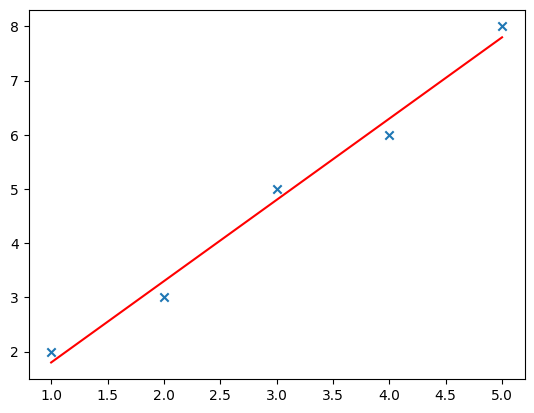

In [ ]:
# Пример линейной зависимости, методом MSE минимизируется расстояние от точек данных до линейного приближения
X= [1,2,3,4,5]
Y=[2,3,5,6,8]
Y_p= linear_model.LinearRegression().fit (np.array(X).reshape(-1,1), Y).predict (np.array(X).reshape(-1,1))
plt.scatter(X, Y, marker='x')
plt.plot(X, Y_p, c='r')

## Расширения линейных моделей для нелинейных данных

Основная идея: в $y = w_1 x_1 + \ldots + w_m x_m$ мы можем представить как:
$y = w_1 f(x_1) + \ldots + w_m f(x_m)$ , где $f(x)$ любая функция, в том числе нелинейная,  к примеру $x_i * x_{i+1}$, то есть комбинация 2 признаков

### полиномиальные признаки

Если есть нелинейная зависимость y от признака, то линрег можно использовать, но для этого  нужно создать полиоминальный признаки х**2, x**3  

In [ ]:
def fy (x):
    return np.sin(x)

In [ ]:
# определяем истинную зависмость как y=sin(x), пробуем сначала обычный линрег, потом добавляем столбец x**2 , потом  x**3
X= [1,2,3,4,5]
Y=[fy(x) for x in X ]
plt.scatter (X, Y, marker='x',  label='true data')
plt.plot (X, Y1, c='r', label='linear' )
plt.plot (X, lm2.predict (X_p2), c='g', label='x**2 feauture')
plt.plot (X, lm3.predict (X_p3), c='y',  label='x**3 feauture')
#plt.plot (X, lm4.predict (X_p4), c='m',  label='x**4 feauture')
plt.legend()


In [ ]:
lm=linear_model.LinearRegression ()
lm.fit ( np.array(X).reshape(-1,1), Y)
lm.coef_, lm.intercept_

(array([-0.52668904]), 1.6152994622671792)

In [ ]:
def predict(x):
    return x*lm.coef_[0] + lm.intercept_

In [ ]:
Y1=[predict (x) for x in X]

In [ ]:
X=np.array(X).reshape(-1,1)
X2=np.array([x**2 for x in X]).reshape(-1,1)
X2

array([[ 1],
       [ 4],
       [ 9],
       [16],
       [25]])

In [ ]:
X_p2=np.hstack ((X,X2))
X_p2

array([[ 1,  1],
       [ 2,  4],
       [ 3,  9],
       [ 4, 16],
       [ 5, 25]])

In [ ]:
lm2=linear_model.LinearRegression ()
lm2.fit ( X_p2, Y)
lm2.coef_, lm.intercept_

(array([-0.23969982, -0.04783154]), 1.6152994622671792)

In [ ]:
lm2.predict (X_p2)

array([ 0.99294734,  0.60975291,  0.13089541, -0.44362518, -1.11380883])

In [ ]:
X_p3=np.hstack ((X_p2,np.array([x**3 for x in X]).reshape(-1,1)))

In [ ]:
X_p3

array([[  1,   1,   1],
       [  2,   4,   8],
       [  3,   9,  27],
       [  4,  16,  64],
       [  5,  25, 125]])

In [ ]:
lm3=linear_model.LinearRegression ()
lm3.fit ( X_p3, Y)
lm3.coef_, lm.intercept_

(array([ 2.7728492 , -1.19668498,  0.12765038]), 1.6152994622671792)

In [ ]:
lm3.predict (X_p3)

array([ 0.83976688,  0.91611383,  0.13089541, -0.74998609, -0.96062838])

In [ ]:
X_p4=np.hstack ((X_p3,np.array([x**4 for x in X]).reshape(-1,1)))
lm4=linear_model.LinearRegression ()
lm4.fit ( X_p4, Y)
lm4.predict (X_p4)

array([ 0.84147098,  0.90929743,  0.14112001, -0.7568025 , -0.95892427])

у scikit learn  есть модуль который позволяет формировать полиномиальные признаки

*Пример с двумерными данными, degree=2*

$$\Large (a, b) \rightarrow (1, a, b, a^2, ab, b^2)$$

In [ ]:
preprocessing.PolynomialFeatures (degree=2, include_bias=False).fit_transform (np.array(X).reshape(-1,1))

array([[0.00000e+00, 0.00000e+00],
       [1.00000e-02, 1.00000e-04],
       [2.00000e-02, 4.00000e-04],
       ...,
       [9.97000e+00, 9.94009e+01],
       [9.98000e+00, 9.96004e+01],
       [9.99000e+00, 9.98001e+01]])

In [ ]:
X_p2

array([[ 1,  1],
       [ 2,  4],
       [ 3,  9],
       [ 4, 16],
       [ 5, 25]])

$$\Large (a, b) \rightarrow (1, a, b, a^2, ab, b^2)$$

In [ ]:

preprocessing.PolynomialFeatures (degree=2, include_bias=False).fit_transform (X_p2)

array([[  1.,   1.,   1.,   1.,   1.],
       [  2.,   4.,   4.,   8.,  16.],
       [  3.,   9.,   9.,  27.,  81.],
       [  4.,  16.,  16.,  64., 256.],
       [  5.,  25.,  25., 125., 625.]])

In [ ]:
 # можно добавить только комбинации признаков x1*x2 , x1*x3, через параметр interaction_only)
 preprocessing.PolynomialFeatures (degree=2, interaction_only=True).fit_transform (X_p2)


array([[  1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.],
       [  1.,   3.,   9.,  27.],
       [  1.,   4.,  16.,  64.],
       [  1.,   5.,  25., 125.]])

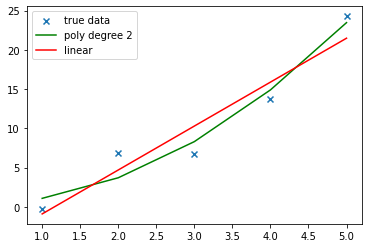

In [ ]:
Yn=[x**2 + np.random.normal(0,2) for x in X]
Y1=linear_model.LinearRegression().fit (np.array(X).reshape(-1,1), Yn).predict (np.array(X).reshape(-1,1))
pipe = pipeline.make_pipeline (preprocessing.PolynomialFeatures(), linear_model.LinearRegression())
pipe.fit(np.array(X).reshape(-1,1),Yn)
pipe.predict (np.array(X).reshape(-1,1))
plt.scatter (X, Yn, marker='x',  label='true data')
plt.plot (X, pipe.predict (np.array(X).reshape(-1,1)), c='g', label='poly degree 2' )
plt.plot (X, Y1, c='r', label='linear')
plt.legend()

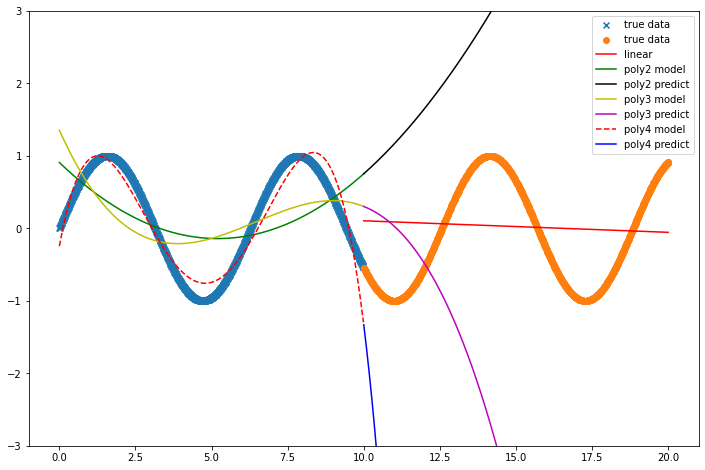

In [ ]:
# при этом полиномамаи хорошо восстанавливать пропущенные значения (типо регресси цен на недвижку), но при экстраполяции на новые данные могут быть сильные отклонения
pipe=pipeline.make_pipeline (preprocessing.PolynomialFeatures(2), linear_model.LinearRegression())
pipe2=pipeline.make_pipeline (preprocessing.PolynomialFeatures(3), linear_model.LinearRegression())
pipe3=pipeline.make_pipeline (preprocessing.PolynomialFeatures(4), linear_model.LinearRegression())

plt.figure (figsize=(12,8))
X= np.linspace (0, 10, 1000, endpoint=False)
Y=[fy(x) for x in X ]
X_=np.linspace (10, 20, 1000)
Y_=[fy(x) for x in X_]
plt.scatter (X, Y, marker='x',  label='true data')
plt.scatter (X_, Y_, marker='o',  label='true data')
Y1=linear_model.LinearRegression().fit (X.reshape(-1,1), Y).predict(X_.reshape(-1,1))
plt.plot (X_, Y1, c='r', label='linear' )
#plt.plot (X_, Y1_, c='grey', label='linear predict' )
pipe.fit (X.reshape(-1,1), Y )
plt.plot (X, pipe.predict(X.reshape(-1,1)), c='g', label='poly2 model', )
plt.plot (X_, pipe.predict(X_.reshape(-1,1)), c='k', label='poly2 predict')
pipe2.fit (X.reshape(-1,1), Y )
plt.plot (X, pipe2.predict(X.reshape(-1,1)), c='y', label='poly3 model')
plt.plot (X_, pipe2.predict(X_.reshape(-1,1)), c='m', label='poly3 predict')
pipe3.fit (X.reshape(-1,1), Y )
plt.plot (X, pipe3.predict(X.reshape(-1,1)), '--r', label='poly4 model')
plt.plot (X_, pipe3.predict(X_.reshape(-1,1)), c='b', label='poly4 predict')
#plt.plot (X_, pipe2.predict(np.array(X_).reshape(-1,1)), c='y', label='poly3 model')
#pipe3.fit (np.array(X).reshape(-1,1), Y )
#plt.plot (X_, pipe3.predict(np.array(X_).reshape(-1,1)), c='r', label='poly4 model')
#plt.plot (X, lm4.predict (X_p4), c='m',  label='x**4 feauture')
plt.ylim( -3,3)
plt.legend()

### Гауссовый базис (сумма не полиномиальных признаков, а гауссиан, т.е. y - это сумма гауссиан)

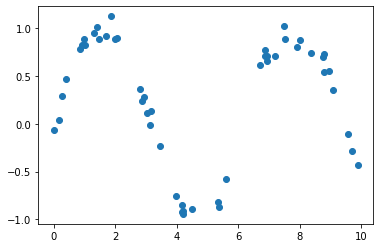

In [ ]:
xfit = np.linspace(0, 10, 1000)
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
plt.scatter(x, y)


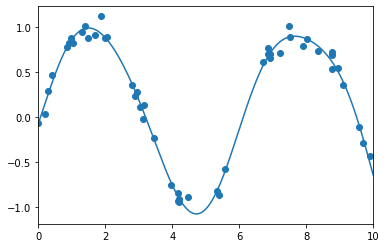

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""

    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))

    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self

    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

gauss_model = pipeline.make_pipeline(GaussianFeatures(10),
                            linear_model.LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

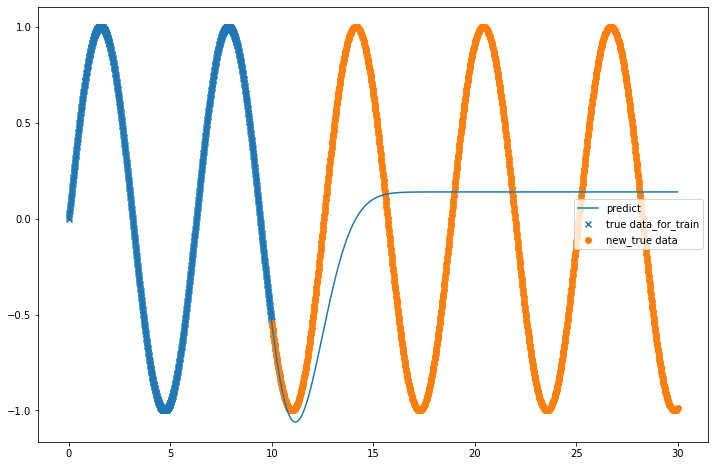

In [ ]:
gauss_model = pipeline.make_pipeline(GaussianFeatures(13), # интересно, что на 13 распределениях, модель не может далеко и точно предсказывать, НО выдает сглаженную прямую, что лучше, чем поли, которые уходят в небеса
                            linear_model.LinearRegression())
xfit = np.linspace (0, 30, 1000)
plt.figure (figsize=(12,8))
X= np.linspace (0, 10, 1000, endpoint=False)
Y=[np.sin(x) for x in X ]
X_=np.linspace (10, 30, 1000)
Y_=[np.sin(x) for x in X_]
gauss_model.fit(X[:, np.newaxis], Y)
yfit = gauss_model.predict(xfit[:, np.newaxis])
plt.scatter (X, Y, marker='x',  label='true data_for_train')
plt.scatter (X_, Y_, marker='o',  label='new_true data')
plt.plot(xfit, yfit, label='predict')
plt.legend()

## Регрессия на примере недвижки (бостон и калифорния сет)

### Бостон

- CRIM Уровень преступности на душу населения по городам  
- ZH доля земли под жилую застройку зонирована на участки площадью более 25 000 кв. Футов.  
- INDUS доля акров, не относящихся к розничной торговле, на город  
- CHAS Фиктивная переменная реки Чарльз (= 1, если участок ограничивает реку; 0 в противном случае)  
- Концентрация оксидов азота NOX (частей на 10 миллионов)  
- RM среднее количество комнат в доме  
- AGE Доля домов, построенных до 1940 года, занимаемых владельцами  
- DIS взвесила расстояния до пяти бостонских центров занятости  
- Индекс доступности радиальных автомобильных дорог RAD  
- TAX Полная ставка налога на имущество за 10 000 долларов США  
- PTRATIO соотношение учеников и учителей по городам  
- B 1000 (Bk — 0,63) ^ 2, где Bk — доля чернокожего населения по городам.  
- LSTAT% более низкий статус населения  
- MEDV Средняя стоимость частных домов в 1000 долларов  

In [ ]:
df= pd.DataFrame (datasets.load_boston ( ).get('data'), columns=datasets.load_boston ( ).get('feature_names'))
y = datasets.load_boston ( ).get('target')
df

#### SciKit основное

In [ ]:
sns.pairplot(pd.concat ([df, pd.DataFrame(y)], axis=1))

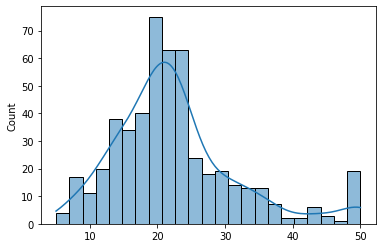

In [ ]:
sns.histplot (y , kde=True ) # распределение более похоже на нормальное и так же есть небольшой выброс на отметке 50

(array([ 4., 17., 10., 17., 40., 30., 37., 71., 64., 64., 31., 17., 19.,
        16., 15., 10.,  9.,  3.,  2.,  4.,  4.,  3.,  3.]),
 array([ 5.        ,  6.91304348,  8.82608696, 10.73913043, 12.65217391,
        14.56521739, 16.47826087, 18.39130435, 20.30434783, 22.2173913 ,
        24.13043478, 26.04347826, 27.95652174, 29.86956522, 31.7826087 ,
        33.69565217, 35.60869565, 37.52173913, 39.43478261, 41.34782609,
        43.26086957, 45.17391304, 47.08695652, 49.        ]),
 <a list of 23 Patch objects>)

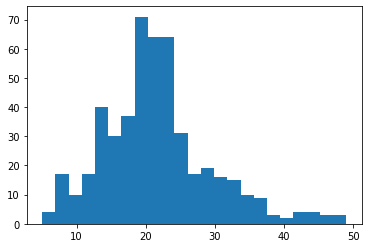

In [ ]:
plt.hist ( y, range=(y.min() , 49) , bins= 23 )

In [ ]:
y.mean() , y.std()

(22.532806324110677, 9.188011545278203)

In [ ]:
# для получения более надежной оценки работы модели, с учетом выбросов нужно разбивать трэйн и тест при помощи Stratifed KFold или через параметр stratify train test split
pd.concat ([df, pd.DataFrame(y)], axis=1)[pd.concat ([df, pd.DataFrame(y)], axis=1)[0]>49]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,0
161,1.46336,0.0,19.58,0.0,0.6050,7.489,90.8,1.9709,5.0,403.0,14.7,374.43,1.73,50.0
162,1.83377,0.0,19.58,1.0,0.6050,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
163,1.51902,0.0,19.58,1.0,0.6050,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,50.0
166,2.01019,0.0,19.58,0.0,0.6050,7.929,96.2,2.0459,5.0,403.0,14.7,369.30,3.70,50.0
186,0.05602,0.0,2.46,0.0,0.4880,7.831,53.6,3.1992,3.0,193.0,17.8,392.63,4.45,50.0
195,0.01381,80.0,0.46,0.0,0.4220,7.875,32.0,5.6484,4.0,255.0,14.4,394.23,2.97,50.0
204,0.02009,95.0,2.68,0.0,0.4161,8.034,31.9,5.1180,4.0,224.0,14.7,390.55,2.88,50.0
225,0.52693,0.0,6.20,0.0,0.5040,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63,50.0
257,0.61154,20.0,3.97,0.0,0.6470,8.704,86.9,1.8010,5.0,264.0,13.0,389.70,5.12,50.0
267,0.57834,20.0,3.97,0.0,0.5750,8.297,67.0,2.4216,5.0,264.0,13.0,384.54,7.44,50.0


In [ ]:
df['label'] = [1 if x>49 else 0 for x in y ]

In [ ]:
df[df['label']==1]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,label
161,1.46336,0.0,19.58,0.0,0.6050,7.489,90.8,1.9709,5.0,403.0,14.7,374.43,1.73,1
162,1.83377,0.0,19.58,1.0,0.6050,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,1
163,1.51902,0.0,19.58,1.0,0.6050,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,1
166,2.01019,0.0,19.58,0.0,0.6050,7.929,96.2,2.0459,5.0,403.0,14.7,369.30,3.70,1
186,0.05602,0.0,2.46,0.0,0.4880,7.831,53.6,3.1992,3.0,193.0,17.8,392.63,4.45,1
195,0.01381,80.0,0.46,0.0,0.4220,7.875,32.0,5.6484,4.0,255.0,14.4,394.23,2.97,1
204,0.02009,95.0,2.68,0.0,0.4161,8.034,31.9,5.1180,4.0,224.0,14.7,390.55,2.88,1
225,0.52693,0.0,6.20,0.0,0.5040,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63,1
257,0.61154,20.0,3.97,0.0,0.6470,8.704,86.9,1.8010,5.0,264.0,13.0,389.70,5.12,1
267,0.57834,20.0,3.97,0.0,0.5750,8.297,67.0,2.4216,5.0,264.0,13.0,384.54,7.44,1


In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split (df, y,  stratify=df['label'] )

In [ ]:
len (X_train [X_train['label']==1]) /len ( X_train) , len (X_test [X_test['label']==1]) /len ( X_test)

(0.0316622691292876, 0.031496062992125984)

In [ ]:
X_train.pop ('label') , X_test.pop ('label') ;

In [ ]:
X_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
104,0.13960,0.0,8.56,0.0,0.5200,6.167,90.0,2.4210,5.0,384.0,20.9,392.69,12.33
204,0.02009,95.0,2.68,0.0,0.4161,8.034,31.9,5.1180,4.0,224.0,14.7,390.55,2.88
423,7.05042,0.0,18.10,0.0,0.6140,6.103,85.1,2.0218,24.0,666.0,20.2,2.52,23.29
356,8.98296,0.0,18.10,1.0,0.7700,6.212,97.4,2.1222,24.0,666.0,20.2,377.73,17.60
370,6.53876,0.0,18.10,1.0,0.6310,7.016,97.5,1.2024,24.0,666.0,20.2,392.05,2.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0.32982,0.0,21.89,0.0,0.6240,5.822,95.4,2.4699,4.0,437.0,21.2,388.69,15.03
199,0.03150,95.0,1.47,0.0,0.4030,6.975,15.3,7.6534,3.0,402.0,17.0,396.90,4.56
293,0.08265,0.0,13.92,0.0,0.4370,6.127,18.4,5.5027,4.0,289.0,16.0,396.90,8.58
110,0.10793,0.0,8.56,0.0,0.5200,6.195,54.4,2.7778,5.0,384.0,20.9,393.49,13.00


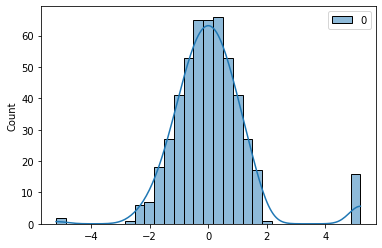

In [ ]:
sns.histplot ( preprocessing.QuantileTransformer  (output_distribution='normal').fit_transform (y.reshape(-1,1)) , kde=True  )

CV_MAE_score [3.42247231 3.37035216 3.50593048 3.49175865 3.4346995 ]
Mean_AE:  3.823849503887146
Median_AE:  2.9397078259339366
R2:  0.6327633682888154
Mean_AE:  3.823849503887146
Median_AE:  2.9397078259339366
R2:  0.6327633682888154


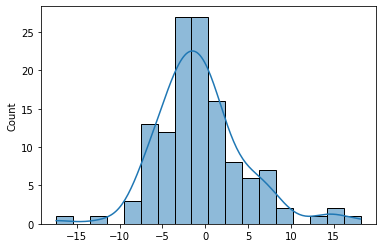

In [ ]:
# строим baseline без с нормирования таргета
base = pipeline.make_pipeline ( preprocessing.StandardScaler () , linear_model.LinearRegression ())
base.fit ( X_train, y_train)
print ("CV_MAE_score" , - model_selection.cross_val_score (base , X_train, y_train, scoring='neg_mean_absolute_error' ) )
res1 = dict ([('base' , (reg_scorer ( base, y_test, X_test)[0] ) )])
sns.histplot (reg_scorer ( base, y_test, X_test)[1] , kde = True) ;

CV_MAE_score [3.11097481 3.53704846 3.42071668 3.58568225 3.847451  ]
Mean_AE:  4.709175594114939
Median_AE:  3.299999999999997
R2:  0.34279219677957184
Mean_AE:  4.709175594114939
Median_AE:  3.299999999999997
R2:  0.34279219677957184


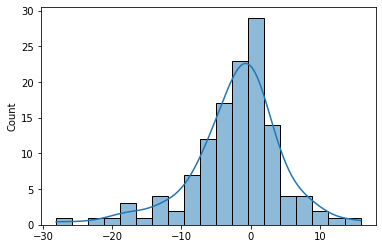

In [ ]:
# строим baseline с нормированием таргета
tr = compose.TransformedTargetRegressor (  regressor= linear_model.LinearRegression () , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
base_norm = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr)
base_norm.fit ( X_train, y_train)
print ("CV_MAE_score" , - model_selection.cross_val_score (base_norm , X_train, y_train, scoring='neg_mean_absolute_error' ) )
res1['base_norm'] = reg_scorer ( base_norm, y_test, X_test)[0]
sns.histplot (reg_scorer ( base_norm, y_test, X_test)[1] , kde = True) ;

CV_MAE_score [2.99788716 2.19923745 2.62312497 2.47024852 2.87836294]
Mean_AE:  2.8165312318577933
Median_AE:  1.6999999999999993
R2:  0.7444848344238573
Mean_AE:  2.8165312318577933
Median_AE:  1.6999999999999993
R2:  0.7444848344238573


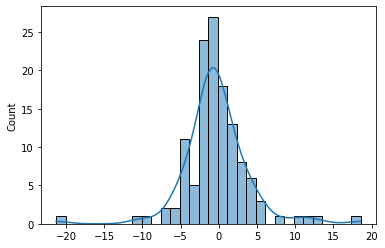

In [ ]:
# теперь Huber
tr_h = compose.TransformedTargetRegressor (  regressor= linear_model.HuberRegressor() , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
huber = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr_h)
huber.fit ( X_train, y_train)
print ("CV_MAE_score" , - model_selection.cross_val_score (huber , X_train, y_train, scoring='neg_mean_absolute_error' ) )
res1['huber'] = reg_scorer ( huber, y_test, X_test)[0]
sns.histplot (reg_scorer ( huber, y_test, X_test)[1] , kde = True) ;

In [ ]:
# теперь пробуем выделить важные признаки и применить поли
tr_l = compose.TransformedTargetRegressor (  regressor= linear_model.Lasso ( alpha=0.05) , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
lasso = pipeline.make_pipeline ( preprocessing.StandardScaler() , tr_l )
print ("CV_MAE_score" , - model_selection.cross_val_score (lasso , X_train, y_train, scoring='neg_mean_absolute_error' ) )
lasso.fit ( X_train, y_train)
reg_scorer ( lasso, y_test, X_test)[0]

CV_MAE_score [2.9021419  2.53625769 3.16612682 3.12311113 3.18225518]
Mean_AE:  3.4704338775485803
Median_AE:  2.1999999999999993
R2:  0.5916272470954607


[3.4704338775485803, 2.1999999999999993, 0.5916272470954607]

In [ ]:
res1

{'base': [3.823849503887146, 2.9397078259339366, 0.6327633682888154],
 'base_norm': [4.709175594114939, 3.299999999999997, 0.34279219677957184],
 'huber': [2.8165312318577933, 1.6999999999999993, 0.7444848344238573]}

In [ ]:
base_norm[-1].regressor_.coef_ , base_norm[-1].regressor_.intercept_ # интересно, что лассо показало результаты лучше, чем base при том, что судя по весам base не выглядит переобученной

(array([-0.2455505 ,  0.23360159,  0.20453234,  0.16928709, -0.34745422,
         0.20140567,  0.09221694, -0.47006587,  0.39897559, -0.27924093,
        -0.24406879,  0.11405278, -0.75780871]), 0.08079614707986314)

In [ ]:
lasso[-1].regressor_.coef_ , lasso[-1].regressor_.intercept_# при альфа равной 0.05 моедль имеет максимаьлные показаители   признаки

(array([-0.13596376,  0.03786045,  0.        ,  0.13903968, -0.00123659,
         0.24061596,  0.        , -0.18988489,  0.        ,  0.        ,
        -0.15957232,  0.06607113, -0.70097127]), 0.08079614707986209)

In [ ]:
X_train.columns[[0, 3, 4,  5, 7, 10, 11, 12]]

Index(['CRIM', 'CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT'], dtype='object')

In [ ]:
X_train.columns[[0, 3, 5, 10, 11, 12]] # при alpha = 0.15 - 0.2 остается 4-5 признаков, но качество модели падает

Index(['CRIM', 'CHAS', 'RM', 'PTRATIO', 'B', 'LSTAT'], dtype='object')

In [ ]:
X_train.columns[[0, 3, 5, 7, 10,11,12 ]] # alpha = 0.1 показатели модель чуть улучшается, добавляется признак - 'B' и 'DIS'

Index(['CRIM', 'CHAS', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT'], dtype='object')

In [ ]:
res1 ['lasso_a_0.05'] = reg_scorer (lasso, y_test, X_test )[0]

Mean_AE:  3.4704338775485803
Median_AE:  2.1999999999999993
R2:  0.5916272470954607


In [ ]:
X_train_tr = X_train[ ['CRIM', 'CHAS', 'NOX' , 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT']]
X_test_tr = X_test [ ['CRIM', 'CHAS', 'NOX' , 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT']]
X_train_tr

,CRIM,CHAS,NOX,RM,DIS,PTRATIO,B,LSTAT
104,0.13960,0.0,0.5200,6.167,2.4210,20.9,392.69,12.33
204,0.02009,0.0,0.4161,8.034,5.1180,14.7,390.55,2.88
423,7.05042,0.0,0.6140,6.103,2.0218,20.2,2.52,23.29
356,8.98296,1.0,0.7700,6.212,2.1222,20.2,377.73,17.60
370,6.53876,1.0,0.6310,7.016,1.2024,20.2,392.05,2.96
...,...,...,...,...,...,...,...,...
133,0.32982,0.0,0.6240,5.822,2.4699,21.2,388.69,15.03
199,0.03150,0.0,0.4030,6.975,7.6534,17.0,396.90,4.56
293,0.08265,0.0,0.4370,6.127,5.5027,16.0,396.90,8.58
110,0.10793,0.0,0.5200,6.195,2.7778,20.9,393.49,13.00


In [ ]:
any([y_train==49][0])  # проверяем можно ли обрезать по границе 49 (без оператора меньеш или равно)

False

In [ ]:
X_train_tr[[y_train>49][0]]

,CRIM,CHAS,NOX,RM,DIS,PTRATIO,B,LSTAT
204,0.02009,0.0,0.4161,8.034,5.1180,14.7,390.55,2.88
370,6.53876,1.0,0.6310,7.016,1.2024,20.2,392.05,2.96
166,2.01019,0.0,0.6050,7.929,2.0459,14.7,369.30,3.70
225,0.52693,0.0,0.5040,8.725,2.8944,17.4,382.00,4.63
283,0.01501,1.0,0.4010,7.923,5.8850,13.6,395.52,3.16
163,1.51902,1.0,0.6050,8.375,2.1620,14.7,388.45,3.32
195,0.01381,0.0,0.4220,7.875,5.6484,14.4,394.23,2.97
368,4.89822,0.0,0.6310,4.970,1.3325,20.2,375.52,3.26
267,0.57834,0.0,0.5750,8.297,2.4216,13.0,384.54,7.44
371,9.23230,0.0,0.6310,6.216,1.1691,20.2,366.15,9.53


In [ ]:
y_train [y_train>49]

array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.])

In [ ]:
# теперь пробуем поли на важных признаках, очищаем трэйн от выбросов и лишних признаков, обучаем модель и применяем на отложенной
X_train_tr = X_train[ ['CRIM', 'CHAS', 'NOX' , 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT']] #убираем признаки и в трейне и тесте
X_test_tr = X_test [ ['CRIM', 'CHAS', 'NOX' , 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT']]
X_tr_cl = X_train_tr [[y_train<49][0]]  # очищаем от выбросов только трейн
y_tr_cl = y_train [y_train<49]
R2 = []
MAE = []
MDAE = []
tr_ = compose.TransformedTargetRegressor (  regressor= linear_model.LinearRegression () , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
for n in range ( 2, 15):
    m = pipeline.make_pipeline ( preprocessing.StandardScaler(), preprocessing.PolynomialFeatures (n) , tr_)
    m.fit ( X_tr_cl, y_tr_cl)
    f = reg_scorer (m , y_test, X_test_tr )
    MAE.append (f[0][0])
    MDAE.append (f[0][1])
    R2.append ( f[0][2])
    print ('poly ', n )
    print ('CVS R2', -model_selection.cross_val_score ( m, X_tr_cl, y_tr_cl, scoring='neg_mean_absolute_error'))

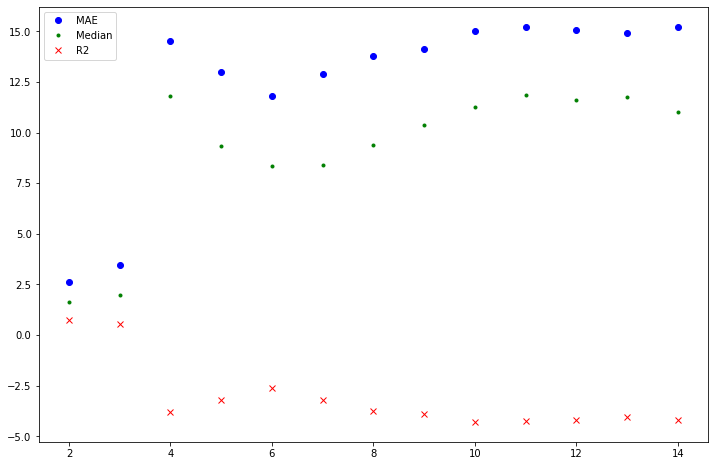

In [ ]:
plt.figure (figsize=(12,8)) # оптимум полином 2 степени
x= np.arange ( 2, 15)
plt.plot (x, MAE, 'ob', label = 'MAE' )
plt.plot (x, MDAE, '.g', label = 'Median'  )
plt.plot (x, R2, 'xr', label = 'R2'  )
plt.legend()

In [ ]:
res1

{'base': [3.823849503887146, 2.9397078259339366, 0.6327633682888154],
 'base_norm': [4.709175594114939, 3.299999999999997, 0.34279219677957184],
 'huber': [2.8165312318577933, 1.6999999999999993, 0.7444848344238573],
 'lasso_a_0.05': [3.4704338775485803, 2.1999999999999993, 0.5916272470954607]}

In [ ]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,label
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,0
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,0
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,0
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,0


CV_MAE_score [2.78457447 2.10036946 3.52516015 2.09522667 1.98362306]
Mean_AE:  2.6297639005260587
Median_AE:  1.6422470360551316
R2:  0.745199339685175
Mean_AE:  2.6297639005260587
Median_AE:  1.6422470360551316
R2:  0.745199339685175


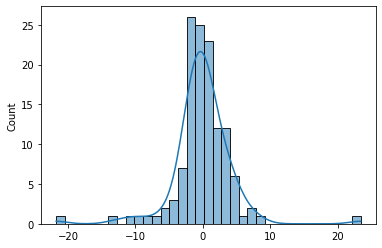

In [ ]:
# строим poly 2 с нормированием таргета
tr = compose.TransformedTargetRegressor (  regressor= linear_model.LinearRegression () , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
poly = pipeline.make_pipeline ( preprocessing.StandardScaler () , preprocessing.PolynomialFeatures ( 2) , tr)
poly.fit ( X_tr_cl, y_tr_cl)
print ("CV_MAE_score" , - model_selection.cross_val_score (poly , X_tr_cl, y_tr_cl, scoring='neg_mean_absolute_error' ) )
res1['poly'] = reg_scorer ( poly, y_test, X_test_tr)[0]
sns.histplot (reg_scorer ( poly, y_test, X_test_tr)[1] , kde = True) ;

In [ ]:
fin_res = pd.DataFrame.from_dict (res1 , orient='index' , columns = ['MAE', 'MedAE' , 'R2']) # также как и в бостоне хубер и поли имеют приерно одинаково хороши, попробуем объеденить их
fin_res

,MAE,MedAE,R2
base,3.823850,2.939708,0.632763
base_norm,4.709176,3.300000,0.342792
huber,2.816531,1.700000,0.744485
lasso_a_0.05,3.470434,2.200000,0.591627
poly,2.629764,1.642247,0.745199


CV_MAE_score [2.54542639 2.12814483 3.13518762 2.06492735 2.23470655]
Mean_AE:  2.5394193660776345
Median_AE:  1.6000000000000014
R2:  0.7816113564222218
Mean_AE:  2.5394193660776345
Median_AE:  1.6000000000000014
R2:  0.7816113564222218


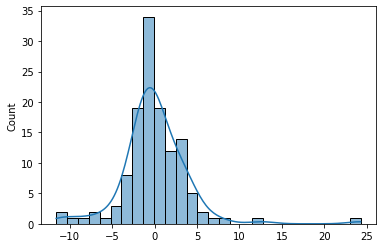

In [ ]:
# строим poly 2 + huber с нормированием таргета
tr_hp = compose.TransformedTargetRegressor (  regressor= linear_model.HuberRegressor () , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
poly_huber  = pipeline.make_pipeline ( preprocessing.StandardScaler () , preprocessing.PolynomialFeatures ( 2) , tr_hp)
poly_huber.fit ( X_tr_cl, y_tr_cl)
print ("CV_MAE_score" , - model_selection.cross_val_score (poly_huber , X_tr_cl, y_tr_cl, scoring='neg_mean_absolute_error' ) )
res1['poly_huber'] = reg_scorer ( poly_huber , y_test, X_test_tr)[0]
sns.histplot (reg_scorer ( poly_huber , y_test, X_test_tr)[1] , kde = True) ;

In [ ]:
fin_res = pd.DataFrame.from_dict (res1 , orient='index' , columns = ['MAE', 'MedAE' , 'R2']) # принципиальных изменений нет, но у Huber есть гиперпараметры, можно попытаться их настроить
fin_res

,MAE,MedAE,R2
base,3.823850,2.939708,0.632763
base_norm,4.709176,3.300000,0.342792
huber,2.816531,1.700000,0.744485
lasso_a_0.05,3.470434,2.200000,0.591627
poly,2.629764,1.642247,0.745199
poly_huber,2.539419,1.600000,0.781611


In [ ]:
params = dict ( [("transformedtargetregressor__regressor__epsilon", np.linspace ( 1.01, 1.9, 20) ), ("transformedtargetregressor__regressor__alpha" , np.linspace ( 0.0001, 0.5, 100))]  )
grid = model_selection.GridSearchCV (estimator = huber, param_grid=params, scoring="neg_mean_absolute_error" , verbose=4 ,  cv=5, n_jobs=5)
grid.fit (X_train, y_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('transformedtargetregressor',
                                        TransformedTargetRegressor(regressor=HuberRegressor(),
                                                                   transformer=QuantileTransformer(output_distribution='normal')))]),
             n_jobs=5,
             param_grid={'transformedtargetregressor__regressor__alpha': array([1.00000000e-04, 5.14949495e-03, 1.01989899e-02,...
       4.84851515e-01, 4.89901010e-01, 4.94950505e-01, 5.00000000e-01]),
                         'transformedtargetregressor__regressor__epsilon': array([1.01      , 1.05684211, 1.10368421, 1.15052632, 1.19736842,
       1.24421053, 1.29105263, 1.33789474, 1.38473684, 1.43157895,
       1.47842105, 1.52526316, 1.57210526, 1.61894737, 1.66578947,
       1.71263158, 1.75947368, 1.80631579, 1.85315789, 1.9       ])},
             scoring='neg_mean_a

In [ ]:
grid.best_params_ , grid.best_score_

({'transformedtargetregressor__regressor__alpha': 0.5,
  'transformedtargetregressor__regressor__epsilon': 1.1036842105263158},
 -2.629710770579565)

CV_MAE_score [3.05273874 2.09397821 2.62932127 2.41998546 2.96982837]
CV_MAE_score_mean 2.633170410777799
Mean_AE:  2.6443594967031148
Median_AE:  1.6000000000000014
R2:  0.7623607317299333
Mean_AE:  2.6443594967031148
Median_AE:  1.6000000000000014
R2:  0.7623607317299333


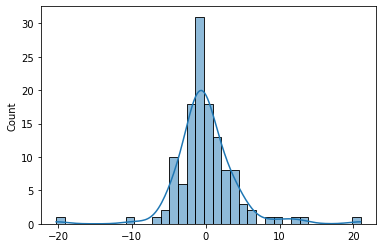

In [ ]:
# строим Huber  с оптимальными гиперпараметрами видим, что на трейне скор больше, чем на отложенной выборке, попробуем поиграть  параметром штрафа
tr_h = compose.TransformedTargetRegressor (  regressor= linear_model.HuberRegressor( epsilon=1.01 , alpha = 7) , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
huber = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr_h)
huber.fit ( X_train, y_train)
print ("CV_MAE_score" , - model_selection.cross_val_score (huber , X_train, y_train, scoring='neg_mean_absolute_error' ) )
print ("CV_MAE_score_mean" , np.array (- model_selection.cross_val_score (huber , X_train, y_train, scoring='neg_mean_absolute_error' ).mean() ) )
res1['huber_opt_a7'] = reg_scorer ( huber, y_test, X_test)[0]
sns.histplot (reg_scorer ( huber, y_test, X_test)[1] , kde = True) ;

In [ ]:
train_score , test_score = model_selection.validation_curve ( huber, df.iloc[:, :-1] , y, groups = df.iloc[:, -1], param_name= "transformedtargetregressor__regressor__alpha" ,
                                                             param_range=np.linspace  ( 0 , 10, 200), scoring='neg_mean_absolute_error')

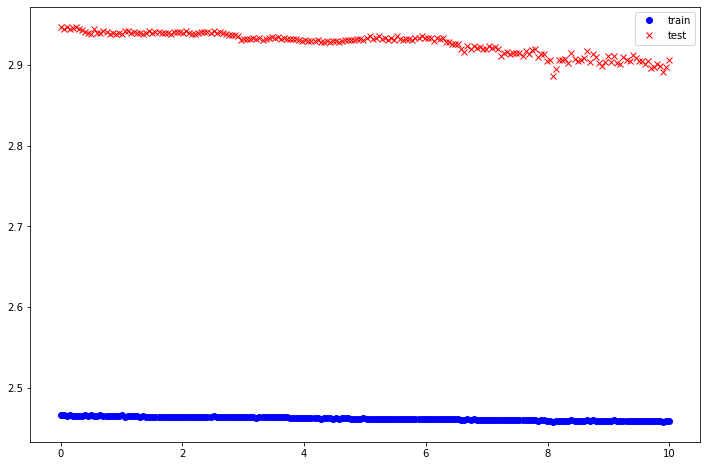

In [ ]:
plt.figure (figsize=(12,8))
x= np.linspace  ( 0 , 10, 200)
plt.plot (x, - np.mean (train_score, axis=1), 'ob', label = 'train' )
plt.plot (x, - np.mean (test_score, axis=1), 'xr', label = 'test'  )
plt.legend()

In [ ]:
R2 = []
MAE = []
MDAE = []
for a in np.linspace  (0.1 , 25, 100):
  tr_h = compose.TransformedTargetRegressor (  regressor= linear_model.HuberRegressor( epsilon=1.01 , alpha = a) , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
  huber = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr_h)
  huber.fit ( X_train, y_train)
  f = reg_scorer (huber , y_test, X_test )
  MAE.append (f[0][0])
  MDAE.append (f[0][1])
  R2.append ( f[0][2])


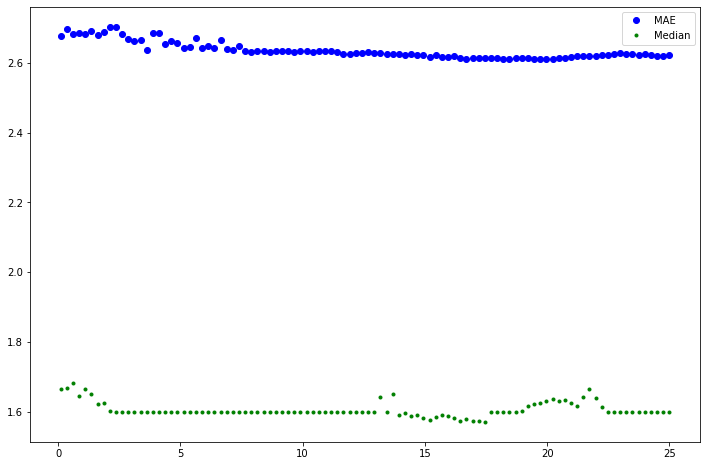

In [ ]:
plt.figure (figsize=(12,8))
x= np.linspace  (0.1 , 25, 100)
plt.plot (x, MAE, 'ob', label = 'MAE' )
plt.plot (x, MDAE, '.g', label = 'Median'  )
plt.legend()

In [ ]:
reg_scorer ( huber, y_test, X_test)[1].mean() , reg_scorer ( huber, y_test, X_test)[1].std()

Mean_AE:  2.621155602537762
Median_AE:  1.5999999999999979
R2:  0.7511067353520384
Mean_AE:  2.621155602537762
Median_AE:  1.5999999999999979
R2:  0.7511067353520384


(0.011422194296702846, 4.247576053389958)

In [ ]:
fin_res = pd.DataFrame.from_dict (res1 , orient='index' , columns = ['MAE', 'MedAE' , 'R2'])  # по итогу poly huber и прсото huber фавориты
fin_res

,MAE,MedAE,R2
base,3.823850,2.939708,0.632763
base_norm,4.709176,3.300000,0.342792
huber,2.816531,1.700000,0.744485
lasso_a_0.05,3.470434,2.200000,0.591627
poly,2.629764,1.642247,0.745199
poly_huber,2.539419,1.600000,0.781611
huber_opt_a7,2.644359,1.600000,0.762361


#### LARS , LARS_LASSO, OMP, Байесовская регрессия, GLM, Tweedy,  RANSAC, Theil-Sen, Kernel Ridge


In [ ]:
# theil как и huber подстраивается под основную выборку а не под выбросы
tr_t = compose.TransformedTargetRegressor (  regressor= linear_model.TheilSenRegressor ( ) , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
theil = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr_h)
theil.fit ( X_train, y_train)
reg_scorer (theil , y_test, X_test )[0]

Mean_AE:  2.621155602537762
Median_AE:  1.5999999999999979
R2:  0.7511067353520384


[2.621155602537762, 1.5999999999999979, 0.7511067353520384]

In [ ]:
res1['theil'] = reg_scorer (theil , y_test, X_test )[0]

Mean_AE:  2.621155602537762
Median_AE:  1.5999999999999979
R2:  0.7511067353520384


Mean_AE:  2.621155602537762
Median_AE:  1.5999999999999979
R2:  0.7511067353520384


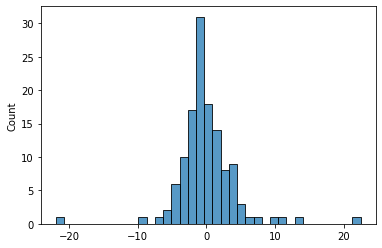

In [ ]:
sns.histplot (reg_scorer (theil , y_test, X_test )[1] )

In [ ]:
def env_score ( model, y_test, X_test, dct):
  dct[str(model[-1].regressor_)] = reg_scorer (model, y_test, X_test )[0]
  sns.histplot (reg_scorer (model , y_test, X_test )[1] )


Mean_AE:  4.709175594114938
Median_AE:  3.299999999999997
R2:  0.3427921967795714
Mean_AE:  4.709175594114938
Median_AE:  3.299999999999997
R2:  0.3427921967795714


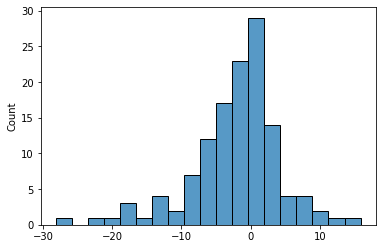

In [ ]:

tr_lars = compose.TransformedTargetRegressor (  regressor= linear_model.LarsCV ( ) , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
lars = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr_lars)
lars.fit ( X_train, y_train)
pars = dict ( y_test = y_test, X_test = X_test, dct = res1)
env_score (lars, **pars)

Mean_AE:  4.52043511954337
Median_AE:  2.8000000000000007
R2:  0.38650642181258843
Mean_AE:  4.52043511954337
Median_AE:  2.8000000000000007
R2:  0.38650642181258843


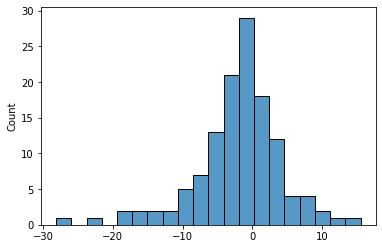

In [ ]:
tr_br = compose.TransformedTargetRegressor (  regressor= linear_model.BayesianRidge () , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
br = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr_br)
br.fit ( X_train, y_train)
pars = dict ( y_test = y_test, X_test = X_test, dct = res1)
env_score (br, **pars)

Mean_AE:  4.54521478993889
Median_AE:  2.8000000000000007
R2:  0.38372401442822834
Mean_AE:  4.54521478993889
Median_AE:  2.8000000000000007
R2:  0.38372401442822834


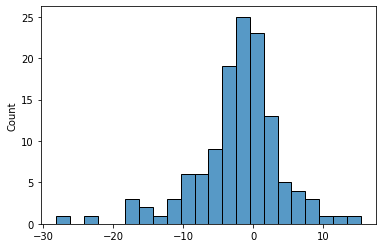

In [ ]:
tr_br1 = compose.TransformedTargetRegressor (  regressor= linear_model.ARDRegression () , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
br1 = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr_br1)
br1.fit ( X_train, y_train)
env_score (br1, **pars)

Mean_AE:  4.107041250863614
Median_AE:  2.299999999999999
R2:  0.44565664749149825
Mean_AE:  4.107041250863614
Median_AE:  2.299999999999999
R2:  0.44565664749149825


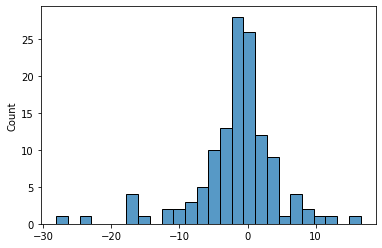

In [ ]:
tr_omp = compose.TransformedTargetRegressor (  regressor= linear_model.OrthogonalMatchingPursuit() , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
omp = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr_omp)
omp.fit ( X_train, y_train)
env_score (omp, **pars)

Mean_AE:  2.6836602391124638
Median_AE:  1.5999999999999979
R2:  0.7045145592990691
Mean_AE:  2.6836602391124638
Median_AE:  1.5999999999999979
R2:  0.7045145592990691


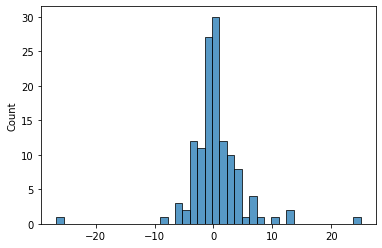

In [ ]:
tr_ransac = compose.TransformedTargetRegressor (  regressor= linear_model.RANSACRegressor (linear_model.TheilSenRegressor () ) , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
ransac = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr_ransac)
ransac.fit ( X_train, y_train)
env_score (ransac, **pars)

Mean_AE:  3.2300462376130743
Median_AE:  2.2067984377010017
R2:  0.6834383441410694
Mean_AE:  3.2300462376130743
Median_AE:  2.2067984377010017
R2:  0.6834383441410694


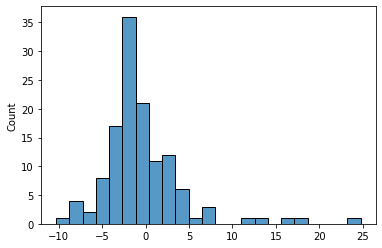

In [ ]:
tweedy = pipeline.make_pipeline ( preprocessing.StandardScaler () , linear_model.TweedieRegressor (power = 2))
tweedy.fit ( X_train, y_train)
reg_scorer ( tweedy , y_test, X_test )[0]
sns.histplot (reg_scorer ( tweedy , y_test, X_test )[1] )

Mean_AE:  4.426902085773754
Median_AE:  2.7293606523596665
R2:  0.4108666344437166
Mean_AE:  4.426902085773754
Median_AE:  2.7293606523596665
R2:  0.4108666344437166


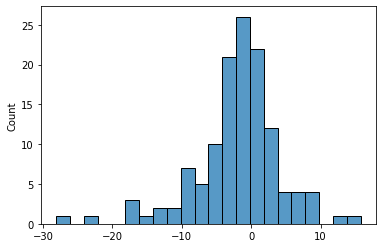

In [ ]:
tr_SGD = compose.TransformedTargetRegressor (  regressor= linear_model.SGDRegressor ( ) , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
SGD = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr_SGD)
SGD.fit ( X_train, y_train)
env_score (SGD, **pars)

Mean_AE:  4.228718500168144
Median_AE:  2.6999999999999993
R2:  0.4451125835111662
Mean_AE:  4.228718500168144
Median_AE:  2.6999999999999993
R2:  0.4451125835111662


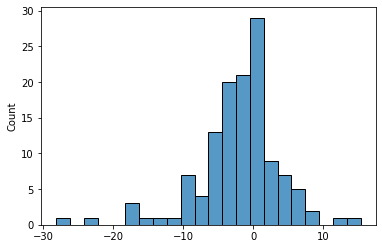

In [ ]:
tr_pa = compose.TransformedTargetRegressor (  regressor= linear_model.PassiveAggressiveRegressor (C=0.001 , loss='squared_epsilon_insensitive') , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
pa = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr_pa)
pa.fit ( X_train, y_train)
env_score (pa, **pars)

In [ ]:
# Kernel Ridge - нелинейная модель, а SVM но использует в работе Ridge Regressor
tr_kr = compose.TransformedTargetRegressor (  regressor= kernel_ridge.KernelRidge ( alpha=0.001) , transformer= preprocessing.QuantileTransformer  (output_distribution='normal'))
kr = pipeline.make_pipeline ( preprocessing.StandardScaler () , tr_kr)
kr.fit ( X_train, y_train)
env_score (kr, **pars)

In [ ]:
fin_res = pd.DataFrame.from_dict (res1 , orient='index' , columns = ['MAE', 'MedAE' , 'R2'])
fin_res

,MAE,MedAE,R2
base,3.823850,2.939708,0.632763
base_norm,4.709176,3.300000,0.342792
huber,2.816531,1.700000,0.744485
lasso_a_0.05,3.470434,2.200000,0.591627
poly,2.629764,1.642247,0.745199
poly_huber,2.539419,1.600000,0.781611
huber_opt_a7,2.644359,1.600000,0.762361
theil,2.621156,1.600000,0.751107
LarsCV(),4.709176,3.300000,0.342792
BayesianRidge(),4.520435,2.800000,0.386506


In [ ]:
res1 ['PassiveAggressiveRegressor(C=0.001, loss=\'squared_epsilon_insensitive\')']

[4.228718500168144, 2.6999999999999993, 0.4451125835111662]

In [ ]:
 # LARS - LARS похож на пошаговую регрессию вперед. На каждом этапе он находит функцию, наиболее коррелирующую с целью. Когда есть несколько объектов,
 # имеющих одинаковую корреляцию, вместо того, чтобы продолжать движение по одному и тому же объекту, он движется в одинаковом направлении между объектами
 # численно эффективен в контекстах, где количество функций значительно превышает количество образцов

 # LassoLars представляет собой модель лассо, реализованную с использованием алгоритма LARS, и в отличие от реализации, основанной на координатном спуске,
 # это дает точное решение, которое является кусочно-линейным как функция нормы его коэффициентов

  # Регуляризация по байесовски: параметр регуляризации не устанавливается в жестком смысле, а настраивается на имеющиеся данные
 # BayesianRidge оценивает вероятностную модель проблемы регрессии, как описано выше. Приор для коэффициента  дается сферическим гауссианом:
 # ARDRegression очень похожа на регрессию BayesianRidge, но может приводить к более разреженным коэффициентам. ARDRegression ставит другой приоритет перед w, отказавшись от предположения, что гауссиан является сферическим.
 # Вместо этого распределение по w считается параллельным осям эллиптическим распределением Гаусса. Это означает, что каждый коэффициент wi берется из распределения Гаусса с центром в нуле и с точностью λi

 # OrthogonalMatchingPursuit реализует алгоритм OMP для аппроксимации соответствия линейной модели с ограничениями, наложенными на количество ненулевых коэффициентов (т. е.ℓ0 псевдонорма).
 # Будучи методом прямого выбора признаков, таким как регрессия по наименьшему углу , поиск ортогонального соответствия может аппроксимировать вектор оптимального решения с фиксированным числом ненулевых элементов
 # В качестве альтернативы, поиск ортогонального сопоставления может нацеливаться на конкретную ошибку вместо определенного количества ненулевых коэффициентов

 # RANSAC - RANSAC (RANdom SAmple Consensus) соответствует модели из случайных подмножеств вставок из полного набора данных. RANSAC — это недетерминированный алгоритм, дающий только разумный результат с определенной вероятностью,
 # которая зависит от количества итераций (см. max_trials параметр). Он обычно используется для задач линейной и нелинейной регрессии и особенно популярен в области фотограмметрического компьютерного зрения.
 # Алгоритм разбивает полные входные данные выборки на набор выбросов, которые могут быть подвержены шуму, и выбросов, которые, например, вызваны ошибочными измерениями или неверными гипотезами о данных.
 # Результирующая модель затем оценивается только по определенным меткам.

  # Tweedy - Loss (y - F(x))^2 , который хорошо подходит к нормально распределенному таргету, однако если таргет распределен по другому, для loss лучше использовать модели экспоненциальной дисперсии (EDM)
  # параметр power отвечает за конкретное распределение  0- normal, 1 - пуассон, 2 - гамма, 3 - обратное распредленеи Гаусса
  # Выбор распределения зависит от решаемой задачи:
  # Если целевые значения  являются счетчиками (неотрицательные целые числа) или относительными частотами (неотрицательными), вы можете использовать отклонение Пуассона с link = log.
  # Если целевые значения положительны и искажены, вы можете попробовать гамма-отклонение с link = log.
  # Если целевые значения кажутся более тяжелыми, чем у гамма-распределения, вы можете попробовать обратное гауссовское отклонение (или даже более высокие степени дисперсии семейства Твиди).
  # Примеры вариантов использования включают:
  # Моделирование сельского хозяйства / погоды: количество дождевых явлений в год (Пуассон), количество осадков на одно событие (Гамма), общее количество осадков в год (Твиди / Составная Пуассоновская гамма).
  # Моделирование рисков / ценообразование страховых полисов: количество событий по претензиям / держателя полиса в год (Пуассон), стоимость за событие (гамма), общие затраты на держателя полиса в год (твиди / сложная гамма Пуассона).
  # Профилактическое обслуживание: количество событий прерывания производства в год (Пуассон), продолжительность прерывания (Гамма), общее время прерывания в год (Твиди / Составная гамма Пуассона).

  # PassiveAggressiveRegressor / Classifier
  # Пассивно-агрессивные алгоритмы обычно используются для крупномасштабного обучения. Это один из немногих « алгоритмов онлайн-обучения ». В алгоритмах онлайн-машинного обучения входные данные поступают в последовательном порядке,
  # а модель машинного обучения обновляется шаг за шагом, в отличие от пакетного обучения, когда весь набор обучающих данных используется одновременно. Это очень полезно в ситуациях, когда имеется огромный объем данных,
  # а обучение всего набора данных с вычислительной точки зрения невозможно из-за огромного размера данных. Мы можем просто сказать, что алгоритм онлайн-обучения получит обучающий пример, обновит классификатор,
  # а затем выбросит этот пример. Хорошим примером этого может быть обнаружение фейковых новостей на веб-сайтах социальных сетей, таких как Twitter, где новые данные добавляются каждую секунду.
  # Чтобы динамически считывать данные из Twitter непрерывно, данные были бы огромными, и использование алгоритма онлайн-обучения было бы идеальным. Пассивно-агрессивные алгоритмы в чем-то похожи на модель персептрона
  # в том смысле, что они не требуют скорости обучения. Однако они включают параметр регуляризации.
  # Пассивный: если прогноз верен, сохраните модель и не вносите никаких изменений. т.е. данных в примере недостаточно, чтобы вызвать какие-либо изменения в модели.
  # Агрессивный: если прогноз неверен, внесите изменения в модель. т.е. некоторые изменения в модели могут исправить это.

In [ ]:
# теперь пробуем спец виды регресии LARS , LARS_LASSO, OMP, Байесовская регрессия, GLM, Tweedy,  RANSAC, Theil-Sen
dsdd

NameError: ignored

#### Keras

In [ ]:
km = models.Sequential ()
km.add ( layers.Dense (64 , activation='relu'))
km.add ( layers.Dense (64 , activation='relu'))
km.add ( layers.Dense (1))
km.compile ( loss = 'huber' , metrics='mae' )

In [ ]:
Sc= preprocessing.StandardScaler ()
X_tr = Sc.fit_transform (X_train)
X_ts = Sc.transform (X_test)

In [ ]:
his=km.fit (X_tr, y_train,  validation_data=(X_ts, y_test),  epochs=250, verbose=0)

In [ ]:
hd=his.history
s= 20
f = 249
loss = his.history['loss']
loss=loss[s:f+1]
val_loss = his.history['val_loss']
val_loss=val_loss[s:f+1]
epochs = range (1, len(loss)+1)
plt.plot (np.arange (s, f+1), loss, 'b' )
plt.plot (np.arange (s, f+1), val_loss, 'r')
plt.show()

In [ ]:
reg_scorer (km , y_test, X_ts)[0]
sns.histplot (reg_scorer (km , y_test, X_ts)[1] , kde = True )

In [ ]:
res1['keras'] = reg_scorer ( km, y_test, X_ts)[0]

In [ ]:
fin_res = pd.DataFrame.from_dict (res1 , orient='index' , columns = ['MAE', 'MedAE' , 'R2']) # keras дает чуть хуже результаты по AE но лучще R2 возможно из-за того, что таргет не нормализован
fin_res

In [ ]:
qt = preprocessing.QuantileTransformer ( output_distribution='normal')
y_tr = qt.fit_transform ( y_train.reshape(-1,1))
y_ts = qt.transform (y_test.reshape(-1,1))

In [ ]:
kmn = models.Sequential ()
kmn.add ( layers.Dense (64 , activation='relu'))
kmn.add ( layers.Dense (64 , activation='relu'))
kmn.add ( layers.Dense (1))
kmn.compile ( loss = 'huber' , metrics='mae' )

In [ ]:
hisn=kmn.fit (x= X_tr, y=y_tr,  validation_data=(X_ts, y_ts),  epochs=160, verbose=0)

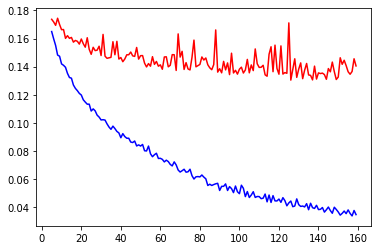

In [ ]:
s= 5
f = 159
loss = hisn.history['loss']
loss=loss[s:f+1]
val_loss = hisn.history['val_loss']
val_loss=val_loss[s:f+1]
plt.plot (np.arange (s, f+1), loss, 'b' )
plt.plot (np.arange (s, f+1), val_loss, 'r')
plt.show()

In [ ]:
np.argmin (hisn.history['val_loss'])

126

Mean_AE:  2.571487043786237
Median_AE:  1.6000000000000014
R2:  0.7270800018677682
Mean_AE:  2.571487043786237
Median_AE:  1.6000000000000014
R2:  0.7270800018677682


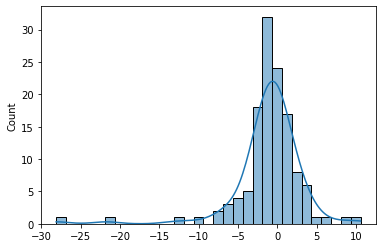

In [ ]:
reg_scorer (kmn , y_ts, X_ts, qt)[0]
sns.histplot (reg_scorer (kmn , y_ts, X_ts, qt)[1] , kde = True )

In [ ]:
res1['keras_normed'] = reg_scorer ( kmn, y_ts, X_ts, qt)[0]

Mean_AE:  2.571487043786237
Median_AE:  1.6000000000000014
R2:  0.7270800018677682


In [ ]:
fin_res = pd.DataFrame.from_dict (res1 , orient='index' , columns = ['MAE', 'MedAE' , 'R2']) # keras дает чуть хуже результаты по AE но лучще R2 возможно из-за того, что таргет не нормализован
fin_res

,MAE,MedAE,R2
base,3.823850,2.939708,0.632763
base_norm,4.709176,3.300000,0.342792
huber,2.816531,1.700000,0.744485
lasso_a_0.05,3.470434,2.200000,0.591627
poly,2.629764,1.642247,0.745199
poly_huber,2.539419,1.600000,0.781611
huber_opt_a7,2.644359,1.600000,0.762361
theil,2.621156,1.600000,0.751107
LarsCV(),4.709176,3.300000,0.342792
BayesianRidge(),4.520435,2.800000,0.386506


In [ ]:
# нормализация таргета улучшила работу модели, и теперь keras_normed лучшая модель, попробуем калифорнию keras


In [ ]:
plt.hist (df['MedHouseVal'], bins = 100)

In [ ]:
df['label'] = [1 if x>4.99 else 0 for x in  df['MedHouseVal'] ]

In [ ]:
df

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split (df.iloc [:, :-2]  ,  df.iloc [:, -2:-1] , stratify=df.iloc [:, -1])
Sc= preprocessing.StandardScaler ()
X_tr = Sc.fit_transform (X_train)
X_ts = Sc.transform (X_test)
qt = preprocessing.QuantileTransformer ( output_distribution='normal')
y_tr = qt.fit_transform (y_train )
y_ts = qt.transform (y_test)

In [ ]:
kmn1 = models.Sequential ()
kmn1.add ( layers.Dense (64 , activation='relu'))
kmn1.add ( layers.Dense (64 , activation='relu'))
kmn1.add ( layers.Dense (1))
kmn1.compile ( loss = 'huber' , metrics='mae' )

In [ ]:
hisn1=kmn1.fit (x= X_tr, y=y_tr,  validation_data=(X_ts, y_ts),  epochs=200, verbose=0)

In [ ]:
kmn1.

In [ ]:
s= 5
f = 199
loss = hisn1.history['loss']
loss=loss[s:f+1]
val_loss = hisn1.history['val_loss']
val_loss=val_loss[s:f+1]
plt.plot (np.arange (s, f+1), loss, 'b' )
plt.plot (np.arange (s, f+1), val_loss, 'r')
plt.show()
np.argmin (hisn1.history['val_loss'])

In [ ]:
np.argmin (val_loss)

In [ ]:
reg_scorer (kmn1 , y_ts, X_ts, qt)[0]
sns.histplot (reg_scorer (kmn1 , y_ts, X_ts, qt)[1] , kde = True )

In [ ]:
	          m8	Huber	    base
MAE 	0.451089	0.448845	0.531797
MDAE	0.284957	0.302304	0.421211
R2	  0.651634	0.665666	0.603995

In [ ]:
reg_scorer (kmn1 , y_ts, X_ts, qt)[1].mean() , reg_scorer (kmn1 , y_ts, X_ts, qt)[1].std() # нейросеть и тут лучшие результаты показала

### калифорния

In [ ]:
data = datasets.fetch_california_housing(as_frame=True)
df=data.get('frame')

In [ ]:
def reg_scorer (model , y_test,  X_test, *args):
  if len (args) == 0 :
    y_pred = model.predict (X_test ).ravel()
  else :
    y_pred = args[0].inverse_transform (model.predict (X_test ) ).ravel()
    y_test = args[0].inverse_transform (y_test).ravel()
  print ('Mean_AE: ', metrics.mean_absolute_error (y_test, y_pred))
  print ('Median_AE: ',metrics.median_absolute_error (y_test, y_pred))
  print ('R2: ', metrics.r2_score ( y_test, y_pred) )
  return [np.sqrt (metrics.mean_squared_error (y_test, y_pred)), metrics.mean_absolute_error (y_test, y_pred), metrics.median_absolute_error (y_test, y_pred), metrics.r2_score ( y_test, y_pred) ] , y_test - y_pred

#### EDA

##### Общий взгляд на признаки

In [ ]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [ ]:
data.get('feature_names')

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
#sns.pairplot (df)

In [ ]:
#g = sns.PairGrid ( vars= ['MedInc', 'HouseAge',  'Population', 'MedHouseVal'], data = df)
#g.map(sns.scatterplot)

(array([   5.,    4.,    5.,    9.,   13.,   48.,   90.,  165.,  274.,
         264.,  323.,  353.,  258.,  288.,  406.,  397.,  482.,  399.,
         337.,  369.,  453.,  359.,  360.,  355.,  351.,  485.,  428.,
         387.,  419.,  502.,  563.,  397.,  442.,  344.,  407.,  410.,
         403.,  300.,  252.,  253.,  303.,  317.,  303.,  358.,  310.,
         268.,  272.,  236.,  227.,  205.,  205.,  234.,  223.,  240.,
         173.,  158.,  167.,  153.,  112.,  104.,   99.,  125.,  105.,
         127.,  111.,  134.,  118.,  134.,  107.,  179.,   91.,  102.,
          94.,   66.,   82.,   67.,   65.,   52.,   69.,   64.,   48.,
          56.,   47.,   52.,   41.,   39.,   50.,   40.,   44.,   62.,
          33.,   33.,   22.,   27.,   29.,   22.,   30.,   17.,   19.,
        1011.]),
 array([0.14999  , 0.1984902, 0.2469904, 0.2954906, 0.3439908, 0.392491 ,
        0.4409912, 0.4894914, 0.5379916, 0.5864918, 0.634992 , 0.6834922,
        0.7319924, 0.7804926, 0.8289928, 0.877493 , 0.

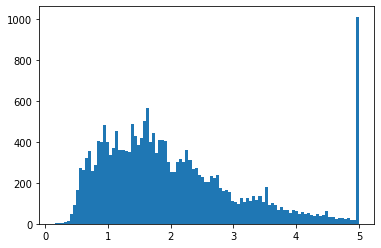

In [ ]:
plt.hist(df['MedHouseVal'], bins = 100)

In [ ]:
df_pr = df[df['MedHouseVal']>4.99].sort_values('MedHouseVal')
df_pr

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
10652,6.7861,28.0,7.386861,1.083942,617.0,2.251825,33.55,-117.77,4.99100
15754,3.0409,52.0,3.745299,1.071795,1100.0,1.880342,37.77,-122.45,5.00000
15753,4.1417,52.0,4.864407,1.078390,1039.0,2.201271,37.77,-122.45,5.00000
15311,1.9891,26.0,4.606704,1.279330,1703.0,1.902793,33.19,-117.38,5.00000
14405,4.3403,38.0,5.068000,1.360000,442.0,1.768000,32.77,-117.28,5.00000
...,...,...,...,...,...,...,...,...,...
8639,6.8220,41.0,4.982353,1.017647,344.0,2.023529,33.87,-118.43,5.00001
8642,7.1264,34.0,4.261905,1.035714,162.0,1.928571,33.86,-118.43,5.00001
8645,5.2319,38.0,6.117347,1.099490,911.0,2.323980,33.87,-118.40,5.00001
8648,5.3816,45.0,4.630573,1.072187,965.0,2.048832,33.87,-118.40,5.00001


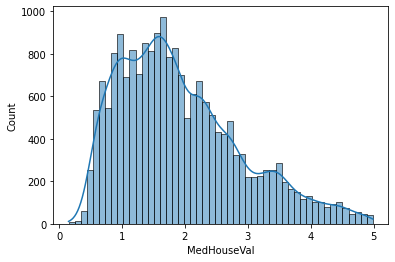

In [ ]:
df_com = df[df['MedHouseVal']<=4.99]
sns.histplot( df_com['MedHouseVal'], kde=True)

##### Расстояние между объектами

In [ ]:
cl= cluster.KMeans ( 2  )
cl.fit(df.iloc[:, :-2],)

KMeans(n_clusters=2)

In [ ]:
cl.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
df['cluster'] = cl.labels_

In [ ]:
len(df[df['MedHouseVal']>4.9][df['cluster']==1]) / len(df[df['MedHouseVal']>4.9])

0.06401551891367604

In [ ]:
len(df[df['MedHouseVal']<=4.9][df['cluster']==1]) / len(df[df['MedHouseVal']<=4.9])

0.11739507369065225

In [ ]:
df_com['MedHouseVal'].describe()

count    19647.000000
mean         1.920397
std          0.970886
min          0.149990
25%          1.164500
50%          1.736000
75%          2.479000
max          4.990000
Name: MedHouseVal, dtype: float64

In [ ]:
train_com = pd.DataFrame (preprocessing.StandardScaler ().fit_transform (df_com), columns=df.columns.to_list()).iloc[:, :-1]
train_pr = pd.DataFrame (preprocessing.StandardScaler ().fit_transform (df_pr), columns=df.columns.to_list()).iloc[:, :-1]

In [ ]:
cos_dist = np.zeros ((len(train_pr), len(train_com)), dtype=float )

NameError: ignored

In [ ]:
cos_dist = np.zeros ((1,3)), dtype=float )

In [ ]:
# попробуем посмотреть косинусную метрику объектов df  и df_pr если будут пары объектов с минимальной метрикой, значит в датасете нет признака разделяющего выборку
# sc.spatial.distance.cosine (df_pr.iloc[1, :-1] , df_pr.iloc[1, :-1] )
for i in range tqdm.tqdm ((len(train_com)), ):
    for ix in range (len(train_pr)):
         d = sc.spatial.distance.cosine (train_com.loc[i], train_pr.loc[ix] )
         cos_dist = np.vstack ( cos_dist, np.array([d, i, ix]))


In [ ]:
for i in tqdm.tqdm ( range (len(train_pr)), ):

        s= train_pr.loc[i]
        l = np.array ([sc.spatial.distance.cosine (s, x) for i, x in train_com.iterrows()])
        cos_dist[i] = l


In [ ]:
cs = pd.DataFrame (cos_dist)
cs

In [ ]:
cs<0.01

In [ ]:
cs[cs<0.01].dropna(how="all" ).dropna(axis=1, how='all')

In [ ]:
sc.spatial.distance.cosine (train_com.loc[19119], train_pr.loc[682] )

In [ ]:
df_pr.iloc[682]

In [ ]:
df_com.iloc[19119]

In [ ]:
cos_dist_pr = np.zeros ( ((len(train_pr),len(train_pr))), dtype=float )

In [ ]:
for i in tqdm.tqdm ( range (len(train_pr)), ):

        s= train_pr.loc[i]
        l = np.array ([sc.spatial.distance.cosine (s, x) for i, x in train_pr.iterrows()])
        cos_dist_pr [i] = l

In [ ]:
cdp = pd.DataFrame (cos_dist_pr)

In [ ]:
cdp[(cdp!=0)&(cdp<0.01)].dropna(how="all" ).dropna(axis=1, how='all')

In [ ]:
cdp!=0.002

косинусная мера не очень хорошо отражает разницу объектов, как видно, попробуем евклидову норму

In [ ]:
print (sc.spatial.distance.euclidean (np.array(train_com.loc[19119]), np.array (train_pr.loc[682])))
print (sc.spatial.distance.euclidean (train_com.loc[19119], ts))


In [ ]:
np.array(train_com.loc[19119])

In [ ]:
ts = np.array ([-0.8, -0.18978531, 13.82384669, 13.46621583, -0.89629073,  -0.08417412,  1.1804669 , -0.23309866])

In [ ]:
euc_dist = np.zeros ( (len(train_pr),len(train_com)), dtype=float )

In [ ]:
for i in tqdm.tqdm ( range (len(train_pr)), ):

        s= train_pr.loc[i]
        l = np.array ([sc.spatial.distance.euclidean (s, x) for i, x in train_com.iterrows()])
        euc_dist[i] = l

In [ ]:
e_d = pd.DataFrame (euc_dist)

In [ ]:
e_d[e_d<0.5].dropna(how="all" ).dropna(axis=1, how='all')

In [ ]:
sc.spatial.distance.euclidean (train_com.loc[4051], train_pr.loc[608] )

In [ ]:
display (df_com.iloc[6403])
display (df_pr.iloc[509])

In [ ]:
euc_dist_pr = np.zeros ( ((len(train_pr),len(train_pr))), dtype=float )

In [ ]:
for i in tqdm.tqdm ( range (len(train_pr)), ):

        s= train_pr.loc[i]
        l = np.array ([sc.spatial.distance.euclidean (s, x) for i, x in train_pr.iterrows()])
        euc_dist_pr [i] = l

In [ ]:
edp = pd.DataFrame (euc_dist_pr)
edp[(edp!=0)&(edp<0.5)].dropna(how="all" ).dropna(axis=1, how='all')

евклидово чуть получше, но смысл тот же значительная группа объектов из общей выборки (com) имеет малое расстояние с объектами выборки pr, сопоставимое с расстояние между объектами внутри pr, например: 700 из 990 объектов pr отстоят друг от друга в диапазоне 0,001 - 0,05 (по евклидовой метрике) , однако в таком же интервале расстояний от объектов pr находятся почти 5000 объектов из 19 000 выборки com
поэтому, скорее всего, модель будет ошибаться, так как на имеющихся признаках не построить разделение, нужно доп признаки (возможно ремонт, количество и качество встроенной техники/мебели)
в теории можно выставлять значительно большие веса разделяющим признакам (MedInc например), так как расчет расстояний производился с равными весами по всем признакам, чего на практике не бывает, но тогда будет тяжело бороться с переобучением посредством регуляризатора

#### Строим baseline

In [ ]:
# пробуем самый общий метод
pipe = pipeline.make_pipeline (preprocessing.StandardScaler ( ), linear_model.LinearRegression (  ))
X_train, X_test, y_train, y_test = model_selection.train_test_split (df.iloc[:, :-1], df.iloc[:, -1])
pipe.fit ( X_train, y_train)
print ('CVS R2',model_selection.cross_val_score ( pipe, X_train, y_train ).mean())
print ('MAE',metrics.mean_absolute_error (y_test, pipe.predict (X_test)))
print ('R2', metrics.r2_score ( y_test, pipe.predict (X_test) ) )

CVS R2 0.6026644491866182
MAE 0.5293346401623426
R2 0.6000920375146495


In [ ]:
df_com

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


**Baseline** 0.54,  R2 0.57

In [ ]:
# пробуем строить модель на df без премиума
y = df_com.pop ('MedHouseVal')

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split (df_com, y)

In [ ]:
pipe.fit ( X_train, y_train)
print ('CVS R2',model_selection.cross_val_score ( pipe, X_train, y_train ).mean())
print ('MAE',metrics.mean_absolute_error (y_test, pipe.predict (X_test)))
print ('R2', metrics.r2_score ( y_test, pipe.predict (X_test) ) )


CVS R2 0.566362930162028
MAE 0.47391510663558456
R2 0.5839231377747016


In [ ]:
y.describe()

count    19647.000000
mean         1.920397
std          0.970886
min          0.149990
25%          1.164500
50%          1.736000
75%          2.479000
max          4.990000
Name: MedHouseVal, dtype: float64

В целом очень неплохо, ошибка +- 47 000 при std 190 000 и mean 192 000$

#### Пробуем перевести таргет из логнормального в нормальное распределение

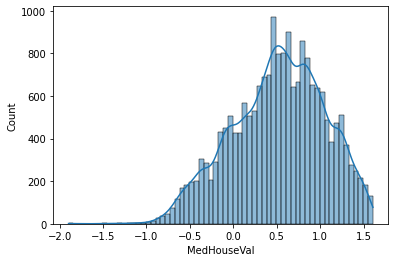

In [ ]:
y_log = np.log (y) # не очень нормальное, но все же попробуем
sns.histplot(y_log, kde=True)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split (df_com, y_log)  # но результат чуть лучше
pipe.fit ( X_train, y_train)
print ('CVS R2',model_selection.cross_val_score ( pipe, X_train,y_train, scoring='r2' ) )
print ('MAE',metrics.mean_absolute_error (np.exp(y_test), np.exp (pipe.predict (X_test))))
print ('R2', metrics.r2_score ( np.exp(y_test), np.exp (pipe.predict (X_test)) ) )

CVS R2 [0.59739833 0.6067235  0.61252343 0.58724395 0.60921005]
MAE 0.4711264022878551
R2 0.5218773010698688


есть улучшение, в scikit learn есть модуль регресии с автотраснформом предикта, можно попробовать другие трансформеры, например QuantileTransformer с переводом в нормальное или uniform распределение

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split (df_com, y)

In [ ]:
mt1 = compose.TransformedTargetRegressor (regressor = pipe, func=np.log, inverse_func=np.exp ) # сначала повторяем трюк с логарифмированием таргета, и видим что да, то же самое, но проще, не надо руками переводить метрики
mt1.fit (X_train, y_train)
print ('CVS R2',model_selection.cross_val_score ( mt1, X_train, y_train , scoring = 'r2') )
print ('MAE',metrics.mean_absolute_error (y_test , mt1.predict (X_test)))
print ('R2', metrics.r2_score ( y_test, mt1.predict (X_test) ) )

CVS R2 [ 0.43352068  0.51343588  0.53301393  0.37697692 -7.53646403]
MAE 0.4607214707247045
R2 0.5345997905876813


In [ ]:
# поскольку в дальнейших планах строить множество моделей на одних и тех же данных, лучше не переписывать каждый раз pipeline, а сразу трансформировать датафреймы, либо прогонять через Column Transformer
X_com = preprocessing.StandardScaler ().fit_transform (df_com)
X_pr = preprocessing.StandardScaler ().fit_transform (df_pr)
X_all = preprocessing.StandardScaler ().fit_transform (df)

ct = compose.make_column_transformer ( # универсальный columntransofmer на основе типа данных в колонках, числа  скалирует, строки энкодит
    ( preprocessing.StandardScaler(), compose.make_column_selector(dtype_include=np.number) ),
    (preprocessing.OneHotEncoder(), compose.make_column_selector( dtype_include=object)))

In [ ]:
ct.fit_transform (df_com) - X_com

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
mt = compose.TransformedTargetRegressor (linear_model.LinearRegression() ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') ) # трансформ в нормальное распредление оставил R2 на том же уровне, а вот MAE уменьшилось
X_train, X_test, y_train, y_test = model_selection.train_test_split (X_com, y)
mt.fit (X_train, y_train)
print ('CVS R2',model_selection.cross_val_score ( mt, X_train, y_train, scoring='r2' ))
print ('MAE',metrics.mean_absolute_error (y_test , mt.predict (X_test)))
print ('R2', metrics.r2_score ( y_test, mt.predict (X_test) ) )

CVS R2 [0.58104872 0.59663097 0.56615783 0.62357099 0.57956744]
MAE 0.44801726231376326
R2 0.5799522112008137


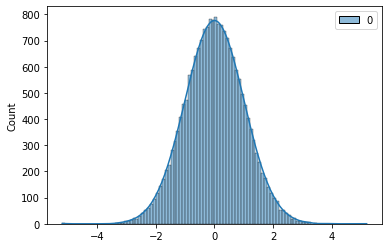

In [ ]:
# нормализация таргета хорошо улучшила результат, ибо com выборка отлично трансформится в нормальное распределение
QN = preprocessing.QuantileTransformer ( output_distribution='normal')
y_norm = QN.fit_transform ( np.array(y).reshape(-1,1))
sns.histplot(y_norm, kde=True)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split (df_com, y_norm) # то же самое, но руками, через  QuantileTransformer
pipe.fit ( X_train, y_train)
print ('CVS R2',model_selection.cross_val_score ( pipe, X_train, y_train ).mean())
print ('MAE', metrics.mean_absolute_error (QN.inverse_transform ( np.array(y_test).reshape(-1,1)) ,  QN.inverse_transform (np.array(pipe.predict (X_test)).reshape(-1,1))  ) )
print ('R2', metrics.r2_score (QN.inverse_transform ( np.array(y_test).reshape(-1,1)) ,  QN.inverse_transform (np.array(pipe.predict (X_test)).reshape(-1,1))  ) )

CVS R2 -0.09359657137091959
MAE 0.45270304562149316
R2 0.5829148247655743


#### Работаем с признаками
посмотрим на то, нет ли коллинеарных признаков мещающих сходимости

In [ ]:
pd.DataFrame (pipe[-1].coef_, columns=df_com.columns.to_list()) # не очень большие веса у признаков AveOccup и Population

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.684358,0.074193,-0.242665,0.283492,0.011794,-0.042155,-0.972013,-0.920934


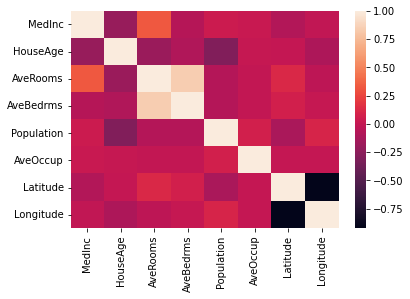

In [ ]:
sns.heatmap (df_com.corr (  )) # широта с долготой и среднее кол-во комнат с кол-вом спален сильно коррелированы, попробуем LASSO

In [ ]:
# для оценки точности прогноза по ценам на недвижку лучше использовать median_absolute_error, она дает оценку по основному датасету, не сбиваясь на выбросы
y_true = [3, 0.5, 2, 12]
y_pred = [3.5, 1, 2.5, 8]
metrics.mean_absolute_error (y_true, y_pred) , metrics.median_absolute_error (y_true, y_pred)

(1.375, 0.5)

In [ ]:
# много раз придется оценивать регрессию, поэтому лучше сразу загнать всю в одну функцию
def reg_scorer (model , y_test,  X_test):
  y_pred = model.predict (X_test )

  print ('Mean_AE: ',metrics.mean_absolute_error (y_test, y_pred))
  print ('Median_AE: ',metrics.median_absolute_error (y_test, y_pred))
  print ('R2: ', metrics.r2_score ( y_test, y_pred) )
  return metrics.mean_absolute_error (y_test, y_pred), metrics.median_absolute_error (y_test, y_pred), metrics.r2_score ( y_test, y_pred)

In [ ]:
mt_lasso = compose.TransformedTargetRegressor (linear_model.Lasso (alpha = 0.05 ),  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )  # ищем альфу, при которой зануляется часть признаков
X_train, X_test, y_train, y_test = model_selection.train_test_split (X_com, y)
mt_lasso.fit (X_train, y_train)
print ('CVS R2',model_selection.cross_val_score ( mt_lasso, X_train, y_train,scoring='r2' ))
reg_scorer (mt_lasso, y_test,  X_test)

CVS R2 [0.52090109 0.49237898 0.49735166 0.4899729  0.49233201]
Mean_AE:  0.49180745457345776
Median_AE:  0.3671255570679482
R2:  0.5091509258509612


In [ ]:
mt_lasso.regressor_.coef_ # при alpha 0.001 получается исходная регрессия, при а = 1 модель зануляет все веса, а при а = 0.05 занулила все признаки налога, возраста и координат

array([ 0.58153448,  0.08477589, -0.        ,  0.        ,  0.        ,
       -0.        , -0.36587622, -0.29878785])

In [ ]:
df_trunc = df_com[['MedInc' , 'HouseAge' , 'Latitude' , 'Longitude']] # обрезаем датасет

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split (ct.fit_transform(df_trunc), y)  # прогоняем через mt видим, что убрав половину признаков мы почти не потеряли в качестве модели
mt.fit ( X_train, y_train)
print ('CVS R2',model_selection.cross_val_score ( mt, X_train, y_train,scoring='r2' ))
reg_scorer (mt, y_test,  X_test)

CVS R2 [0.57849783 0.57392458 0.56317829 0.55565657 0.57601794]
Mean_AE:  0.45348113081357405
Median_AE:  0.3414670728363788
R2:  0.5802936365176858


In [ ]:
# теперь попробуем на этих 4 признаках - полиномы до 10 степени (дальше падает качество)
X_train, X_test, y_train, y_test = model_selection.train_test_split (ct.fit_transform(df_trunc), y)
R2 = []
MAE = []
MDAE = []
for n in range ( 2, 11):
    m = pipeline.make_pipeline ( preprocessing.PolynomialFeatures (n) , mt)
    m.fit ( X_train, y_train)
    mae = metrics.mean_absolute_error (y_test , m.predict (X_test))
    mdae = metrics.median_absolute_error (y_test , m.predict (X_test))
    r2 = metrics.r2_score (y_test , m.predict (X_test))
    #mae = metrics.mean_absolute_error (QN.inverse_transform ( np.array(y_test).reshape(-1,1)) ,  QN.inverse_transform (np.array(m.predict (X_test)).reshape(-1,1))  )
    #r2 = metrics.r2_score (QN.inverse_transform ( np.array(y_test).reshape(-1,1)) ,  QN.inverse_transform (np.array(m.predict (X_test)).reshape(-1,1))  )
    MAE.append (mae)
    MDAE.append (mdae)
    R2.append ( r2)

    print ('poly ', n )
    print ('CVS R2',model_selection.cross_val_score ( m, X_train, y_train, scoring='r2'))
    #print ('MAE', MAE )
    #print ('R2',  R2)


poly  2
CVS R2 [0.60084022 0.62987427 0.59936581 0.57086375 0.57628115]
poly  3
CVS R2 [0.60857495 0.63866418 0.60775479 0.58766559 0.59439988]
poly  4
CVS R2 [0.64328995 0.66854173 0.64306612 0.63135303 0.62903059]
poly  5
CVS R2 [0.6464062  0.67943986 0.65728334 0.64547984 0.64057278]
poly  6
CVS R2 [0.66007085 0.68065498 0.65727534 0.64951196 0.6303281 ]
poly  7
CVS R2 [0.63799061 0.68419905 0.66813443 0.65098727 0.62127913]
poly  8
CVS R2 [0.63747902 0.67917696 0.65393834 0.65406249 0.64038116]
poly  9
CVS R2 [0.63947448 0.64031685 0.62194053 0.61950627 0.6117544 ]
poly  10
CVS R2 [0.59279656 0.59332221 0.60010216 0.58478905 0.57611113]


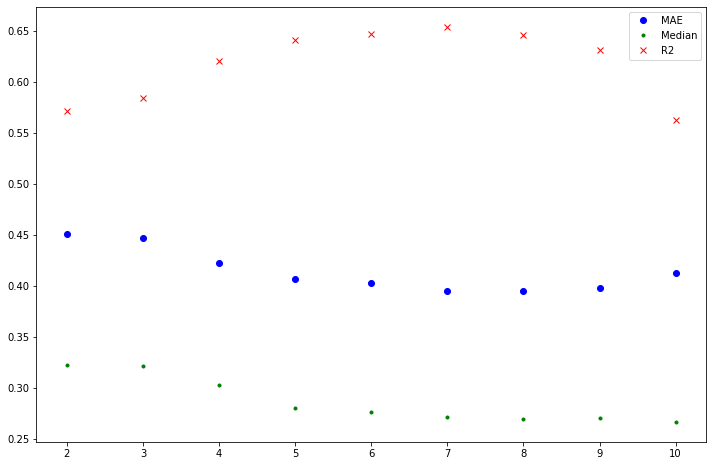

In [ ]:
plt.figure (figsize=(12,8)) # оптимум полином 8 степени
x= np.arange ( 2, 11)
plt.plot (x, MAE, 'ob', label = 'MAE' )
plt.plot (x, MDAE, '.g', label = 'Median'  )
plt.plot (x, R2, 'xr', label = 'R2'  )
plt.legend()


In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split (ct.fit_transform(df_trunc), y)
m8 = pipeline.make_pipeline ( preprocessing.PolynomialFeatures (8) , mt)
m8.fit ( X_train, y_train)
print ('CVS R2',model_selection.cross_val_score ( m8, X_train, y_train,scoring='r2' ))
reg_scorer (m8, y_test,  X_test)

CVS R2 [0.61196201 0.66070209 0.64716287 0.63108237 0.64475663]
Mean_AE:  0.39405282780255435
Median_AE:  0.26636755528373646
R2:  0.6437398750546


In [ ]:
mm = pipeline.make_pipeline ( preprocessing.StandardScaler(),  preprocessing.PolynomialFeatures (8) , mt) # создадим и обучим пайплан и попробуем предсказать pr
X_train, X_test, y_train, y_test = model_selection.train_test_split (df_trunc, y)
mm.fit ( X_train, y_train)
print ('CVS R2',model_selection.cross_val_score ( mm, X_train, y_train,scoring='r2' ))
reg_scorer (mm, y_test,  X_test)

CVS R2 [0.65542585 0.66021462 0.60892371 0.6553462  0.63011459]
Mean_AE:  0.3871618544120316
Median_AE:  0.263
R2:  0.6615784468916428


получили неплохой результат, но надо помнить что это все на выборке com. Попробуем применить модель выборке pr

In [ ]:
df_pr_tr = df_pr[['MedInc' , 'HouseAge' , 'Latitude' , 'Longitude']]
reg_scorer ( mm,  df_pr.iloc[:, -1] , df_pr_tr  )

Mean_AE:  1.3106610562549228
Median_AE:  1.075900235201316
R2:  -35802672.22971843


In [ ]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
mm.predict (df_pr_tr ) # видно что никуда не годится, модель работает хорошо только на общей выборке, вычислим среднюю ошибку по полной выборке

Mean_AE:  0.41778919500402306
Median_AE:  0.2658461155533942
R2:  0.6888399172508587
Mean_AE:  0.4265429231118965
Median_AE:  0.2709375584931444
R2:  0.6795438415727888
Mean_AE:  0.4275730311958682
Median_AE:  0.26381382780347584
R2:  0.6748263749915291
Mean_AE:  0.4261508246240313
Median_AE:  0.2703790657879829
R2:  0.6597637770510895
Mean_AE:  0.4234691473513729
Median_AE:  0.2703790657879829
R2:  0.6790841986826708


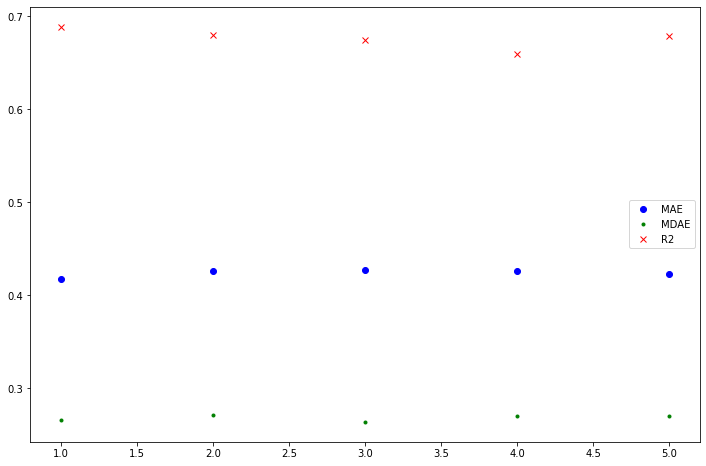

In [ ]:
R2 = []
MAE = []
MDAE = []
df_full_tr = df[['MedInc' , 'HouseAge' , 'Latitude' , 'Longitude']]
y_full = df.iloc[:, -1]
for i in range (5):
    X_train, X_test, y_train, y_test = model_selection.train_test_split ( df_full_tr, y_full)
    reg_scorer (mm, y_test,  X_test )
    mae = metrics.mean_absolute_error ( y_test,  mm.predict (X_test)  )
    mdae = metrics.median_absolute_error ( y_test,  mm.predict (X_test)  )
    r2 = metrics.r2_score ( y_test,  mm.predict (X_test)  )
    MAE.append(mae)
    MDAE.append(mdae)
    R2.append(r2 )
plt.figure (figsize=(12,8))
x= np.arange ( 1, 6)
plt.plot (x, MAE, 'ob', label = 'MAE' )
plt.plot (x, MDAE, '.g', label = 'MDAE' )
plt.plot (x, R2, 'xr', label = 'R2'  )
plt.legend()

In [ ]:
#  обученная com выборке модель дает показатели лучше чем baseline на общей выборке, но это благодрая тому, что она обучена в том числе на тех, данных, которые попали в тест при разбиении на трэйн тест
print( 'MAE', np.array (MAE).mean())
print( "MDAE" , np.array (MDAE).mean())
print( "R2" , np.array (R2).mean())


MAE 0.4243050242574384
MDAE 0.26827112668519604
R2 0.6764116219097874


In [ ]:
# для корректности посмотрим оценку baseline с нормированием таргета
nb = pipeline.make_pipeline (preprocessing.StandardScaler ( ), mt)
X_train, X_test, y_train, y_test = model_selection.train_test_split (df.iloc[:, :-1], df.iloc[:, -1])
nb.fit ( X_train, y_train)
print ('CVS R2', model_selection.cross_val_score ( nb, X_train, y_train, scoring='r2' ))
reg_scorer ( nb, y_test, X_test)

CVS R2 [0.54840212 0.55496892 0.56416672 0.598102   0.56061276]
Mean_AE:  0.5443031389354042
Median_AE:  0.374501567404674
R2:  0.544130086540835


In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split (df.iloc[:, :-1], df.iloc[:, -1])  # R2 оценка обычного baseline лучше, чем нормированного , но MDAE поменьше
print ('CVS R2', model_selection.cross_val_score ( pipe, X_train, y_train, scoring='r2' ).mean())
reg_scorer ( pipe, y_test, X_test)

CVS R2 0.6020440999323988
Mean_AE:  1.9873525237682468
Median_AE:  1.8534436925031341
R2:  -2.3565767630690306


#### Рабочая модель m8
итак создаем рабочую модель:
- разбиваем выборку на трейн, тест
- убираем выбросы
- убираем лишние признаки
- добавляем полином 8 степени
- обучаем на очищенной выборке
- оцениваем по отложенной

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split ( df.iloc[:, :-1], df.iloc[:, -1] )
X_c = X_train.join ( y_train)[X_train.join ( y_train)['MedHouseVal'] <= 4.99]
X_test = X_test [["MedInc" , 	"HouseAge" , "Latitude"	,"Longitude"]]
X_train = X_c[["MedInc" , 	"HouseAge" , "Latitude"	,"Longitude"]]
y_train = X_c.iloc[:, -1]
mt = compose.TransformedTargetRegressor (linear_model.LinearRegression() ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
m8 = pipeline.make_pipeline (preprocessing.StandardScaler(), preprocessing.PolynomialFeatures (8) , mt)
m8.fit ( X_train, y_train)
print ('CVS R2',model_selection.cross_val_score ( m8, X_train, y_train, scoring='r2' ))
reg_scorer (m8, y_test, X_test)[0]

CVS R2 [0.64213053 0.64320993 0.64685953 0.60545568 0.65463978]
Mean_AE:  0.4754538431450385
Median_AE:  0.28723301740350654
R2:  0.5340888876311224


[0.7930169482898266,
 0.4754538431450385,
 0.28723301740350654,
 0.5340888876311224]

In [ ]:
res = dict ([('m8' , reg_scorer (m8, y_test, X_test)[0]  ) ] )

Mean_AE:  0.4754538431450385
Median_AE:  0.28723301740350654
R2:  0.5340888876311224


In [ ]:
# модель дает неплохие результаты, теперь посмотрим, что даст замена на Ridge, Elastic Net и Huber
mt_r = compose.TransformedTargetRegressor (linear_model.RidgeCV ((100, 140, 160) ) ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
mm = pipeline.make_pipeline (preprocessing.StandardScaler(), preprocessing.PolynomialFeatures (8) , mt_r)
mm.fit ( X_train, y_train)
reg_scorer (mm, y_test, X_test)

Mean_AE:  0.4609785058344268
Median_AE:  0.2950629049282475
R2:  0.5932490328819591


In [ ]:
mm[-1].regressor_.alpha_

100

In [ ]:
mt_e = compose.TransformedTargetRegressor (linear_model.ElasticNetCV (l1_ratio=[.01, .1, .25, .5, .75, .9, .95, 1]   ) ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
mm = pipeline.make_pipeline (preprocessing.StandardScaler(), preprocessing.PolynomialFeatures (8) , mt_e)
mm.fit ( X_train, y_train)
reg_scorer (mm, y_test, X_test)

Mean_AE:  0.8688593764486003
Median_AE:  0.6729062359681232
R2:  -0.05770300577289955


In [ ]:
mm[-1].regressor_.alpha_ , mm[-1].regressor_.l1_ratio_ # LASSO на 4 информативных признаках бесполезен, поэтому ENet CV стремится к L2 регуляризации

(39162.556484641726, 0.01)

In [ ]:
mt_e1 = compose.TransformedTargetRegressor (linear_model.ElasticNet (l1_ratio=.0001, alpha=160 ) ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
mm = pipeline.make_pipeline (preprocessing.StandardScaler(), preprocessing.PolynomialFeatures (8) , mt_e1)
mm.fit ( X_train, y_train)
reg_scorer (mm, y_test, X_test)

Mean_AE:  0.6966059376983403
Median_AE:  0.5253664071932984
R2:  0.26556554027982116


In [ ]:
mt_h = compose.TransformedTargetRegressor (linear_model.HuberRegressor (epsilon=1.35, max_iter=100, alpha= 0.0001) ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
mm = pipeline.make_pipeline (preprocessing.StandardScaler(), preprocessing.PolynomialFeatures (8) , mt_h)
mm.fit ( X_train, y_train)
reg_scorer (mm, y_test, X_test)

Mean_AE:  0.7648875725458941
Median_AE:  0.6098032735261365
R2:  0.19332981418400252


In [ ]:
X_train.shape

(14715, 4)

In [ ]:
# по дефолту модель значительно хуже, но здесь есть 2 гиперпараметра, поэтому пробуем GridSearch
# чтобы в GridSearch передать pipeline параметры нужно использовать __

#params = dict ( [("transformedtargetregressor__regressor__epsilon", np.linspace ( 1.1, 1.5, 5) ), ("transformedtargetregressor__regressor__alpha" , np.linspace ( 0.0001, 0.01, 10))]  )
#params = dict ( [("transformedtargetregressor__regressor__alpha", np.linspace ( 0,1, 50) ) ]  )

#grid = model_selection.GridSearchCV (estimator = mm, param_grid=params, scoring="r2" , verbose=4 , return_train_score=True, cv=3)
#grid.fit (X_train, y_train)


In [ ]:
#grid.best_score_ , grid.best_estimator_

In [ ]:
# теперь попробуем Huber Regr на всем датасете, так как она более устойчива к выбросам и не настраивается на них, также сделаем перебор по GridSearch
X_train, X_test, y_train, y_test = model_selection.train_test_split ( df.iloc[:, :-1], df.iloc[:, -1] )
#mm1 = pipeline.make_pipeline (preprocessing.StandardScaler(),  mt_h)
#params = dict ( [("transformedtargetregressor__regressor__epsilon", np.linspace ( 1.01, 1.4, 8) ), ("transformedtargetregressor__regressor__alpha" , np.linspace ( 0.0001, 0.009, 50))]  )
#grid = model_selection.GridSearchCV (estimator = mm1, param_grid=params, scoring="r2" , verbose=4 , return_train_score=True, cv=3)
#grid.fit (X_train, y_train)


In [ ]:
#grid.best_score_ , grid.best_estimator_

In [ ]:
#grid.best_params_

In [ ]:
# у Хубера результат такой же как предикт общей выборки через модель m8, так как она по сути не подстраивается под pr объекты
mt_h = compose.TransformedTargetRegressor (linear_model.HuberRegressor (epsilon=1.17, max_iter=1000, alpha= 0.0001) ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
mm1 = pipeline.make_pipeline (preprocessing.StandardScaler(),  mt_h)
mm1.fit ( X_train, y_train)
print ('CVS R2',model_selection.cross_val_score ( mm1, X_train, y_train, scoring='r2' ))
reg_scorer (mm1, y_test, X_test)[0]

CVS R2 [0.64832457 0.6399282  0.65945753 0.64192432 0.64358482]
Mean_AE:  0.4604525479706304
Median_AE:  0.3091281116698008
R2:  0.6467681795600082


[0.6873996162697643,
 0.4604525479706304,
 0.3091281116698008,
 0.6467681795600082]

In [ ]:
res ['Huber'] = reg_scorer (mm1, y_test, X_test )[0]

Mean_AE:  0.4604525479706304
Median_AE:  0.3091281116698008
R2:  0.6467681795600082


In [ ]:
res ['base'] = reg_scorer (pipe, y_test, X_test )

Mean_AE:  1.9857990021827467
Median_AE:  1.846008347436737
R2:  -2.400153630464622


In [ ]:
pipe.fit (X_train, y_train)
res ['base'] = reg_scorer (pipe, y_test, X_test )

Mean_AE:  0.5317974116061404
Median_AE:  0.4212111006117153
R2:  0.6039949187425147


In [ ]:
pd.DataFrame (res, index = ['RMSE','MAE' , 'MedianAE' , 'R2'] )

,m8,Huber
RMSE,0.793017,0.687400
MAE,0.475454,0.460453
MedianAE,0.287233,0.309128
R2,0.534089,0.646768


In [ ]:
# попробуем проверить качество предсказаний всех трех моделей на df_pr
reg_scorer (m8, df_pr.iloc[:,-1], df_pr.iloc[:,[0,1,-3,-2]])

Mean_AE:  1.5334440639690023
Median_AE:  1.3775292542590791
R2:  -47147349.9882995


(1.5334440639690023, 1.3775292542590791, -47147349.9882995)

In [ ]:
reg_scorer (mm1, df_pr.iloc[:,-1], df_pr.iloc[:, : -1])

Mean_AE:  0.8388831967236954
Median_AE:  0.0
R2:  -24148827.216343515


(0.8388831967236954, 0.0, -24148827.216343515)

In [ ]:
reg_scorer (pipe, df_pr.iloc[:,-1], df_pr.iloc[:, : -1])

Mean_AE:  1.4334577669204651
Median_AE:  1.3915504846915878
R2:  -34937371.85166948


(1.4334577669204651, 1.3915504846915878, -34937371.85166948)

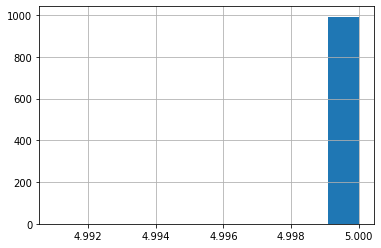

In [ ]:
df_pr.iloc[:,-1].hist()

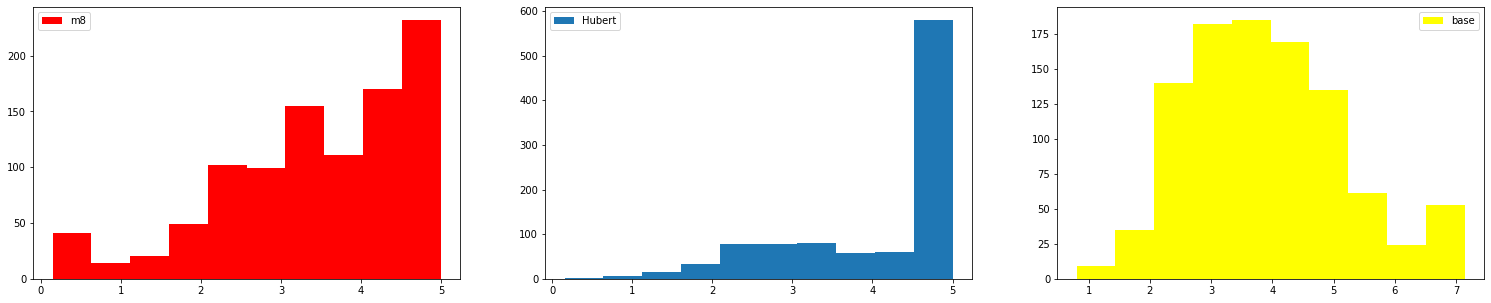

In [ ]:
fig, ax = plt. subplots  (1 ,3 , figsize = (26,5) ) # Hubert гораздо лучше предсказывает метки на выбросах
ax[0].hist (m8.predict (df_pr.iloc[:,[0,1,-3,-2]] ),  color='red' ,  label = 'm8')
ax[0].legend()
ax[1].hist (mm1.predict (df_pr.iloc[:,:-1] )  , label = 'Hubert')
ax[1].legend()
ax[2].hist (pipe.predict (df_pr.iloc[:,:-1] ) ,color='yellow'  , label = 'base')
ax[2].legend()



#### теперь попробуем этот же подход на бостонской недвижке

## Линейные классификаторы на примере MNIST и CovType

### датасет MNIST

In [ ]:
data = datasets.load_digits (as_frame=True)
df=data.get('frame')

In [ ]:
df

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,9
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,9


In [ ]:
print (df.iloc[:, -1].value_counts( ))

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: target, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split (df.iloc[:, :-1] , df.iloc[:, -1], stratify=df.iloc[:, -1]) # разбиваем на трейн / тест

In [ ]:
Sc = preprocessing.StandardScaler() # скалируем
X_train.iloc[:, :10] = Sc.fit_transform (X_train.iloc[:, :10])
X_test.iloc[:, :10] = Sc.transform ( X_test.iloc[:, :10])

### датасет CovType (типы ландшафта в парке по геодезическим признакам

In [ ]:
data = datasets.fetch_covtype (as_frame=True)
df=data.get('frame')

In [ ]:
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64


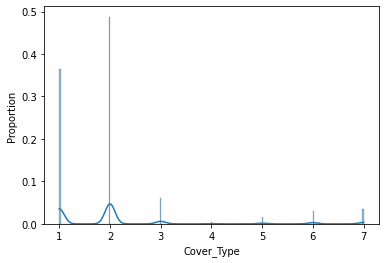

In [ ]:
print (df.iloc[:, -1].value_counts( ))
sns.histplot (df.iloc[:, -1] , kde = True, stat='proportion' ) # классы сильно дисбалансированы

In [ ]:
# фуллсет огромен, результаты по всему датасету работы Lin Reg keras и xgboost внизу
X_,out, y_, out_y = model_selection.train_test_split (df.iloc[:, :-1] , df.iloc[:, -1], stratify=df.iloc[:, -1] , train_size=0.2) # данных много, отрезаем только 30 % , но с охраненеим баланса классов
X, hold, y, hold_y = model_selection.train_test_split (X_ , y_, stratify=y_ , train_size=0.8) # выделяем hold
X_train, X_test, y_train, y_test = model_selection.train_test_split (X , y, stratify=y , train_size=0.8) # остаток разбиваем на трейн / тест

In [ ]:
Sc = preprocessing.StandardScaler() # скалируем сразу трансформим и тест и холд
X_train.iloc[:, :10] = Sc.fit_transform (X_train.iloc[:, :10])
X_test.iloc[:, :10] = Sc.transform ( X_test.iloc[:, :10])
hold.iloc[:, :10]  = Sc.transform ( hold.iloc[:, :10])

### Классификаторы SciKit

0.37638680246883127
              precision    recall  f1-score   support

           1       0.36      0.36      0.36      6779
           2       0.49      0.49      0.49      9066
           3       0.06      0.06      0.06      1144
           4       0.00      0.00      0.00        88
           5       0.01      0.01      0.01       304
           6       0.03      0.03      0.03       556
           7       0.01      0.02      0.01       656

    accuracy                           0.38     18593
   macro avg       0.14      0.14      0.14     18593
weighted avg       0.38      0.38      0.38     18593



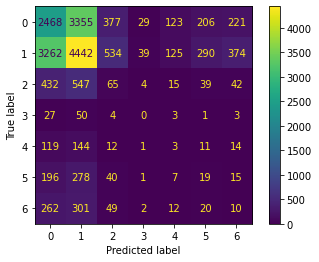

In [ ]:
#baseline dummy classifier
bs1 = dummy.DummyClassifier ( strategy = 'stratified') #
bs1.fit ( X_train, y_train)
y_pred = bs1.predict (X_test )
print (metrics.f1_score (y_test, y_pred,  average='weighted') ) # классы несбалансированы, можно выбрать взвешенный f1
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred )   )
cm.plot();

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed:  2.4min finished


              precision    recall  f1-score   support

           1       0.71      0.70      0.71      6779
           2       0.75      0.80      0.78      9066
           3       0.67      0.78      0.72      1144
           4       0.60      0.41      0.49        88
           5       0.18      0.01      0.02       304
           6       0.45      0.26      0.33       556
           7       0.73      0.56      0.63       656

    accuracy                           0.72     18593
   macro avg       0.59      0.50      0.53     18593
weighted avg       0.71      0.72      0.71     18593



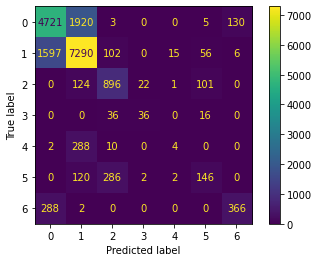

In [ ]:
# в качестве второго baseline используем лог-рес со встроенным CV, поставим широкий диапазон для выбора штрафа и метрику f1_macro
bs2 = linear_model.LogisticRegressionCV (Cs=np.linspace (1000, 10000 , 10)  , max_iter=500, scoring='f1_macro' , cv=3, n_jobs=5, verbose=3 )
bs2.fit ( X_train, y_train)
y_pred = bs2.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) )   )
cm.plot();
Audio ( sound_file, autoplay=True)

In [ ]:
np.max(bs2.coef_) , bs2.intercept_ ,  bs2.C_ # видно, что модель не переобучилась, также из-за дисбаланса классов, лучше использовать метрику f1 macro, чтобы было видно улучшение на всех классах, а не только на 1,2

(7.388738937365835,
 array([ 4.73155778,  6.57373938, -2.63013975, -6.84005678, -0.58728703,
        -1.45061284,  0.20279923]),
 array([2000., 2000., 2000., 2000., 2000., 2000., 2000.]))

In [ ]:
fd = pd.DataFrame (np.transpose (bs2.coef_)  , index =X_train.columns.to_list() , columns =np.arange (1,8) )
fd1 = fd.rename_axis('features' ).reset_index()


In [ ]:
# создание переменных в цикле
for i  in range (1, 8) :
  mask = (fd1[i]>2.5) | (fd1[i]<-2.5)
  exec(f'tdf_{i} = fd1[mask]')


<BarContainer object of 5 artists>

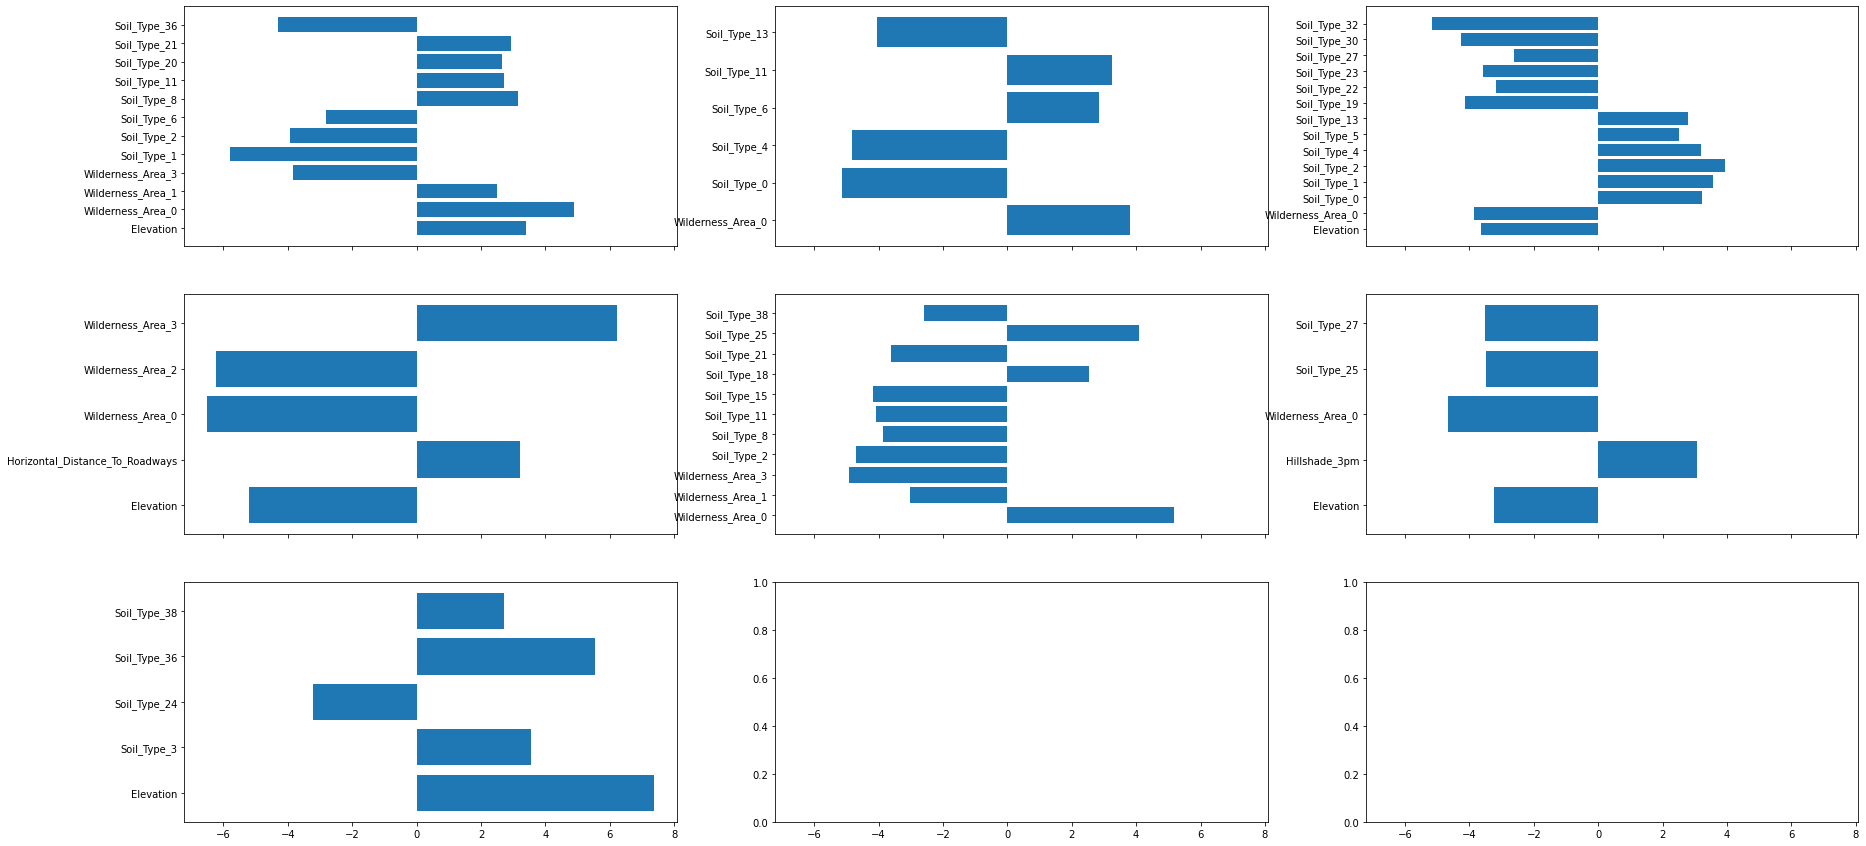

In [ ]:
fig, ax = plt.subplots ( 3,3, sharex=True,  figsize = (30,15))
ax[0,0].barh (y = tdf_1['features']  , width= tdf_1[1])
ax[0,1].barh (y = tdf_2['features']  , width= tdf_2[2])
ax[0,2].barh (y = tdf_3['features']  , width= tdf_3[3])
ax[1,0].barh (y = tdf_4['features']  , width= tdf_4[4])
ax[1,1].barh (y = tdf_5['features']  , width= tdf_5[5])
ax[1,2].barh (y = tdf_6['features']  , width= tdf_6[6])
ax[2,0].barh (y = tdf_7['features']  , width= tdf_7[7])
#bs2.coef_

              precision    recall  f1-score   support

           1       0.71      0.70      0.71      6779
           2       0.75      0.80      0.78      9066
           3       0.67      0.78      0.72      1144
           4       0.60      0.41      0.49        88
           5       0.18      0.01      0.02       304
           6       0.45      0.26      0.33       556
           7       0.73      0.56      0.63       656

    accuracy                           0.72     18593
   macro avg       0.59      0.50      0.53     18593
weighted avg       0.71      0.72      0.71     18593



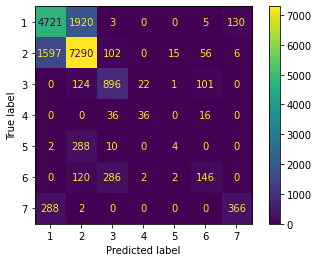

In [ ]:
# пробуем еще раз, меняем метрику и убираем регуляризацию , добавляем итераций, выбираем более быстрый оптимизатор
bs3 = linear_model.LogisticRegression  ( penalty='none' , C=2000 ,  n_jobs=5, max_iter=1000, solver='sag')
bs3.fit ( X_train, y_train)
y_pred = bs3.predict (X_test )
cv_scores  =  model_selection.cross_validate (bs3 , pd.concat ([X_train, X_test], axis=0), y, scoring='f1_macro', cv=5, groups=y , return_train_score=True)
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();
Audio ( sound_file, autoplay=True)

In [ ]:
np.median (cv_scores['test_score'])

0.09392280420204069

              precision    recall  f1-score   support

           1       0.70      0.70      0.70      8474
           2       0.75      0.79      0.77     11332
           3       0.69      0.81      0.74      1430
           4       0.61      0.40      0.48       110
           5       0.38      0.03      0.05       380
           6       0.51      0.27      0.35       695
           7       0.74      0.53      0.62       820

    accuracy                           0.72     23241
   macro avg       0.63      0.51      0.53     23241
weighted avg       0.71      0.72      0.71     23241



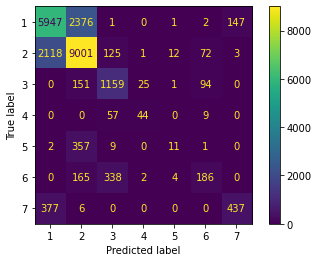

In [ ]:
y_predh = bs3.predict (hold )
print (metrics.classification_report (hold_y, y_predh ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_predh , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();
Audio ( sound_file, autoplay=True)

In [ ]:
np.max(bs2.coef_) , bs2.intercept_ # признаков переобучения по-прежнему нет, но добавление итераций еще более увеличит время выполнения

(7.388738937365835,
 array([ 4.73155778,  6.57373938, -2.63013975, -6.84005678, -0.58728703,
        -1.45061284,  0.20279923]))

In [ ]:
model_selection.cross_validate (linear_model.PassiveAggressiveClassifier (max_iter=10000000 , C=0.03, n_jobs=5 , tol=tol ) , X_train,  y_train, scoring='f1_macro', cv=5, groups=y_train , return_train_score=True)

{'fit_time': array([1.86979938, 1.58152246, 1.95506907, 1.88434196, 1.58474302]),
 'score_time': array([0.01743507, 0.03527617, 0.01819468, 0.01810527, 0.02421904]),
 'test_score': array([0.46539037, 0.41784427, 0.47094848, 0.47926612, 0.49073564]),
 'train_score': array([0.50469572, 0.42862676, 0.4603219 , 0.48674883, 0.47238078])}

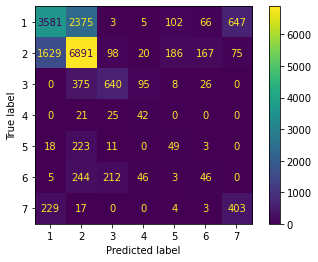

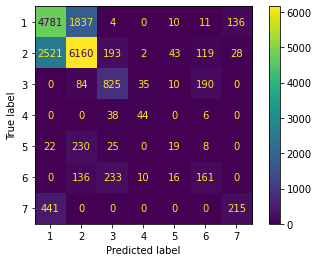

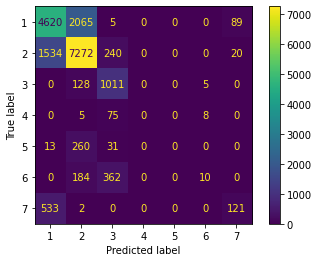

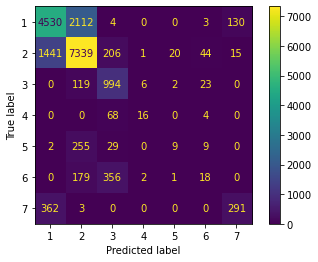

In [ ]:
# пробуем весь набор линейных классификаторов с минимальной регуляризацией и количеством итераций 1000,  метрику возьмем f1 macro, везде проводим кросс-вал с 10 фолдам, записываем медианное значение f1 macro
cm_list =[]
res_lcl = {}
max_iter = 100000000
tol = 0.000001
lcl = [linear_model.PassiveAggressiveClassifier (max_iter=max_iter , C=1, n_jobs=5 , tol=tol ) , linear_model.Perceptron( max_iter=max_iter, n_jobs=5, tol=tol),
       linear_model.RidgeClassifier ( alpha=0.0001, max_iter=max_iter, tol=tol ),    linear_model.SGDClassifier (penalty='l1' , max_iter=max_iter, n_jobs=5, tol=tol ) ]
for cl in lcl :
  m = cl.fit ( X_train, y_train)
  cv= model_selection.cross_validate (cl ,X_train, y_train, scoring='f1_macro', cv=5, groups=y_train , return_train_score=True)
  y_pred = m.predict (X_test )
  f1_test = metrics.f1_score (y_test, y_pred,  average='macro')
  train_score = np.median (cv['train_score'])
  test_score = np.median (cv['test_score'])
  res_lcl[str(cl )] = [train_score, test_score,  f1_test]
  cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8)) , display_labels=np.arange (1, 8)   )
  cm.plot();
  cm_list.append (metrics.confusion_matrix (y_test, y_pred ) )
Audio ( sound_file, autoplay=True)


In [ ]:
pd.DataFrame.from_dict ( res_lcl , orient='index' , columns = [ 'train_score', 'test_score' , 'F1_test']) # даже на итерациях 100 000 000 альтернатива работает значительно быстрее, но хуже

,train_score,test_score,F1_test
"PassiveAggressiveClassifier(C=1, max_iter=100000000, n_jobs=5, tol=1e-06)",0.405644,0.400406,0.413483
"Perceptron(max_iter=100000000, n_jobs=5, tol=1e-06)",0.407690,0.402768,0.477014
"RidgeClassifier(alpha=0.0001, max_iter=100000000, tol=1e-06)",0.357760,0.354742,0.352059
"SGDClassifier(max_iter=100000000, n_jobs=5, penalty='l1', tol=1e-06)",0.467293,0.462020,0.442100


Fitting 3 folds for each of 20 candidates, totalling 60 fits
              precision    recall  f1-score   support

           1       0.71      0.70      0.71      6779
           2       0.75      0.80      0.78      9066
           3       0.67      0.78      0.72      1144
           4       0.60      0.41      0.49        88
           5       0.18      0.01      0.02       304
           6       0.45      0.26      0.33       556
           7       0.73      0.56      0.63       656

    accuracy                           0.72     18593
   macro avg       0.59      0.50      0.53     18593
weighted avg       0.71      0.72      0.71     18593



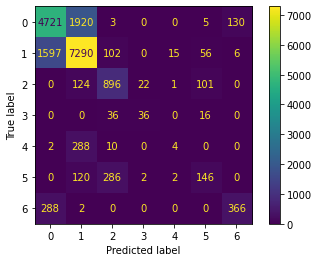

In [ ]:
# похоже, что лог рес лучше всех справляется с задачей, попытаемся провести настройку гиперпараметров
# на первом шаге через GridSearchCV найдем лучшие параметра регуляриазции и solvers
params = {'penalty' :  ['none', 'l1', 'l2' , 'elasticnet']  ,  "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  }
grid = model_selection.GridSearchCV ( linear_model.LogisticRegression (C=2000 , max_iter=1000 , tol=0.001), param_grid=params , scoring='f1_macro', verbose=4 , n_jobs=5 , cv=3)
grid.fit ( X_train, y_train)
y_pred = grid.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8))   )
cm.plot();
Audio ( sound_file, autoplay=True)

In [ ]:
grid.best_params_

{'penalty': 'l2', 'solver': 'newton-cg'}

In [ ]:
# на втором шаге построим кривые обучения по парметру регуляризации и количеству итераций
train_score , val_score = model_selection.validation_curve (linear_model.LogisticRegression ( solver='newton-cg' ,  max_iter=300 , tol=0.0001) , X_train, y_train, param_name = 'C' , groups =y_train ,
                                                            param_range = np.linspace ( 0 , 3000 , 10) , scoring = 'f1_macro', cv=3)
Audio ( sound_file, autoplay=True)

In [ ]:
train_score

In [ ]:
val_score

In [ ]:
Audio ( sound_file, autoplay=True)
plt.figure (figsize=(12,8))
x= np.linspace ( 0 , 3000 , 10)
plt.plot (x,  np.median (train_score, axis=1), '-b', label = 'train' )
plt.plot (x,  np.median (val_score, axis=1), '-r', label = 'test'  )
plt.legend()

In [ ]:
train_score , val_score = model_selection.validation_curve (linear_model.LogisticRegression ( solver='newton-cg' ,  tol=0.001) , X_train, y_train, param_name = 'max_iter' , groups =y_train ,
                                                            param_range = np.linspace ( 50 , 500 , 5) , scoring = 'f1_macro', cv=1)

In [ ]:
Audio ( sound_file, autoplay=True)
plt.figure (figsize=(12,8))
x= np.linspace ( 50 , 500 , 5)
plt.plot (x,  np.median (train_score, axis=1), '-b', label = 'train' )
plt.plot (x,  np.median (val_score, axis=1), '-r', label = 'test'  )
plt.legend()

              precision    recall  f1-score   support

           1       0.71      0.70      0.71      6779
           2       0.75      0.80      0.78      9066
           3       0.67      0.81      0.73      1144
           4       0.67      0.39      0.49        88
           5       0.29      0.01      0.03       304
           6       0.45      0.25      0.32       556
           7       0.71      0.55      0.62       656

    accuracy                           0.72     18593
   macro avg       0.61      0.50      0.52     18593
weighted avg       0.71      0.72      0.72     18593



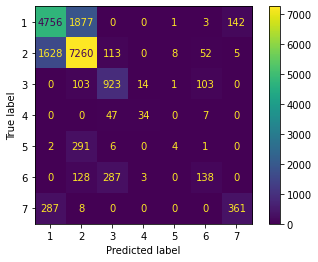

In [ ]:
 #строим фин модель
lr = linear_model.LogisticRegression  ( C=1000 ,  n_jobs=5, max_iter=500, solver='newton-cg')
lr.fit ( X_train, y_train)
y_pred = lr.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();
Audio ( sound_file, autoplay=True)

              precision    recall  f1-score   support

           1       0.71      0.70      0.71      8474
           2       0.75      0.81      0.78     11332
           3       0.68      0.81      0.74      1430
           4       0.64      0.39      0.49       110
           5       0.27      0.02      0.03       380
           6       0.44      0.24      0.31       695
           7       0.71      0.53      0.61       820

    accuracy                           0.72     23241
   macro avg       0.60      0.50      0.52     23241
weighted avg       0.71      0.72      0.71     23241



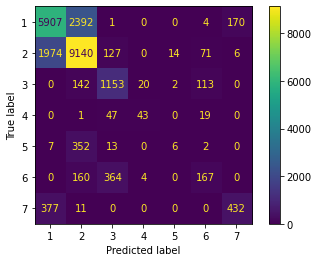

In [ ]:
# проверяем все на отложенной выборке
y_pred_h = lr.predict (hold ) # лог рес
print (metrics.classification_report (hold_y, y_pred_h ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_pred_h , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

In [ ]:
# очевидно, что зависимости не линейны и линейные классификаторы даже после настройки плохо справляются с задачей, можно было бы попробовать выделить важные признаки по каждому классу и применить поли,
# но это вычислительно дорого, поэтому попробуем нелинейные модели
# ВАЖНО! нелинейные модели склонны сильно подстраиваться под обучающую выборку, рисуя сложнейшие разделительные границы, но потом плохо работают на новых данных, линейные модели (даже с нелинейными признаками как поли)
# пытаются найти именно обобщенное решение: разделительную линию, круг, эллипс, так что возиться с линейными моделями путем встраивания нелинейных признаков имеет смысл, особенно если имеем картину с плохой работой на новых данных
# При этом у нелинейных классификаторов есть параметры для регуляризации и сглаживания разделющих плоскостей, их настройкой можно добиться повышения эффективности

# Нелинейные модели

## Деревья, ансамбли, бустинги


In [ ]:
# Деревья не используют Loss и градиентный спуск, признаки скалировать не обязательно

Деревья решений строятся по простейшему приниципу: каждая вершина разбивается на 2 по пороговому значению какого-то одного признака, затем каждая вершина еще на 2 и так до тех пор пока в вершине не окажутся только
элементы одного класса, либо элементы с нулевой дисперсией (вершина без дальнейшего разбиения - лист) , соответственно если не ограничивать глубину дерева или мин кол-во элементов в листьях, то дерево построит разбиение практически вплоть до каждого элемента выборки
На каждом шаге разбиения перебираются все признаки и все возможные пороги разбиения (к примеру берем признак "Elevation", берем все его уникальные значения и пробуем их в качестве порого, потом следующий признак и т.д.)
Выбирается признак и порог, который на данном шаге дает лучшее разбиение, это оценивается через критерии информативности для классификации:
 * Энтропия: $ -Σ  p^i* log_2p^i$ , по всем k (классам)
 * Gini: $ Σ  p^i*(1-p^i)$ по всем (классам)  
То есть на каждом варианте разбиения вершины по признаку/порогу у нас все образцы в вершине разбиваются на 2 группы (в корне дерева разбивается весь трейн сет, далее только те которые остались в в этой вершине). Далее, мы получаем вектор таргетов сначала по левой вершине, потом по правой, по каждому считаем Джини/энтропию, выбираем меньшее.  
 Пример: вектор таргетов левого дерева [1,2,3,4], вектор ответов правого [1,1,1, 2,3], получается слева (0.25 * 0.75) * 4 = 0.75
 справа: 3/5 =0.6 => 0.6 * 0.4 + 0.2 * 0.8 + 0.2 * 0.8 = 0.56  
 правое разбиение лучше левого (интутивно там больше шансов на то, что попадут объекто одного класса (первого)

Для регресии оценивается просто через дисперсию, то есть смотрим вектор таргета левого дерева, считаем дисперсию сравниваем с дисперсией вектора таргета правого дерева, выбираем меньшую

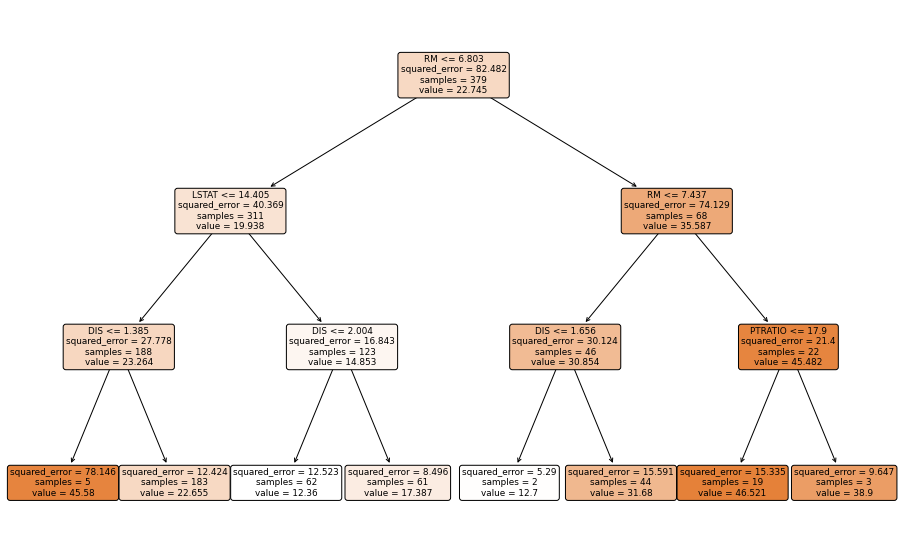

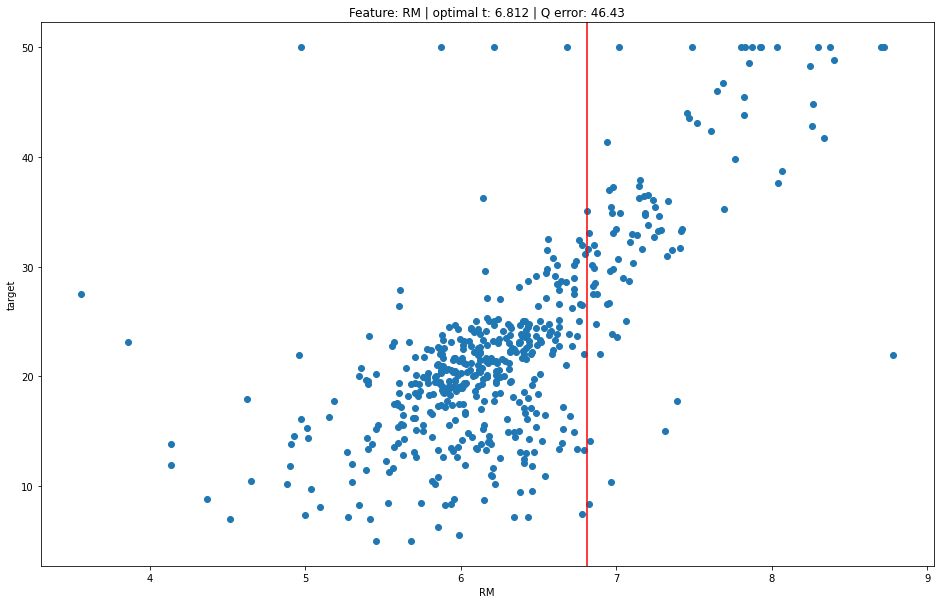

              precision    recall  f1-score   support

           1       0.85      0.85      0.85      6779
           2       0.88      0.88      0.88      9066
           3       0.84      0.83      0.84      1144
           4       0.77      0.74      0.76        88
           5       0.63      0.67      0.65       304
           6       0.69      0.71      0.70       556
           7       0.84      0.85      0.84       656

    accuracy                           0.85     18593
   macro avg       0.79      0.79      0.79     18593
weighted avg       0.85      0.85      0.85     18593



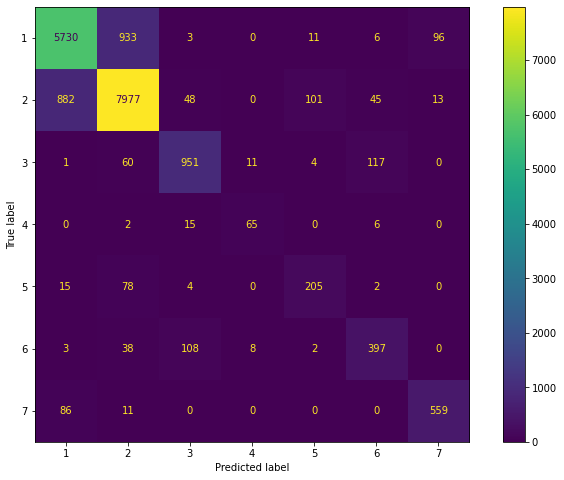

In [ ]:
dtc = tree.DecisionTreeClassifier(   )
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();
plt.rcParams['figure.figsize'] = (12, 8)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27115
           2       1.00      1.00      1.00     36262
           3       1.00      1.00      1.00      4577
           4       1.00      1.00      1.00       351
           5       1.00      1.00      1.00      1215
           6       1.00      1.00      1.00      2222
           7       1.00      1.00      1.00      2626

    accuracy                           1.00     74368
   macro avg       1.00      1.00      1.00     74368
weighted avg       1.00      1.00      1.00     74368



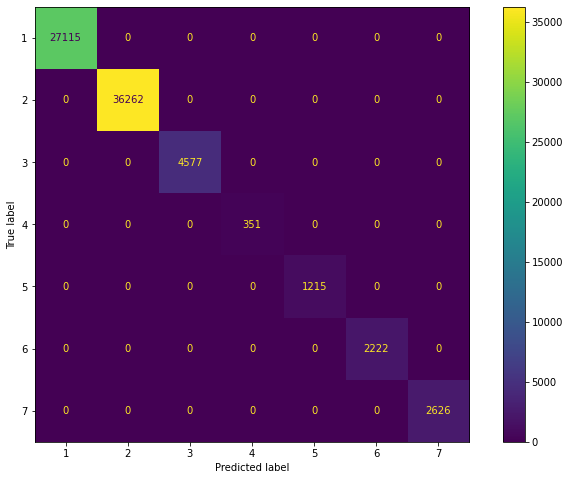

In [ ]:
# Деревья крайне чувствительны к выбросам, они всегда пытаются подстроиться под них, собственно ничем не огранеиченное дерево, всегда полностью подстроиться под трейн сет
# есть методы против этого: ограничение глубины, кол-ва сэмплов в листах, прореживание (прунинг)
# очень рекомендуется (как и для всех моделей впрочем) заранее очистить выборку от явных выбросов: интерквартильный размах, либо обрезка элементов, которые сильно удалены от центра соотвествующего кластера
print (metrics.classification_report (y_train, dtc.predict(X_train) ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_train, dtc.predict(X_train) , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();


              precision    recall  f1-score   support

           1       0.86      0.85      0.85      8474
           2       0.87      0.88      0.88     11332
           3       0.84      0.85      0.85      1430
           4       0.71      0.73      0.72       110
           5       0.57      0.64      0.61       380
           6       0.71      0.68      0.70       695
           7       0.86      0.84      0.85       820

    accuracy                           0.85     23241
   macro avg       0.78      0.78      0.78     23241
weighted avg       0.85      0.85      0.85     23241



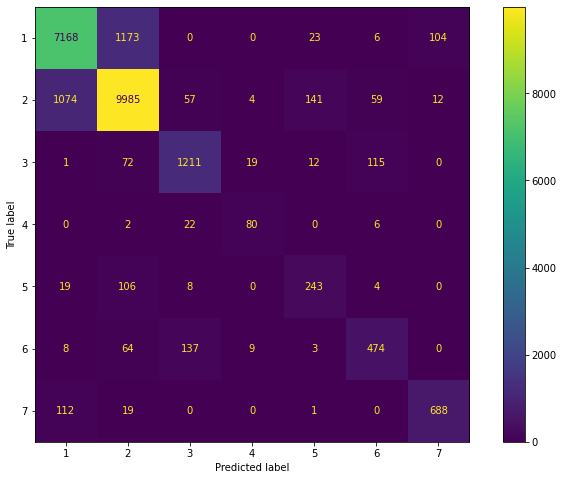

In [ ]:
y_pred_h = dtc.predict (hold )
print (metrics.classification_report (hold_y, y_pred_h ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_pred_h , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

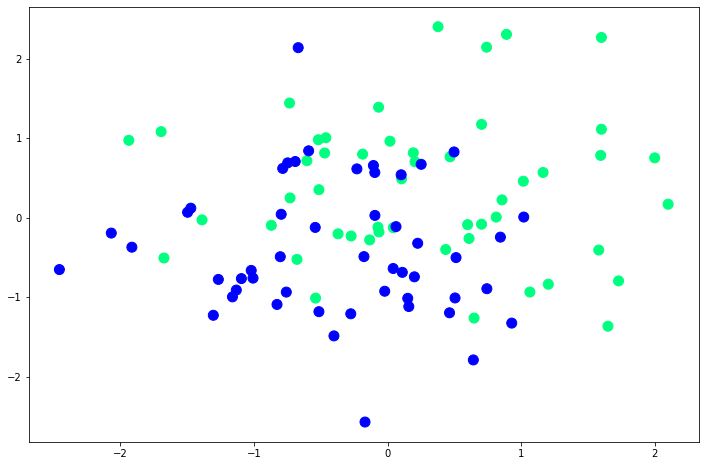

In [ ]:
np.random.seed(13)
n = 100
X = np.random.normal(size=(n, 2))
X[:50, :] += 0.25
X[50:, :] -= 0.25
y = np.array([1] * 50 + [0] * 50)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap='winter')
plt.show()

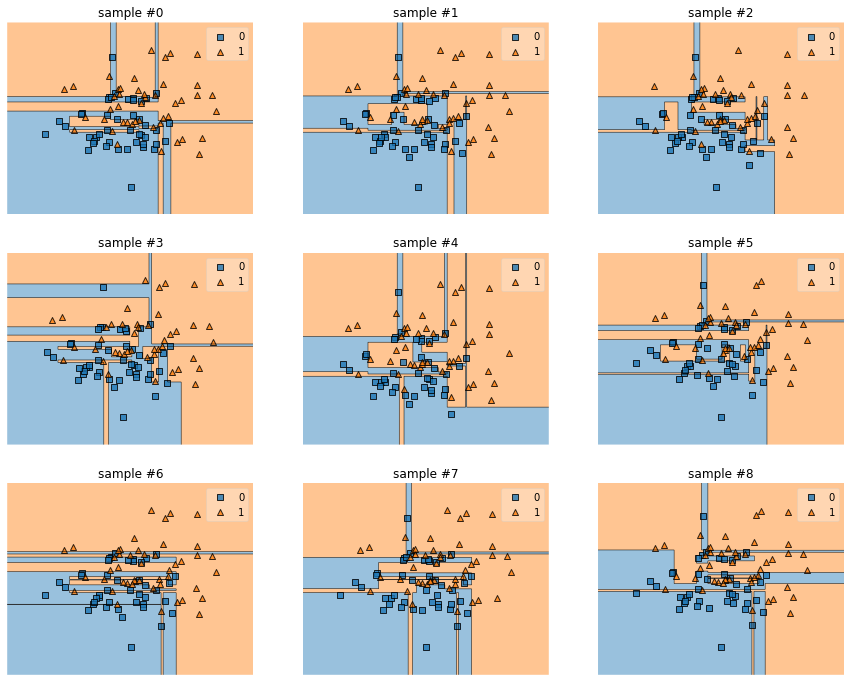

In [ ]:
# но свойство, сильно подстраиваться под обучающий сет, можно использовать во благо. Если сравнивать между собой разделения построенные по разным случайным подвыборкам, можно увидеть, какие объекты постоянно
# присутсвуют в каждой модели, то есть выделить основные паттерны, ядра классов
# На этом строятся слуайные леса
from mlxtend.plotting import plot_decision_regions
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for i in range(3):
    for j in range(3):
        seed_idx = 3 * i + j
        np.random.seed(seed_idx)
        dt = tree.DecisionTreeClassifier()
        idx_part = np.random.choice(len(X), replace=False, size=int(0.9 * len(X)))
        X_part, y_part = X[idx_part, :], y[idx_part]
        dt.fit(X_part, y_part)
        ax[i][j].set_title('sample #{}'.format(seed_idx))
        ax[i][j].axis('off')
        plot_decision_regions(X_part, y_part, dt, ax=ax[i][j])
plt.show()

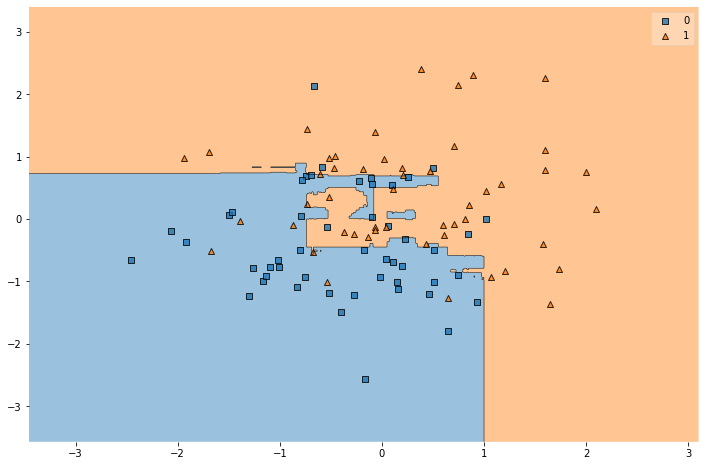

In [ ]:
rf = ensemble.RandomForestClassifier ( min_samples_leaf=3 )
rf.fit (X, y)
plot_decision_regions(X, y, rf)


Как по науке выбирать случайные подвыборки?  
лучше использовать **bootstrap**: из N объектов делаем выборку тоже N объектов, но с возвращением, примерно 62% в этой подвыборке будут уникальны (задача о беспорядках, вероятность не зависит от N)   
обучаем каждое дерево и усредняем результаты, это и есть Бэггинг (**B**ootstrap **AGG**regate)  
У бустрапа есть одно хорошое побочное свойство, можно использовать Out-of-Bag выборку  (те 1/3 которые не попали в трейн) для кросс-валидации во время учебы, в качестве бесплатного тест сета  
то есть построили ансамбль из 100 деревьев, взяли один объект из трейнсета, выбрали деревья, в которых он не попал в трейнсет дерева и сделали предикт по объекту только на этих деревьях

              precision    recall  f1-score   support

           1       0.92      0.90      0.91      6779
           2       0.91      0.95      0.93      9066
           3       0.89      0.92      0.90      1144
           4       0.86      0.78      0.82        88
           5       0.90      0.69      0.78       304
           6       0.88      0.80      0.84       556
           7       0.92      0.88      0.90       656

    accuracy                           0.91     18593
   macro avg       0.90      0.84      0.87     18593
weighted avg       0.91      0.91      0.91     18593



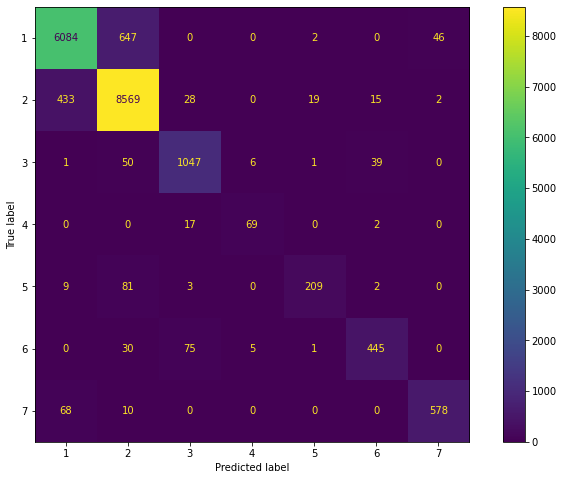

In [ ]:
tb = ensemble.BaggingClassifier (n_estimators=200 , bootstrap=True,  oob_score= True)
tb.fit(X_train, y_train)
y_pred = tb.predict(X_test)
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();

In [ ]:
# oob_score позволяет как раз оценку по Out-of-Bag проводить
tb.oob_score_

0.9153937177280551

делать случайную подвыборку можно не только из сэмплов, но и из признаков. Правда если просто обрезать часть признаков перед постройкой дерева, это скорее всего ухудшит модель, можно выкинуть часть ценных признаков, правильней на каждом разбиении выбирать случайное подмножество признаков, тогда все признаки так или иначе поучаствуют в разбиении  
зачем вообще так стремится к случайным разбиениям всего и вся? Ответ: получить как можно больше независимых друг от друга моделей  
Дело в том, что ансамбли деревеьев имеют такое же смещение, как и деревья его составляющие, thus стремимся строить максимально глубокие обученные деревья, они дают минимальное смещение, правда растет разброс
НО разброс в ансамбле имеет зависимость по формуле: $\frac{разброс\:b(n) + cov\: (b(n)b(m))}{N}$   
(разброс отдельной модели + ковариация с каждым другим деревем в ансамбле / деленное на N (кол-во деревьев)  
То есть если мы сделаем деревья как можно более независимыми, снижая к-нт ковариации и увеличая кол-во деревьев (знаменатель N), то получаем мин смещение за счет глубоких деревье, и снижаем разброс, за счет макс независимости
так работают случайные  леса, используют бустрап и выбор подмножества признаков на каждом разбиении: лучший выбор $\frac{d}{3}$ для регресии и $\sqrt d$ для классификации (d - кол-во признаков)


              precision    recall  f1-score   support

           1       0.92      0.88      0.90      6779
           2       0.89      0.94      0.92      9066
           3       0.87      0.92      0.90      1144
           4       0.87      0.76      0.81        88
           5       0.92      0.55      0.69       304
           6       0.88      0.75      0.81       556
           7       0.95      0.85      0.90       656

    accuracy                           0.90     18593
   macro avg       0.90      0.81      0.84     18593
weighted avg       0.90      0.90      0.90     18593



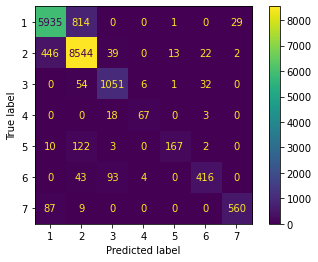

In [ ]:
# композиции деревьев (случайный лес), показывает реультат лучше , чем просто деревья
rf = ensemble.RandomForestClassifier (n_estimators=500, max_features='auto',  oob_score=True   )
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();

In [ ]:
# Случайный лес очень хороший универсальный инструмент, так как позволяет получить макс результат без настройки гиперпараметров, с ростом количества деревьев, ошибка не растет (переобучения нет),
# а просто выходит в прямую линию, соотвественно, можно для перетсраховки просто накинуть деревьев побольше, и точно получим макс результат от модели
rf.oob_score_

0.9003738166953529

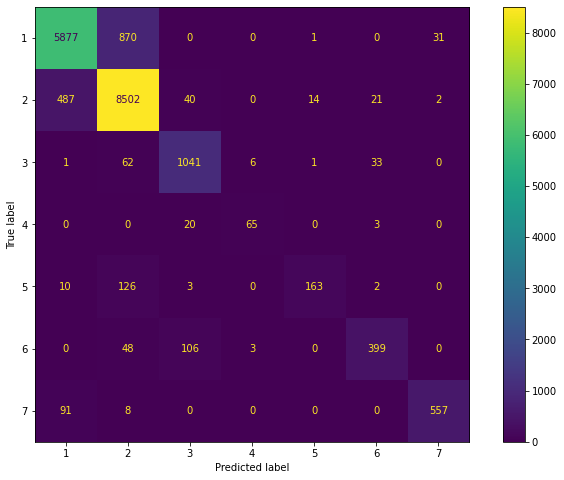

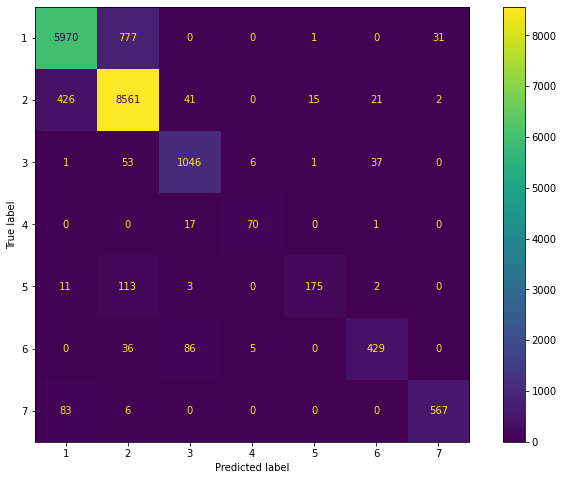

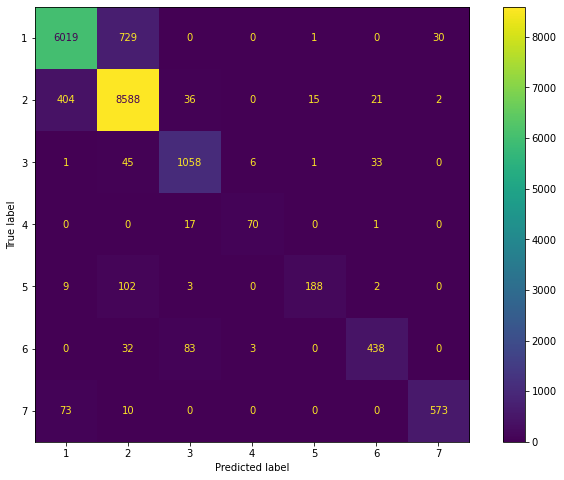

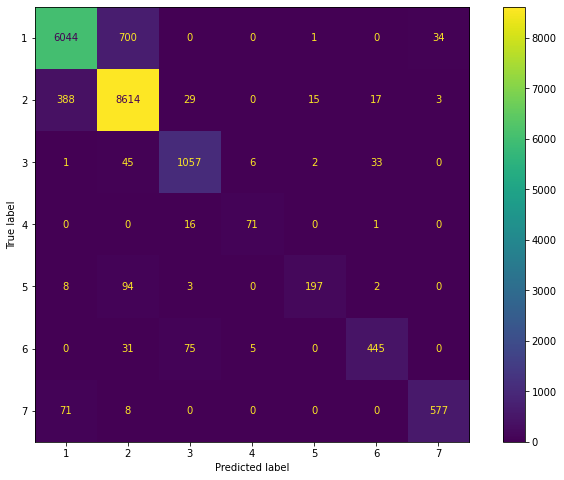

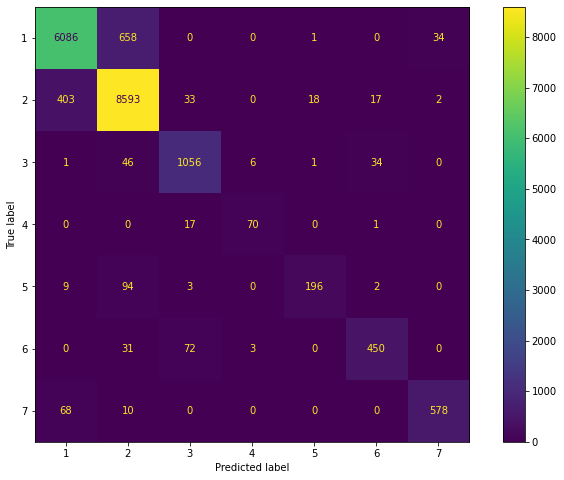

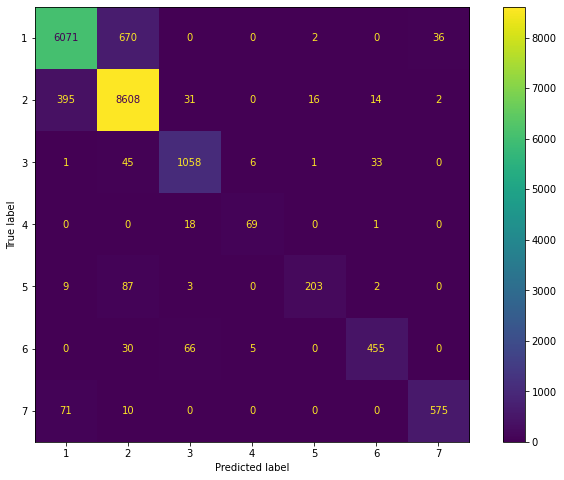

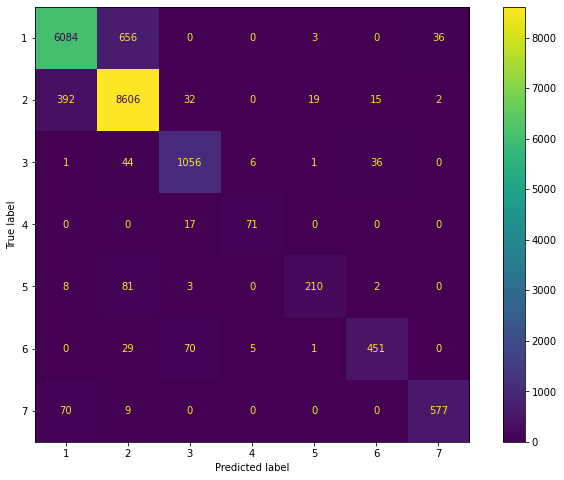

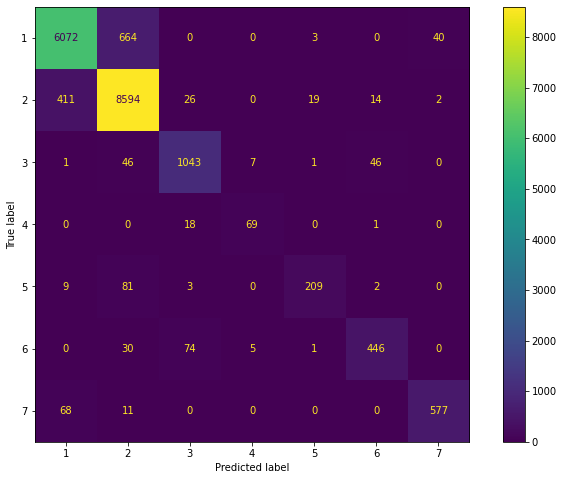

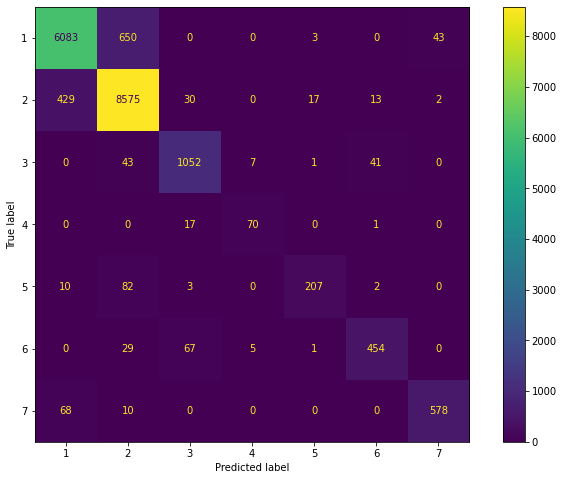

In [ ]:
scor =[]
m_f = np.array (tf.range ( 0.1, 1, 0.1))
for mf in m_f:
  rf = ensemble.RandomForestClassifier (n_estimators=200, max_features=mf,  oob_score=True   )
  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)
  scor.append (rf.oob_score_)
  #cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
  #cm.plot();
Audio ( sound_file, autoplay=True)

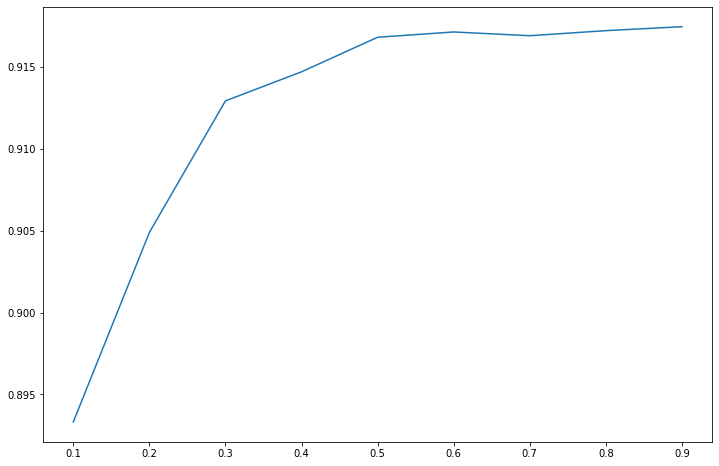

In [ ]:
plt.plot ( m_f , scor)

              precision    recall  f1-score   support

           1       0.93      0.90      0.91      6779
           2       0.91      0.95      0.93      9066
           3       0.90      0.93      0.91      1144
           4       0.86      0.80      0.83        88
           5       0.90      0.67      0.77       304
           6       0.89      0.81      0.85       556
           7       0.94      0.88      0.91       656

    accuracy                           0.92     18593
   macro avg       0.90      0.85      0.87     18593
weighted avg       0.92      0.92      0.92     18593



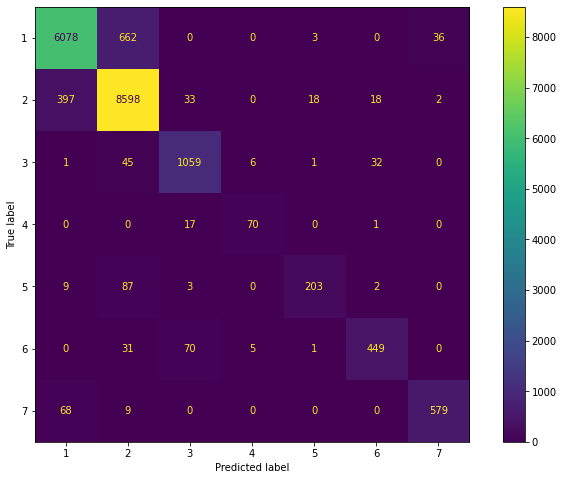

In [ ]:
rf = ensemble.RandomForestClassifier (n_estimators=500, max_features=0.6,  oob_score=True   )
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot()

In [ ]:
# также через случайный лес очень удобно смотреть важность признаков, из-за многих случайных перестановок очень много данных об изменении энтропии данных в зависимости от наличия / отсутствия какого либо признака
fdf = pd.DataFrame (rf.feature_importances_, index=rf.feature_names_in_ ).sort_values ( 0, axis=0 , ascending=False)
fdf

,0
Elevation,3.252548e-01
Horizontal_Distance_To_Roadways,1.233766e-01
Horizontal_Distance_To_Fire_Points,1.170650e-01
Horizontal_Distance_To_Hydrology,6.574424e-02
Vertical_Distance_To_Hydrology,5.109038e-02
Hillshade_Noon,4.307710e-02
Aspect,3.764226e-02
Hillshade_9am,3.583174e-02
Hillshade_3pm,3.231874e-02
Slope,2.523660e-02


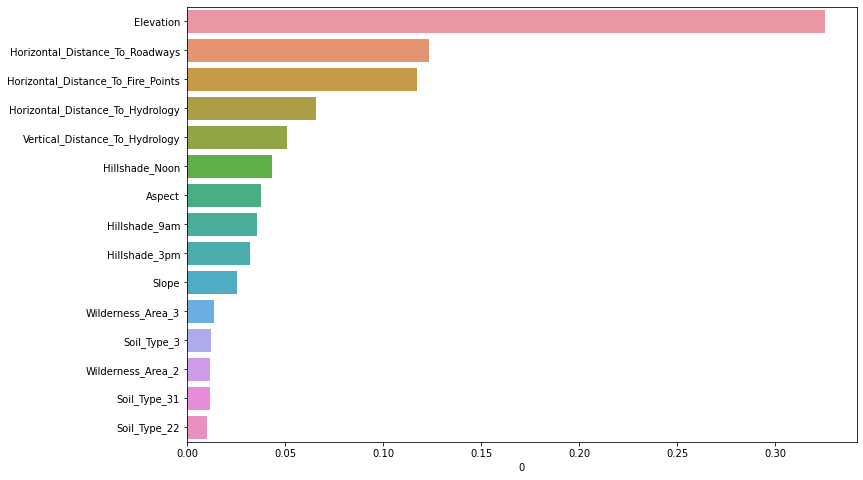

In [ ]:
tfdf = fdf[fdf[0]>0.01]
sns.barplot(x=0, y=tfdf.index, data=tfdf, )

              precision    recall  f1-score   support

           1       0.93      0.90      0.91      8474
           2       0.91      0.95      0.93     11332
           3       0.91      0.92      0.91      1430
           4       0.87      0.82      0.84       110
           5       0.86      0.64      0.74       380
           6       0.88      0.79      0.83       695
           7       0.94      0.87      0.91       820

    accuracy                           0.92     23241
   macro avg       0.90      0.84      0.87     23241
weighted avg       0.92      0.92      0.91     23241



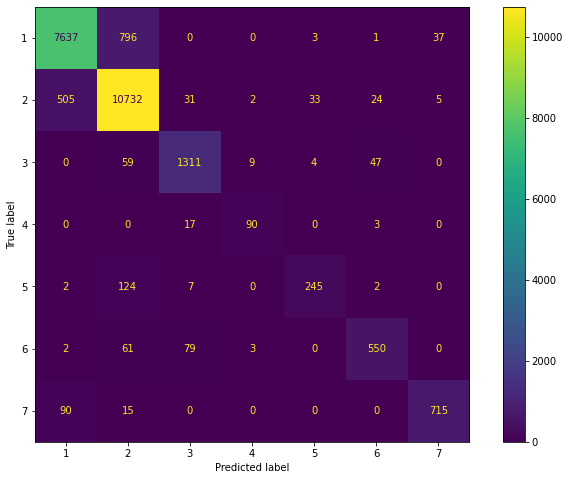

In [ ]:
y_pred_h = tb.predict (hold )
print (metrics.classification_report (hold_y, y_pred_h ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_pred_h , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

              precision    recall  f1-score   support

           1       0.93      0.91      0.92      8474
           2       0.92      0.95      0.93     11332
           3       0.89      0.93      0.91      1430
           4       0.85      0.83      0.84       110
           5       0.89      0.61      0.72       380
           6       0.89      0.81      0.85       695
           7       0.92      0.93      0.92       820

    accuracy                           0.92     23241
   macro avg       0.90      0.85      0.87     23241
weighted avg       0.92      0.92      0.92     23241



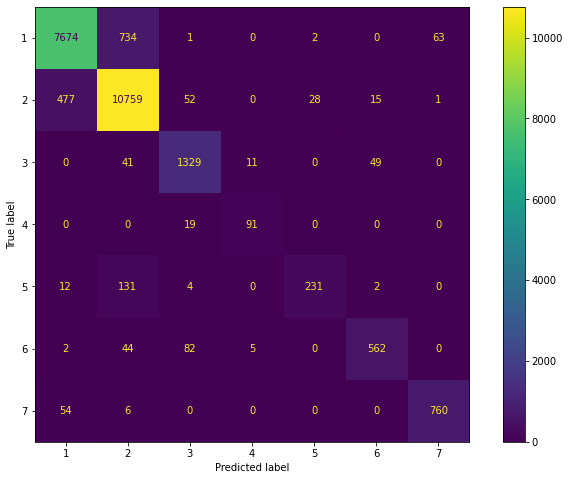

In [ ]:
y_pred_h = rf.predict (hold )
print (metrics.classification_report (hold_y, y_pred_h ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_pred_h , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

Градиентный бустинг

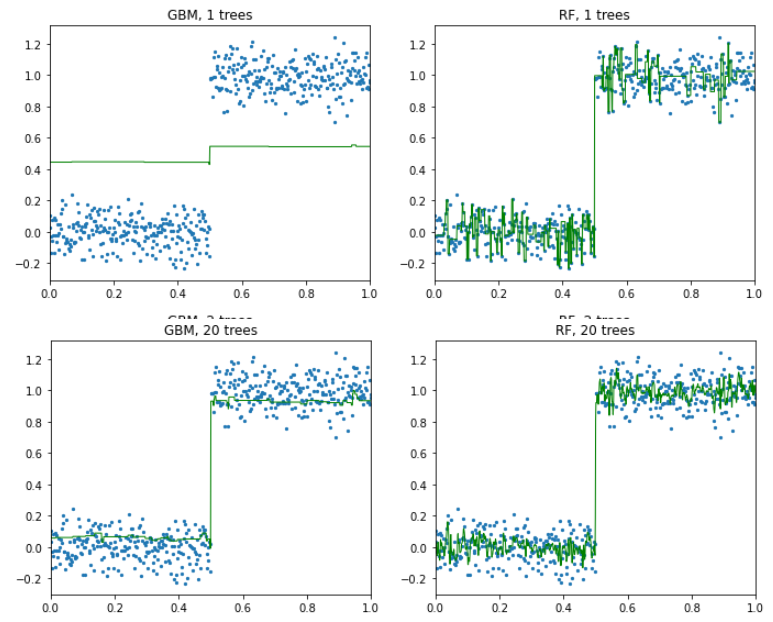

Бустинг использует идею, противоположную бэггингу. В бэггинге мы сразу получали минимальное смещение, не заботясь о разбросе, ибо потом уменьшали его ансамблем деревьев, в бустинге мы строим деревья последовательно и уже не заботимся о смещении, его мы уменьшаем добавлением последующих деревьев в ансамбль, задача которых корректировать ошибки предыдущих, но зато сразу контролируем разброс не строя деревьев с большим разбросом  
При этом модель строится не только последовательно, но и жадно, то есть мы не меняем композицию уже построенных деревьев, а подгоняем следующее дерево, которое будет добавлено в ансамбль так, чтобы оно поправило ошибки композиции  
По сути когда мы добавляем новое дерево в композицию, мы как бы смотрим, а есть ли в наших ошибках какая-то система, какие-то паттерны. Если есть, то давайте попробуем подстроить смещение, которое их сгладит.

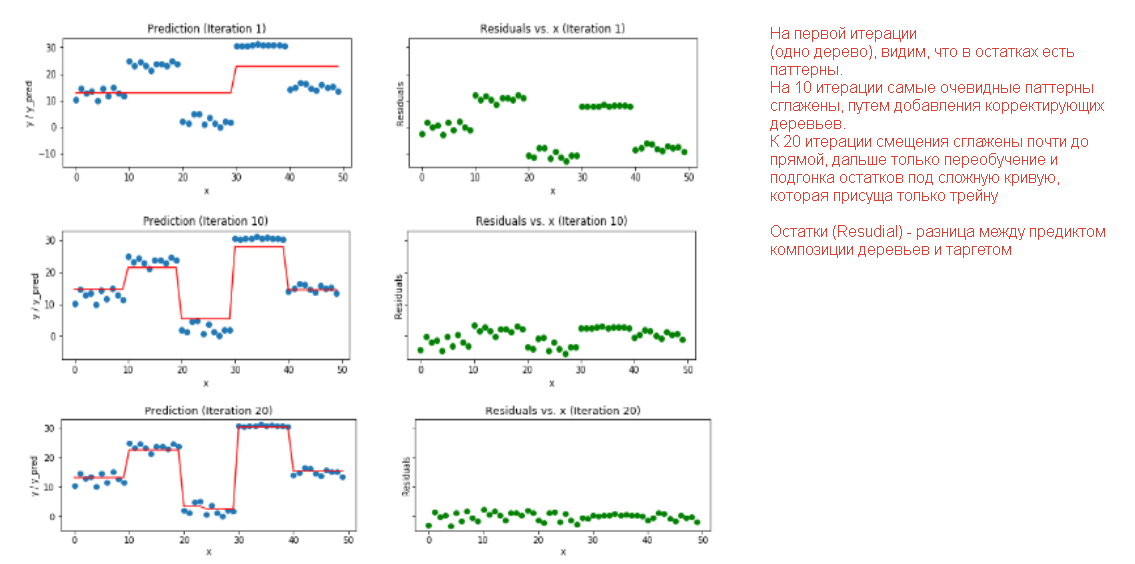

В случае с MSE все просто, мы как бы минимизируем отклонения остатков от таргета (см.картинку выше), иначе говоря мы как бы обучаем каждую новую модель с новыми таргетами (которые равны текущим остаткам), а не изначальными таргетами, и понимаем что нам надо просто постоянно уменьшать арифметическую разницу между остатками и предиктом.  
Но если функция потерь не MSE, а к примеру лог рес, который нам нужен для классификации, то как понять и оценить насколько остатки плохи / хороши, и какие значения должно давать новое дерево, чтобы улучшить всю композицию  
По идее надо минимизировать следующий функционал $L (y^i,\:A(x)_{n-1} + b(x)\:)$, где $A(x)_{n-1}$ - предикт текущий композиции, а $b(x)$ предикт добавляемой модели, которую мы можем менять для минимизации Loss   
Но на напрямую его корректно не минимизировать, поэтому используется следующий прием: если не брать в расчет новую модель, а смотреть с точки зрения как нам поменять текущую композицию, то что и насколько менять легко вычисляется через градиент функции ошибки, то есть берем функцию ошибки по текущей композиции :  $L (y^i,\:A(x)_{n-1})$, диффернцируем по  $A(x)_{n-1}$, и потом считаем значения производной в точке $A(x)_{n-1}$ и добавялем минус. Получаем вектор антиградиента на которую нужно сдвинуть композицию. При этом саму композицию мы не двигаем, а используем значения антиградиента в качестве новых таргетов для нового дерева и уже получаем минимизацию  $L {(b(x_i)\:-\:S_i)}^2$ , где $S_i$ производная по Loss Func по $A(x)_{n-1}$ в точке $A(x)_{n-1}$ на объекте $i$  
Собственно, поэтому бустинг и называется градиентным

In [ ]:
# в отличие от случайных лесов, GB переобучаются, поэтому нужна борьба с обучением, это регуляризация (параметр learning rate, который добавляется к новой модели), ограничение макс глубина и листьев,
# рандомизация объектов, то есть обучаем на подвыборках, а на не всей выборке
# обычный алгоритм, зафиксировать n_estimators, затем подбирать learning rate, потом рандомизация и потом уже ограничение деревьев и рандомизация

              precision    recall  f1-score   support

           1       0.93      0.91      0.92      6779
           2       0.92      0.95      0.93      9066
           3       0.90      0.88      0.89      1144
           4       0.53      0.68      0.59        88
           5       0.88      0.66      0.75       304
           6       0.86      0.79      0.83       556
           7       0.95      0.89      0.92       656

    accuracy                           0.92     18593
   macro avg       0.85      0.82      0.83     18593
weighted avg       0.92      0.92      0.92     18593



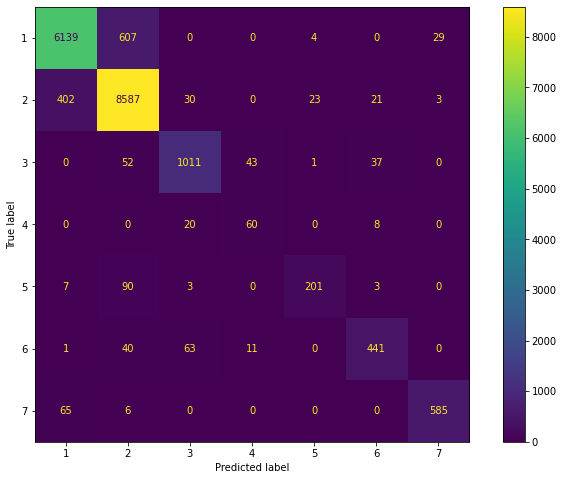

In [ ]:
gbc = ensemble.GradientBoostingClassifier (n_estimators=500,  max_depth=10, subsample=0.5)
%time gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot()

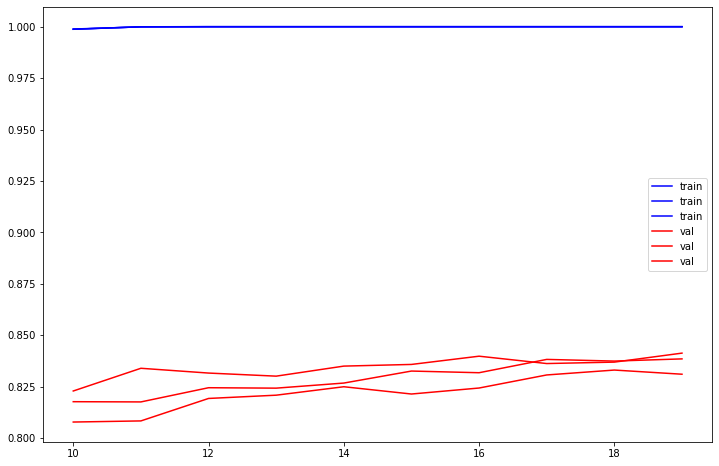

In [ ]:
gbc = ensemble.GradientBoostingClassifier (n_estimators=100)
train_score , val_score = model_selection.validation_curve (gbc , X_train, y_train, param_name= 'max_depth' , param_range=np.arange (10, 20 ) , cv=3, groups = y_train, scoring = 'f1_macro', n_jobs= 5  )
plt.plot (np.arange (10, 20  ),np.median (train_score, axis=1), '-b' , label = 'train')
plt.plot (np.arange (10, 20  ), np.median (val_score, axis=1), label = 'val')
plt.legend()
Audio (sound_file, autoplay=True )

In [ ]:
# пробуем на скорость GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier (сэмплирование через гистограмы, подробней см. ниже)
score = []
ml = [ensemble.GradientBoostingClassifier (n_estimators=50,  max_depth=20), ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier (max_depth=20), n_estimators=50 ) , ensemble.HistGradientBoostingClassifier (max_depth=20 )]
for m in ml:
  %time  m.fit (X_train, y_train)
  y_pred = m.predict (X_test)
  score.append ([ m,metrics.f1_score (y_test, y_pred , average='macro' )])

CPU times: user 15min 31s, sys: 2.78 s, total: 15min 34s
Wall time: 15min 59s
CPU times: user 1min 7s, sys: 271 ms, total: 1min 8s
Wall time: 1min 7s
CPU times: user 5.35 s, sys: 143 ms, total: 5.49 s
Wall time: 3.03 s


In [ ]:
pd.DataFrame (score, columns=['model' , 'f1_macro'])

,model,f1_macro
0,([DecisionTreeRegressor(criterion='friedman_ms...,0.853458
1,"(DecisionTreeClassifier(max_depth=20, random_s...",0.857685
2,HistGradientBoostingClassifier(max_depth=20),0.661578


CPU times: user 8min 45s, sys: 1.34 s, total: 8min 46s
Wall time: 8min 50s
              precision    recall  f1-score   support

           1       0.92      0.89      0.90      6779
           2       0.90      0.94      0.92      9066
           3       0.89      0.92      0.91      1144
           4       0.92      0.78      0.85        88
           5       0.94      0.57      0.71       304
           6       0.86      0.79      0.83       556
           7       0.97      0.86      0.91       656

    accuracy                           0.91     18593
   macro avg       0.91      0.82      0.86     18593
weighted avg       0.91      0.91      0.91     18593



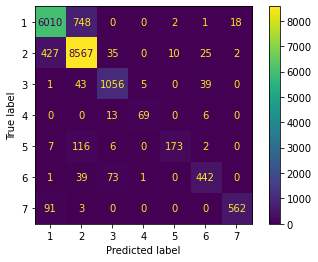

In [ ]:
ab = ensemble.AdaBoostClassifier (tree.DecisionTreeClassifier (max_depth=14) ,n_estimators=500)
%time ab.fit(X_train, y_train)
y_pred = ab.predict(X_test)
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot()

In [ ]:
print (metrics.classification_report (y_train, ab.predict(X_train) ))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27115
           2       1.00      1.00      1.00     36262
           3       1.00      1.00      1.00      4577
           4       1.00      1.00      1.00       351
           5       1.00      1.00      1.00      1215
           6       1.00      1.00      1.00      2222
           7       1.00      1.00      1.00      2626

    accuracy                           1.00     74368
   macro avg       1.00      1.00      1.00     74368
weighted avg       1.00      1.00      1.00     74368



upgrade классического бустинга:
 * ODT - на каждом уровне  используется только один признак и один порог, сильно повышает скорость
 - Leaf-wise не просто каждую вершину разбиваем на 2, а каждый раз смотрим разбиение какой вершины, даст меньшую ошибку, получаются несимметричные деревья, но ошибка может быть ниже
 - вместо перебора всех возможных порогов признака, строим гистограму распределения признаков, и в качестве порогов используем границы бинов
 - еще вариант по каждому смотрим значение сдвига, те, которые близки к нулю, мало влияют на уменьшение ошибки и мы их выкидываем и работаем только с оставшимися
 - если исходный Loss был не MSE, после того как композиция построена, можно заново подобрать прогнозы в итоговых листьях, чтобы они лучше бились с исходными таргетами

CPU times: user 11min 40s, sys: 1min 15s, total: 12min 56s
Wall time: 7min 45s
              precision    recall  f1-score   support

           1       0.90      0.86      0.88      6779
           2       0.88      0.93      0.91      9066
           3       0.88      0.88      0.88      1144
           4       0.65      0.82      0.73        88
           5       0.81      0.66      0.73       304
           6       0.84      0.72      0.78       556
           7       0.93      0.85      0.89       656

    accuracy                           0.89     18593
   macro avg       0.84      0.82      0.83     18593
weighted avg       0.89      0.89      0.89     18593



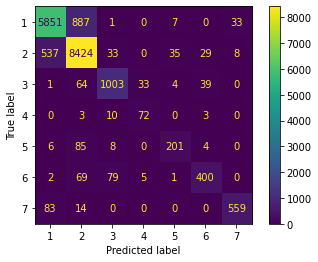

In [ ]:
hb = ensemble.HistGradientBoostingClassifier ( max_iter=200, max_depth=150, min_samples_leaf=1, max_leaf_nodes=None, verbose=5 ) # пороги через бины гистограммы, результат немногим хуже, чем у GBC а работает быстрее,
# только надо подобрать правильно параметры. Adaboost работает и быстрее и лучше, но на очень больших данных профит будет очевиден (напрмер на фулл дата сете CovType)
%time hb.fit(X_train, y_train)
y_pred = hb.predict(X_test)
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot()

In [ ]:
print (metrics.classification_report (y_train, hb.predict(X_train) ))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99     27115
           2       0.99      0.99      0.99     36262
           3       0.99      0.99      0.99      4577
           4       0.97      0.97      0.97       351
           5       0.98      0.96      0.97      1215
           6       0.98      0.97      0.98      2222
           7       0.99      0.98      0.99      2626

    accuracy                           0.99     74368
   macro avg       0.98      0.98      0.98     74368
weighted avg       0.99      0.99      0.99     74368



25

In [ ]:
!pip install lightgbm
!pip install catboost
!pip install xgboost

In [ ]:
import lightgbm as lgbm
import catboost as catb
import xgboost as xgb

CPU times: user 1min 50s, sys: 22.4 s, total: 2min 13s
Wall time: 1min 35s
              precision    recall  f1-score   support

           1       0.91      0.89      0.90      6779
           2       0.91      0.93      0.92      9066
           3       0.92      0.92      0.92      1144
           4       0.84      0.73      0.78        88
           5       0.88      0.70      0.78       304
           6       0.87      0.83      0.85       556
           7       0.94      0.93      0.94       656

    accuracy                           0.91     18593
   macro avg       0.90      0.85      0.87     18593
weighted avg       0.91      0.91      0.91     18593



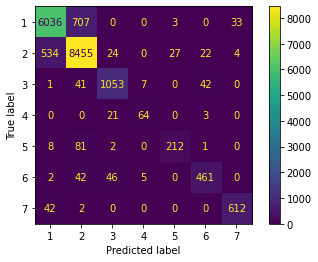

In [ ]:
# быстрый и точный, вшит алгоритм wise-leaf, также по умолчанию есть сэмплинг по бинам на выборке > 200 000 (настраивается), через параметр boosting_type реализуется
# сэмплинг объектов по градиенту (Gradient-based One-Side Sampling (GOSS)), выбираются из признаков только топ N по градиенту (сработает только на фуллсете, ибо все равно ухудшает качество, на 70 000 прирост скорочти мизерный)
lgb = lgbm.LGBMClassifier (  n_estimators=1000, learning_rate=0.11, num_leaves=None,  min_child_samples=2)
%time lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot()

In [ ]:
print (metrics.classification_report (y_train, lgb.predict(X_train) ))

              precision    recall  f1-score   support

           1       0.98      0.97      0.97     27115
           2       0.97      0.99      0.98     36262
           3       1.00      1.00      1.00      4577
           4       1.00      1.00      1.00       351
           5       1.00      1.00      1.00      1215
           6       1.00      1.00      1.00      2222
           7       1.00      1.00      1.00      2626

    accuracy                           0.98     74368
   macro avg       0.99      0.99      0.99     74368
weighted avg       0.98      0.98      0.98     74368



In [ ]:
train_score, val_score = model_selection.validation_curve ( lgb, X_train, y_train, param_name='learning_rate', param_range=np.linspace (0.09, 0.15, 10), cv=3, scoring='f1_macro', n_jobs=-1, verbose=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  6.3min remaining: 56.5min
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed: 14.9min remaining: 29.8min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed: 27.4min remaining: 20.9min
[Parallel(n_jobs=-1)]: Done  24 out of  30 | elapsed: 37.3min remaining:  9.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 47.3min finished


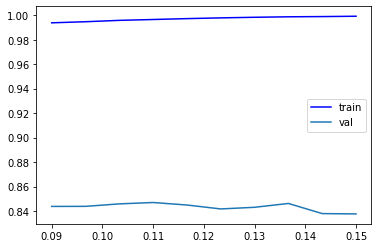

In [ ]:
plt.plot (np.linspace (0.09, 0.15, 10), np.mean (train_score, axis=1), '-b' , label = 'train')
plt.plot (np.linspace (0.09, 0.15, 10), np.mean (val_score, axis=1), label = 'val')
plt.legend()

In [ ]:
val_score

array([[0.83703023, 0.85259972, 0.84162003],
       [0.83777072, 0.85250609, 0.84111314],
       [0.83783797, 0.85421891, 0.84538804],
       [0.84203507, 0.85224842, 0.84653412],
       [0.83683619, 0.85164019, 0.84620716],
       [0.83297698, 0.85001565, 0.8420634 ],
       [0.83776088, 0.8461851 , 0.8451555 ],
       [0.84320476, 0.85171166, 0.8435843 ],
       [0.83819946, 0.84388779, 0.83157944],
       [0.84011849, 0.84006781, 0.83266845]])

In [ ]:
np.linspace (0.09, 0.15, 10)

array([0.09      , 0.09666667, 0.10333333, 0.11      , 0.11666667,
       0.12333333, 0.13      , 0.13666667, 0.14333333, 0.15      ])

CPU times: user 2h 30min 40s, sys: 1h 20min 27s, total: 3h 51min 8s
Wall time: 2h 6min 15s
              precision    recall  f1-score   support

           1       0.92      0.90      0.91      6779
           2       0.92      0.94      0.93      9066
           3       0.90      0.92      0.91      1144
           4       0.82      0.74      0.78        88
           5       0.84      0.67      0.75       304
           6       0.85      0.80      0.83       556
           7       0.93      0.91      0.92       656

    accuracy                           0.91     18593
   macro avg       0.88      0.84      0.86     18593
weighted avg       0.91      0.91      0.91     18593



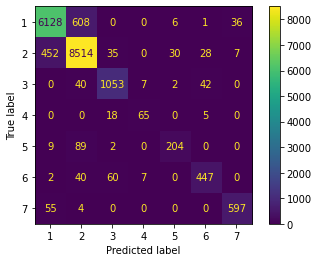

In [ ]:
  # CatBoost
cbs = catb.CatBoostClassifier (depth=15, max_leaves=None, penalties_coefficient=0, silent=True )
%time cbs.fit(X_train, y_train)
y_pred = cbs.predict(X_test)
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot()

In [ ]:
print (metrics.classification_report (y_train, cbs.predict(X_train) ))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27115
           2       1.00      1.00      1.00     36262
           3       1.00      1.00      1.00      4577
           4       1.00      1.00      1.00       351
           5       1.00      1.00      1.00      1215
           6       1.00      1.00      1.00      2222
           7       1.00      1.00      1.00      2626

    accuracy                           1.00     74368
   macro avg       1.00      1.00      1.00     74368
weighted avg       1.00      1.00      1.00     74368



In [ ]:
cbs.get_all_params()

{'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'border_count': 254,
 'class_names': [1, 2, 3, 4, 5, 6, 7],
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'MultiClass',
 'feature_border_type': 'GreedyLogSum',
 'force_unit_auto_pair_weights': False,
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.09857399761676788,
 'loss_function': 'MultiClass',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 0,
 'random_strength': 1,
 'rsm': 1,
 'sampling_f

CPU times: user 12min 8s, sys: 921 ms, total: 12min 9s
Wall time: 12min 11s
              precision    recall  f1-score   support

           1       0.93      0.90      0.92      6779
           2       0.92      0.95      0.93      9066
           3       0.91      0.93      0.92      1144
           4       0.86      0.88      0.87        88
           5       0.89      0.65      0.75       304
           6       0.88      0.82      0.85       556
           7       0.94      0.91      0.93       656

    accuracy                           0.92     18593
   macro avg       0.90      0.86      0.88     18593
weighted avg       0.92      0.92      0.92     18593



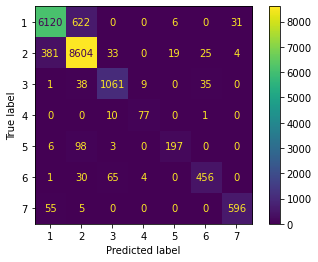

In [ ]:
# оригинальный XGBoost
xbc = xgb.XGBClassifier (max_depth=11, n_estimators=300, objective='multi:softmax' , )
%time xbc.fit(X_train, y_train)
y_pred = xbc.predict(X_test)
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot()

In [ ]:
Audio (sound_file, autoplay=True)
print (metrics.classification_report (y_train, xbc.predict(X_train) ))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99     27115
           2       0.99      1.00      0.99     36262
           3       1.00      1.00      1.00      4577
           4       1.00      1.00      1.00       351
           5       1.00      1.00      1.00      1215
           6       1.00      1.00      1.00      2222
           7       1.00      1.00      1.00      2626

    accuracy                           0.99     74368
   macro avg       1.00      1.00      1.00     74368
weighted avg       0.99      0.99      0.99     74368



In [ ]:
xbc.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 11,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 300,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'multi:softprob',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

### Деревья и бустинги в регрессии (калифорния)

In [ ]:
pd.DataFrame (res, index = ['RMSE', 'MAE' , 'MedianAE' , 'R2'] )

,m8,Huber
RMSE,0.793017,0.687400
MAE,0.475454,0.460453
MedianAE,0.287233,0.309128
R2,0.534089,0.646768


In [ ]:
#X_train, X_test, y_train, y_test = model_selection.train_test_split ( df.iloc[:, :-1], df.iloc[:, -1] )

In [ ]:
qtx =  xgb.XGBRegressor (objective='reg:squarederror', max_depth=10, n_estimators=1000)
qtx.fit (X_train, y_train)
res[qtx] = reg_scorer (qtx, y_test, X_test)[0]

Mean_AE:  0.2993583253316251
Median_AE:  0.18708216714859005
R2:  0.8405909308057077


In [ ]:
reg_scorer (qtx, y_train, X_train)[0]

Mean_AE:  0.006249779508526622
Median_AE:  0.0035373868942261133
R2:  0.9999254783412433


[0.009953711261428844,
 0.006249779508526622,
 0.0035373868942261133,
 0.9999254783412433]

Mean_AE:  0.2993583253316251
Median_AE:  0.18708216714859005
R2:  0.8405909308057077


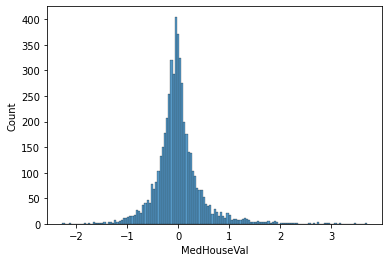

In [ ]:
sns.histplot ( reg_scorer (qtx, y_test, X_test)[1])

In [ ]:
# трансофрм таргета в нормальное распределение не дает прироста
mt = compose.TransformedTargetRegressor (xgb.XGBRegressor (objective='reg:squarederror',  max_depth=12, n_estimators=500 )  ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
mt.fit ( X_train, y_train)

TransformedTargetRegressor(regressor=XGBRegressor(max_depth=12,
                                                  n_estimators=500,
                                                  objective='reg:squarederror'),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [ ]:
reg_scorer (mt, y_train, X_train)[0]

Mean_AE:  0.0081675279812545
Median_AE:  0.0036636939048766415
R2:  0.9998176772203023


[0.00024240651673282287,
 0.0081675279812545,
 0.0036636939048766415,
 0.9998176772203023]

Mean_AE:  0.3363418630101995
Median_AE:  0.17164667296409603
R2:  0.7594794086754737


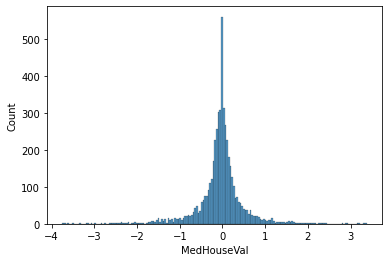

In [ ]:
sns.histplot ( reg_scorer (mt, y_test, X_test)[1])

In [ ]:
lqtx = lgbm.LGBMRegressor ( max_depth=35, n_estimators=1200 , num_leaves=50)
lqtx.fit (X_train, y_train)
res[lqtx] = reg_scorer (lqtx, y_test, X_test)[0]


Mean_AE:  0.2909976663511774
Median_AE:  0.18689015305605916
R2:  0.8515589944538919


In [ ]:
reg_scorer (lqtx, y_train, X_train)[0]

Mean_AE:  0.06597959264794084
Median_AE:  0.04747258464160087
R2:  0.9932381357958529


[0.09481499015956968,
 0.06597959264794084,
 0.04747258464160087,
 0.9932381357958529]

Mean_AE:  0.2909976663511774
Median_AE:  0.18689015305605916
R2:  0.8515589944538919


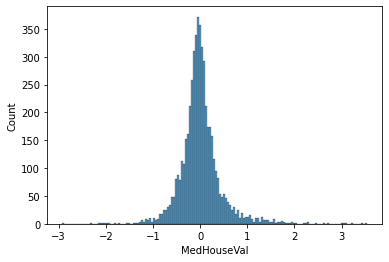

In [ ]:
sns.histplot ( reg_scorer (lqtx, y_test, X_test)[1])

In [ ]:
lbm = compose.TransformedTargetRegressor (lgbm.LGBMRegressor ( max_depth=35, n_estimators=1200,  num_leaves=50 )  ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
lbm.fit ( X_train, y_train)
reg_scorer ( lbm, y_test, X_test)[0]

Mean_AE:  0.3379805746256803
Median_AE:  0.17843030355035666
R2:  0.762714031191626


[0.3173476128296098,
 0.3379805746256803,
 0.17843030355035666,
 0.762714031191626]

In [ ]:
reg_scorer (lbm, y_train, X_train)[0]

Mean_AE:  0.08332830141496325
Median_AE:  0.04917999826462621
R2:  0.986131012658163


[0.01843945620904039,
 0.08332830141496325,
 0.04917999826462621,
 0.986131012658163]

Mean_AE:  0.3379805746256803
Median_AE:  0.17843030355035666
R2:  0.762714031191626


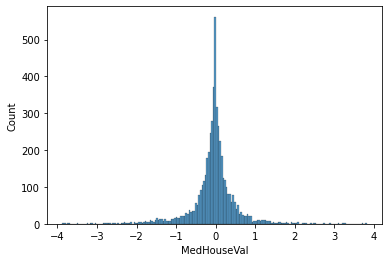

In [ ]:
sns.histplot ( reg_scorer (lbm, y_test, X_test)[1])

In [ ]:
rfb = ensemble.RandomForestRegressor (n_estimators=1500)
%time rfb.fit (X_train, y_train)
reg_scorer (rfb, y_test, X_test)[0]

CPU times: user 3min 28s, sys: 631 ms, total: 3min 28s
Wall time: 4min 7s
Mean_AE:  0.3251907876537483
Median_AE:  0.2047626733333322
R2:  0.8155244641564899


[0.4967624563153473,
 0.3251907876537483,
 0.2047626733333322,
 0.8155244641564899]

In [ ]:
reg_scorer (rfb, y_train, X_train)[0]

Mean_AE:  0.12026982563609212
Median_AE:  0.07324167666665449
R2:  0.9741298096114953


[0.18545715549110076,
 0.12026982563609212,
 0.07324167666665449,
 0.9741298096114953]

In [ ]:
pd.DataFrame(res, index = ['MSE', 'MAE' , 'MedianAE' , 'R2'] ) # бустинг лучший

,m8,Huber,"XGBRegressor(max_depth=10, n_estimators=1000, objective='reg:squarederror')","LGBMRegressor(max_depth=35, n_estimators=1200, num_leaves=50)"
MSE,0.793017,0.687400,0.461781,0.445611
MAE,0.475454,0.460453,0.299358,0.290998
MedianAE,0.287233,0.309128,0.187082,0.186890
R2,0.534089,0.646768,0.840591,0.851559


### Keras

In [ ]:
X_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
8369,2.3882,47.0,4.364086,1.126853,2374.0,3.911038,33.98,-118.34
20226,1.9286,26.0,4.212644,1.071264,2775.0,3.189655,34.29,-119.30
19297,4.1731,26.0,5.154574,0.993691,909.0,2.867508,38.37,-122.80
15879,2.0325,52.0,4.218324,1.181287,2034.0,3.964912,37.75,-122.41
6269,3.4940,31.0,4.508637,1.034549,2028.0,3.892514,34.05,-117.95
...,...,...,...,...,...,...,...,...
12011,6.1561,12.0,10.043860,1.399123,728.0,3.192982,33.92,-117.53
15654,1.4552,52.0,1.902087,1.059390,1007.0,1.616372,37.79,-122.40
8882,11.7045,40.0,7.764045,0.938202,483.0,2.713483,34.04,-118.51
8219,4.5938,33.0,0.888889,0.500000,96.0,2.666667,33.79,-118.21


In [ ]:
Sc = preprocessing.StandardScaler()
X_train_nn = Sc.fit_transform (X_train)
X_test_nn = Sc.transform ( X_test)

In [ ]:
kmc = models.Sequential ()
kmc.add ( layers.Dense (54 , activation='relu'))
#kmc.add ( layers.BatchNormalization ()) # нормализуем после каждого слоя
#kmc.add ( layers.Dense (125 , activation='relu'))
#kmc.add ( layers.BatchNormalization () )
#kmc.add ( layers.Dense (128 , activation='relu'))
kmc.add ( layers.Dense (1))
kmc.compile ( loss = 'mse' , metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
%time his=kmc.fit (X_train_nn, y_train,  validation_data=(X_test_nn, y_test),  epochs=300, verbose=0)
Audio ( sound_file, autoplay=True)

CPU times: user 5min 15s, sys: 23.7 s, total: 5min 39s
Wall time: 5min 22s


In [ ]:
hd.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

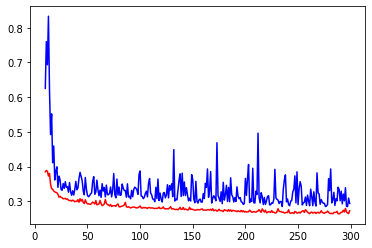

In [ ]:
hd=his.history
s= 10
f = 299
loss = hd['loss']
loss=loss[s:f+1]
acc = hd['root_mean_squared_error']
acc=acc[s:f+1]
val_loss = hd['val_loss']
val_loss=val_loss[s:f+1]
val_acc = hd['val_root_mean_squared_error']
val_acc=val_acc[s:f+1]
plt.plot (np.arange (s, f+1), loss, '-r' )
plt.plot (np.arange (s, f+1), val_loss, '-b')
#plt.plot (np.arange (s, f+1), acc, '--r' )
#plt.plot (np.arange (s, f+1), val_acc, '--b')
plt.show()

In [ ]:
reg_scorer ( kmc, y_test, X_test_nn)[0]

Mean_AE:  0.3678830704645297
Median_AE:  0.2542978324890135
R2:  0.7800499327750825


[0.5424271575696922,
 0.3678830704645297,
 0.2542978324890135,
 0.7800499327750825]

In [ ]:
reg_scorer ( kmc, y_train, X_train_nn)[0]

Mean_AE:  0.31388217689126957
Median_AE:  0.2051914048194886
R2:  0.8251575324833884


[0.4821334299254077,
 0.31388217689126957,
 0.2051914048194886,
 0.8251575324833884]

## Метрические алгоритмы (построены на расстояниях) SVM, Knn

Метрические алгоритмы строятся на измерении расстояний до соседних точек и попытке усреднить показатели соседов и использовать для предикта соседней точки снеизвестнм значением

### Нелинейные регрессоры (SVM, Knn, наивный Байес, гауссиан процессы)

#### Нелинейные регрессоры (калифорния недвижка)

In [ ]:
#X_train, X_test, y_train, y_test = model_selection.train_test_split ( df.iloc[:, :-1], df.iloc[:, -1] )
#res= {}

In [ ]:
# обычный SVC c линейным ядром
tr = compose.TransformedTargetRegressor (svm.SVR(kernel='linear') ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
mm = pipeline.make_pipeline (preprocessing.StandardScaler(),  tr)
mm.fit (X_train, y_train)
reg_scorer (mm, y_test, X_test)[0]

Mean_AE:  0.4596423806465004
Median_AE:  0.3069957371101698
R2:  0.6473095654300081


[0.6868726377788645,
 0.4596423806465004,
 0.3069957371101698,
 0.6473095654300081]

Mean_AE:  0.381059906940542
Median_AE:  0.2355980517727968
R2:  0.7413078998968978
Mean_AE:  0.381059906940542
Median_AE:  0.2355980517727968
R2:  0.7413078998968978


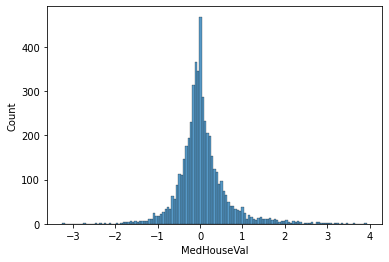

In [ ]:
# обычный SVC c нелинейным ядром rbf
tr = compose.TransformedTargetRegressor (svm.SVR(cache_size=9000) ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
mm = pipeline.make_pipeline (preprocessing.StandardScaler(),  tr)
mm.fit (X_train, y_train)
res[tr.regressor_] = reg_scorer (mm, y_test, X_test)[0]
sns.histplot ( reg_scorer (mm, y_test, X_test)[1])

In [ ]:
# SVC c нелинейным ядром poly степени три
tr = compose.TransformedTargetRegressor (svm.SVR(kernel='poly', degree=3,  cache_size=9000) ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
mm = pipeline.make_pipeline (preprocessing.StandardScaler(),  tr)
%time mm.fit (X_train, y_train)
reg_scorer (mm, y_test, X_test)[0]

CPU times: user 4min 18s, sys: 318 ms, total: 4min 18s
Wall time: 4min 17s
Mean_AE:  0.5129806986412305
Median_AE:  0.35173715342873846
R2:  0.577531872700477


[0.7517550434005048,
 0.5129806986412305,
 0.35173715342873846,
 0.577531872700477]

In [ ]:
# Knn c увеличенным штрафом за непохожесть
tr = compose.TransformedTargetRegressor (neighbors.KNeighborsRegressor (n_neighbors=15 , weights='distance',  leaf_size=12, p=2, n_jobs=3) ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
mm = pipeline.make_pipeline (preprocessing.StandardScaler(),  tr)
%time mm.fit (X_train, y_train)
res[tr.regressor_] = reg_scorer (mm, y_test, X_test)[0]

CPU times: user 41.5 ms, sys: 41 µs, total: 41.5 ms
Wall time: 41.2 ms
Mean_AE:  0.43450365718191425
Median_AE:  0.27815284942016727
R2:  0.6729415096330053


In [ ]:
tr = compose.TransformedTargetRegressor (gaussian_process.GaussianProcessRegressor (n_restarts_optimizer=3 ) ,  transformer=preprocessing.QuantileTransformer(output_distribution='normal') )
mm = pipeline.make_pipeline (preprocessing.StandardScaler(),  tr)
%time mm.fit (X_train, y_train)
reg_scorer (mm, y_test, X_test)[0]

CPU times: user 2min 48s, sys: 4.99 s, total: 2min 53s
Wall time: 1min 41s
Mean_AE:  1.840890497132659
Median_AE:  1.5171434278783076
R2:  -2.991363106423734


Mean_AE:  1.840890497132659
Median_AE:  1.5171434278783076
R2:  -2.991363106423734


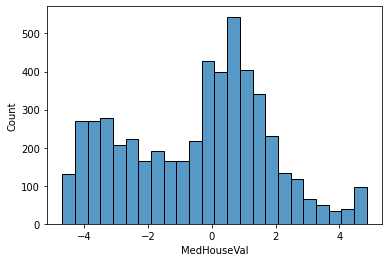

In [ ]:
sns.histplot ( reg_scorer (mm, y_test, X_test)[1])

In [ ]:
pd.DataFrame (res, index = ['RMSE', 'MAE' , 'MedianAE' , 'R2'] ) # нелинейные модели проигрывают, пока фаворит  SVR c нелинейным ядром

,m8,Huber,"XGBRegressor(max_depth=10, n_estimators=1000, objective='reg:squarederror')","LGBMRegressor(max_depth=35, n_estimators=1200, num_leaves=50)",SVR(cache_size=9000),"KNeighborsRegressor(leaf_size=12, n_jobs=3, n_neighbors=15, weights='distance')"
RMSE,0.793017,0.687400,0.461781,0.445611,0.588262,0.661442
MAE,0.475454,0.460453,0.299358,0.290998,0.381060,0.434504
MedianAE,0.287233,0.309128,0.187082,0.186890,0.235598,0.278153
R2,0.534089,0.646768,0.840591,0.851559,0.741308,0.672942


In [ ]:
	    m8	      Huber	    base
MAE	  0.451089	0.448845	0.531797
MDAE	0.284957	0.302304	0.421211
R2	  0.651634	0.665666	0.603995

### Нелинейные классификаторы (SVM, Knn, наивный Байес, гауссиан процессы)

#### на примере CovType

              precision    recall  f1-score   support

           1       0.81      0.77      0.79      6779
           2       0.80      0.87      0.83      9066
           3       0.76      0.86      0.81      1144
           4       0.83      0.57      0.68        88
           5       0.88      0.14      0.24       304
           6       0.69      0.42      0.52       556
           7       0.89      0.73      0.80       656

    accuracy                           0.80     18593
   macro avg       0.81      0.62      0.67     18593
weighted avg       0.80      0.80      0.79     18593



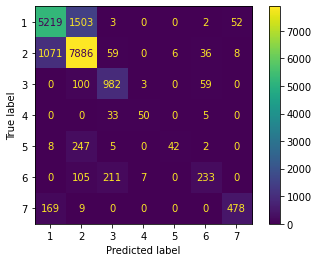

In [ ]:
svm_nonlin = svm.SVC() # обычный SVC c нелинейным ядром rbf
svm_nonlin.fit ( X_train, y_train)
y_pred = svm_nonlin.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();

CPU times: user 7min 4s, sys: 5.57 s, total: 7min 10s
Wall time: 7min 7s
              precision    recall  f1-score   support

           1       0.80      0.75      0.77      6779
           2       0.79      0.87      0.82      9066
           3       0.77      0.84      0.80      1144
           4       0.81      0.68      0.74        88
           5       0.85      0.15      0.26       304
           6       0.69      0.42      0.52       556
           7       0.88      0.71      0.79       656

    accuracy                           0.79     18593
   macro avg       0.80      0.63      0.67     18593
weighted avg       0.79      0.79      0.78     18593



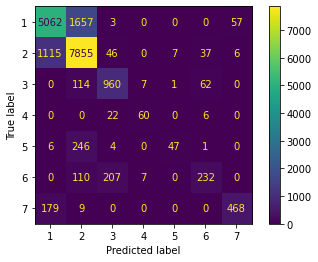

In [ ]:
svm_nionlin1 = svm.SVC(C=1.0, kernel='poly', degree=3,  cache_size=5000, class_weight=None) # SVC c нелинейным ядром poly степени три,
%time svm_nionlin1.fit ( X_train, y_train)
y_pred = svm_nionlin1.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();
Audio ( sound_file, autoplay=True)

CPU times: user 10min 22s, sys: 2.33 s, total: 10min 24s
Wall time: 10min 21s
              precision    recall  f1-score   support

           1       0.76      0.77      0.76      6779
           2       0.85      0.66      0.75      9066
           3       0.76      0.74      0.75      1144
           4       0.50      0.94      0.66        88
           5       0.19      0.92      0.32       304
           6       0.47      0.81      0.59       556
           7       0.59      0.94      0.72       656

    accuracy                           0.72     18593
   macro avg       0.59      0.83      0.65     18593
weighted avg       0.78      0.72      0.74     18593



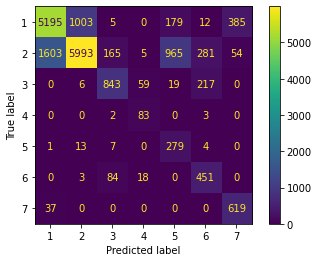

In [ ]:
# результаты лучше, чем у линейных моделей, но можно еще лучше, если убрать проблему дисбаланса классов
svm_nionlin2 = svm.SVC( cache_size=5000, class_weight='balanced') #
%time svm_nionlin2.fit ( X_train, y_train)
y_pred = svm_nionlin2.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();
Audio ( sound_file, autoplay=True)
# как видно, показатели по доминирующим классам чуть упали, но модель хотя бы лучше выделяет мини классы

CPU times: user 12.4 ms, sys: 3 µs, total: 12.4 ms
Wall time: 12.4 ms
              precision    recall  f1-score   support

           1       0.84      0.80      0.82      6779
           2       0.83      0.89      0.86      9066
           3       0.76      0.83      0.79      1144
           4       0.75      0.59      0.66        88
           5       0.73      0.25      0.38       304
           6       0.71      0.50      0.59       556
           7       0.91      0.72      0.81       656

    accuracy                           0.83     18593
   macro avg       0.79      0.66      0.70     18593
weighted avg       0.83      0.83      0.82     18593



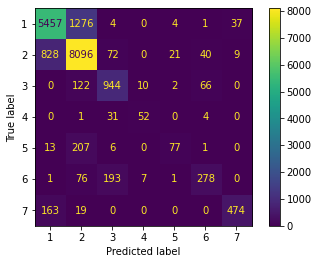

In [ ]:
# Neighbor, для лучшего разделения типов местности, имеет смысл ужесточить штраф за непохожесть признаков, веса ближних объектов выше и кол-во соседей выше
knn_c = neighbors.KNeighborsClassifier ( n_neighbors=40, weights='distance', algorithm='auto', leaf_size=5, p=2, metric='minkowski',  n_jobs=3)
%time knn_c.fit ( X_train, y_train)
y_pred = knn_c.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();

              precision    recall  f1-score   support

           1       0.77      0.75      0.76      8474
           2       0.85      0.68      0.75     11332
           3       0.75      0.74      0.75      1430
           4       0.44      0.85      0.58       110
           5       0.20      0.89      0.33       380
           6       0.45      0.80      0.58       695
           7       0.59      0.95      0.72       820

    accuracy                           0.73     23241
   macro avg       0.58      0.81      0.64     23241
weighted avg       0.78      0.73      0.74     23241



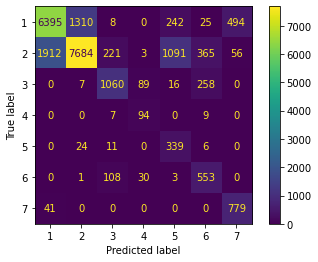

In [ ]:
# проверяем все на отложенной выборке
y_pred_h = svm_nionlin2.predict (hold )
print (metrics.classification_report (hold_y, y_pred_h ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_pred_h , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

              precision    recall  f1-score   support

           1       0.84      0.80      0.82      8474
           2       0.83      0.89      0.86     11332
           3       0.75      0.84      0.79      1430
           4       0.68      0.47      0.56       110
           5       0.82      0.27      0.40       380
           6       0.63      0.45      0.52       695
           7       0.88      0.71      0.79       820

    accuracy                           0.82     23241
   macro avg       0.77      0.63      0.68     23241
weighted avg       0.82      0.82      0.82     23241



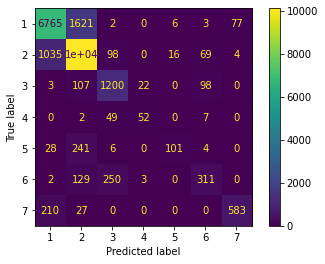

In [ ]:
y_pred_h = knn_c.predict (hold ) # качество KNN неплохое, но очень затратно по времени не только трэйн, но  и предикт
print (metrics.classification_report (hold_y, y_pred_h ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_pred_h , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

In [ ]:
Audio ( sound_file, autoplay=True)

In [ ]:
gp = gaussian_process.GaussianProcessClassifier( max_iter_predict=50, multi_class='one_vs_rest', n_jobs=1)
gp.fit ( X_train, y_train)
y_pred = gp.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();

              precision    recall  f1-score   support

           1       0.60      0.73      0.66      6779
           2       0.72      0.60      0.66      9066
           3       0.55      0.62      0.58      1144
           4       0.26      0.51      0.35        88
           5       0.18      0.17      0.17       304
           6       0.33      0.38      0.36       556
           7       0.68      0.55      0.61       656

    accuracy                           0.63     18593
   macro avg       0.48      0.51      0.48     18593
weighted avg       0.64      0.63      0.63     18593



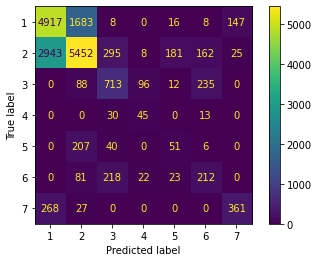

In [ ]:
nb_b = naive_bayes.BernoulliNB ( )
nb_b.fit ( X_train, y_train)
y_pred = nb_b.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();

              precision    recall  f1-score   support

           1       0.67      0.01      0.02      6779
           2       0.90      0.10      0.18      9066
           3       0.28      0.40      0.33      1144
           4       0.08      1.00      0.14        88
           5       0.02      0.73      0.05       304
           6       0.21      0.06      0.09       556
           7       0.12      0.96      0.21       656

    accuracy                           0.13     18593
   macro avg       0.33      0.46      0.15     18593
weighted avg       0.71      0.13      0.13     18593



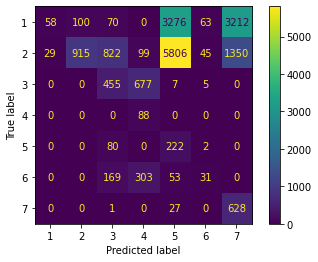

In [ ]:
nb_g = naive_bayes.GaussianNB ( )
nb_g.fit ( X_train, y_train)
y_pred = nb_g.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();

## Keras CovType

In [ ]:
kmc = models.Sequential ()
kmc.add ( layers.Dense (256 , activation='relu'))
kmc.add ( layers.BatchNormalization ()) # нормализуем после каждого слоя
kmc.add ( layers.Dense (256 , activation='relu'))
kmc.add ( layers.BatchNormalization () )
kmc.add ( layers.Dense (128 , activation='relu'))
kmc.add ( layers.Dense (7, activation='softmax'))
kmc.compile ( loss = 'sparse_categorical_crossentropy' , metrics='acc' ) # подходящий loss categorical_crossentropy, когда метки не заданы OHE используется sparse_categorical_crossentropy, метрика стандартная - accuracy

In [ ]:
%time his=kmc.fit (X_train, y_train-1,  validation_data=(X_test, y_test-1),  epochs=50, verbose=0) # приводим метки к range (0,7) так их воспринимает keras
Audio ( sound_file, autoplay=True)

CPU times: user 10min 7s, sys: 26.2 s, total: 10min 33s
Wall time: 7min 33s


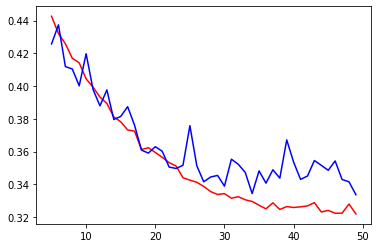

In [ ]:
hd=his.history
s= 5
f = 49
loss = hd['loss']
loss=loss[s:f+1]
acc = hd['acc']
acc=acc[s:f+1]
val_loss = hd['val_loss']
val_loss=val_loss[s:f+1]
val_acc = hd['val_acc']
val_acc=val_acc[s:f+1]
plt.plot (np.arange (s, f+1), loss, '-r' )
plt.plot (np.arange (s, f+1), val_loss, '-b')
#plt.plot (np.arange (s, f+1), acc, '--r' )
#plt.plot (np.arange (s, f+1), val_acc, '--b')
plt.show()

              precision    recall  f1-score   support

           1       0.90      0.85      0.88      6779
           2       0.88      0.91      0.90      9066
           3       0.86      0.85      0.86      1144
           4       0.76      0.80      0.78        88
           5       0.66      0.66      0.66       304
           6       0.70      0.76      0.73       556
           7       0.88      0.90      0.89       656

    accuracy                           0.88     18593
   macro avg       0.81      0.82      0.81     18593
weighted avg       0.88      0.88      0.88     18593



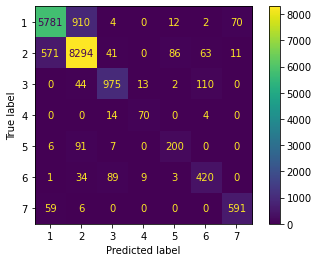

In [ ]:
y_ = kmc.predict (X_test)
y_pred = [(np.argmax (y) + 1) for y in y_]
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

              precision    recall  f1-score   support

           1       0.90      0.85      0.87      8474
           2       0.88      0.92      0.90     11332
           3       0.89      0.88      0.88      1430
           4       0.79      0.76      0.77       110
           5       0.75      0.71      0.73       380
           6       0.76      0.78      0.77       695
           7       0.89      0.90      0.89       820

    accuracy                           0.88     23241
   macro avg       0.84      0.83      0.83     23241
weighted avg       0.88      0.88      0.88     23241



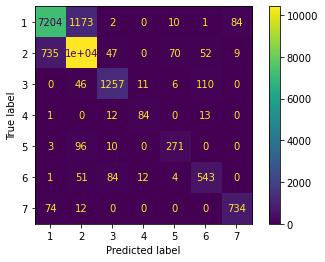

In [ ]:
# проверяем все на отложенной выборке
y_h = kmc.predict (hold )
y_pred_h = [(np.argmax (y) + 1) for y in y_h]
print (metrics.classification_report (hold_y, y_pred_h ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_pred_h , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

## LogReg , Keras, xgboost DecisionTree на фулл датасете CovType

In [ ]:
X, hold, y, hold_y = model_selection.train_test_split (df.iloc[:, :-1] , df.iloc[:, -1], stratify=df.iloc[:, -1] , train_size=0.8) # данных много, поэтому можем сразу отрезать hold
X_train, X_test, y_train, y_test = model_selection.train_test_split (X , y, stratify=y , train_size=0.8) # остаток разбиваем на трейн / тест

In [ ]:
X_train.shape

(371847, 54)

In [ ]:
Sc = preprocessing.StandardScaler() # скалируем сразу трансформим и тест и холд
X_train.iloc[:, :10] = Sc.fit_transform (X_train.iloc[:, :10])
X_test.iloc[:, :10] = Sc.transform ( X_test.iloc[:, :10])
hold.iloc[:, :10]  = Sc.transform ( hold.iloc[:, :10])

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed: 19.3min finished


0.7126376072715901
              precision    recall  f1-score   support

           1       0.71      0.69      0.70     33894
           2       0.75      0.80      0.77     45328
           3       0.68      0.80      0.73      5721
           4       0.62      0.42      0.50       439
           5       0.16      0.00      0.01      1519
           6       0.48      0.27      0.35      2779
           7       0.71      0.58      0.64      3282

    accuracy                           0.72     92962
   macro avg       0.59      0.51      0.53     92962
weighted avg       0.71      0.72      0.71     92962



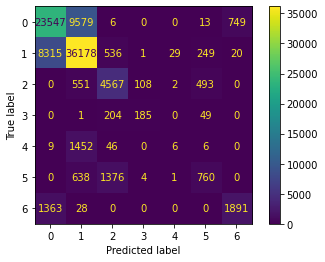

In [ ]:
# лог-рес со встроенным CV, диапазон для выбора штрафа сразу побольше (регуляризация не нужна) и метрику f1_weighted
bs2 = linear_model.LogisticRegressionCV (Cs=np.linspace (900, 10000 , 10)  , max_iter=500, scoring='f1_weighted' , cv=3, n_jobs=5, verbose=3 )
bs2.fit ( X_train, y_train)
y_pred = bs2.predict (X_test )
print (metrics.f1_score (y_test, y_pred,  average='weighted') )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) )   )
cm.plot();
Audio ( sound_file, autoplay=True)

In [ ]:
np.max(bs2.coef_) , bs2.intercept_ ,  bs2.C_ # видно, что модель не переобучилась, также из-за дисбаланса классов, лучше использовать метрику f1 macro, чтобы было видно улучшение на всех классах, а не только на 1,2

(7.380234142523816,
 array([ 5.50229159,  7.58588447, -2.89911164, -8.01349371, -0.39725611,
        -1.88127951,  0.10296491]),
 array([757.81818182, 757.81818182, 757.81818182, 757.81818182,
        757.81818182, 757.81818182, 757.81818182]))

In [ ]:
fd = pd.DataFrame (np.transpose (bs2.coef_)  , index =X_train.columns.to_list() , columns =np.arange (1,8) )
fd1 = fd.rename_axis('features' ).reset_index()


In [ ]:
# создание переменных в цикле
for i  in range (1, 8) :
  mask = (fd1[i]>2.5) | (fd1[i]<-2.5)
  exec(f'tdf_{i} = fd1[mask]')


<BarContainer object of 8 artists>

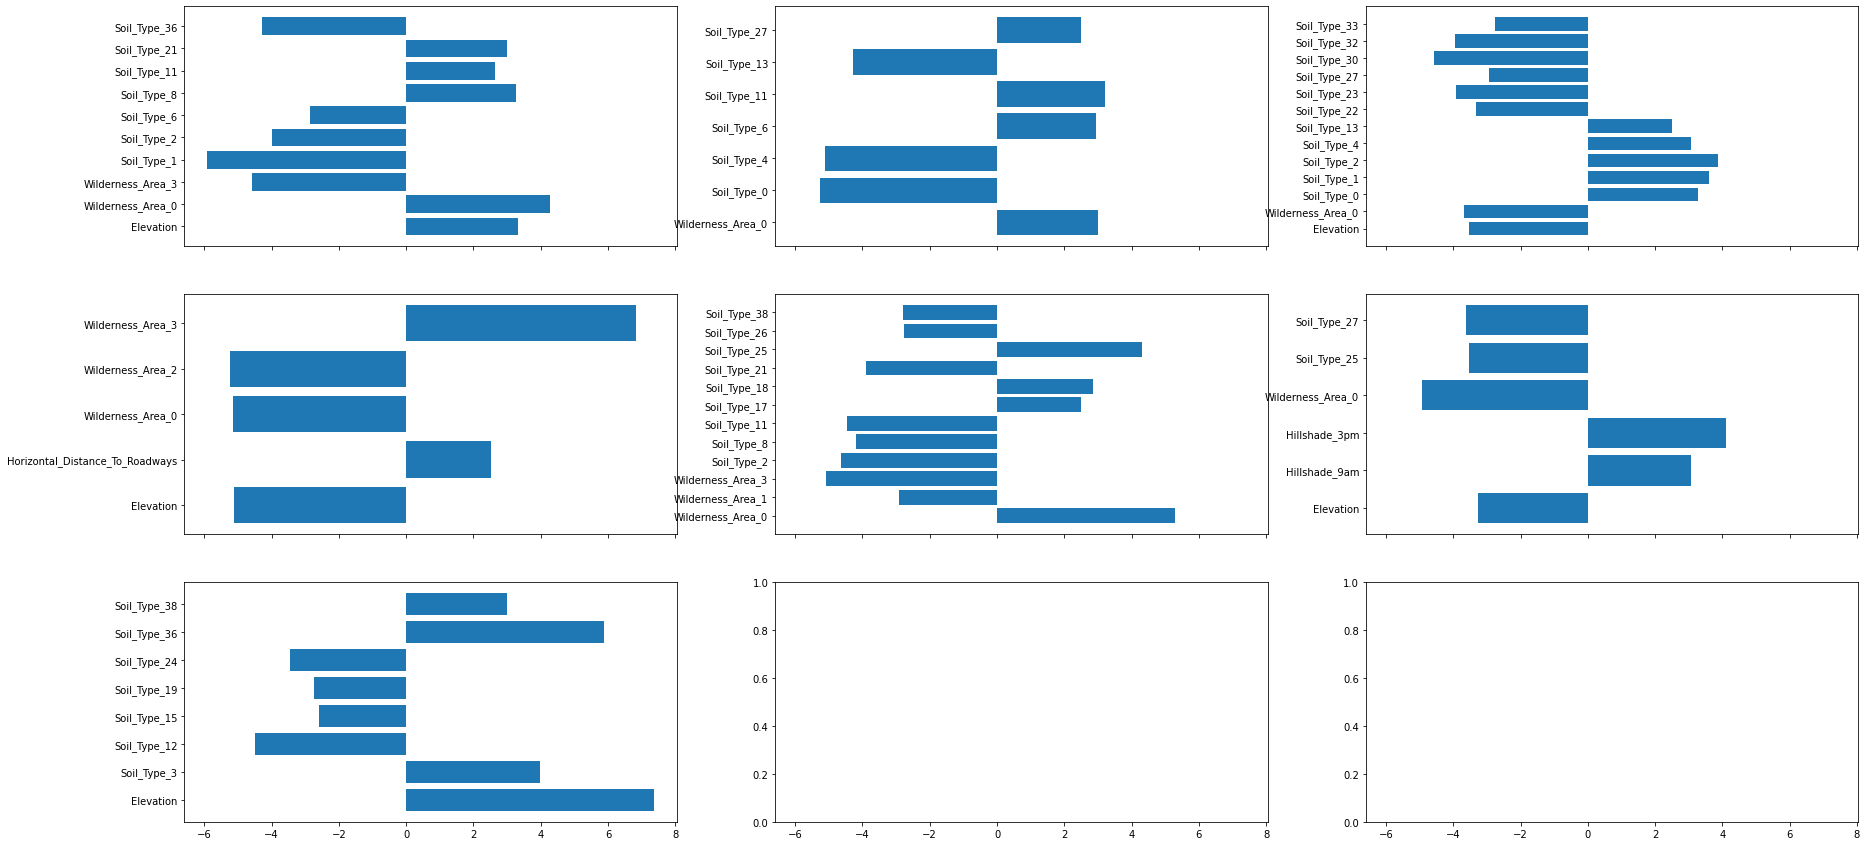

In [ ]:
fig, ax = plt.subplots ( 3,3, sharex=True,  figsize = (30,15))
ax[0,0].barh (y = tdf_1['features']  , width= tdf_1[1])
ax[0,1].barh (y = tdf_2['features']  , width= tdf_2[2])
ax[0,2].barh (y = tdf_3['features']  , width= tdf_3[3])
ax[1,0].barh (y = tdf_4['features']  , width= tdf_4[4])
ax[1,1].barh (y = tdf_5['features']  , width= tdf_5[5])
ax[1,2].barh (y = tdf_6['features']  , width= tdf_6[6])
ax[2,0].barh (y = tdf_7['features']  , width= tdf_7[7])
#bs2.coef_

0.5368594532151849
              precision    recall  f1-score   support

           1       0.71      0.70      0.70     33894
           2       0.75      0.80      0.77     45328
           3       0.68      0.78      0.73      5721
           4       0.67      0.47      0.55       439
           5       0.21      0.01      0.01      1519
           6       0.46      0.28      0.35      2779
           7       0.73      0.58      0.65      3282

    accuracy                           0.72     92962
   macro avg       0.60      0.52      0.54     92962
weighted avg       0.71      0.72      0.71     92962



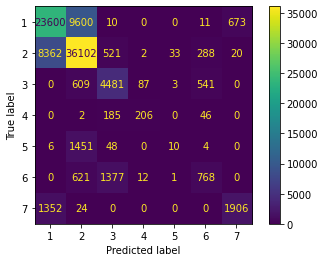

In [ ]:
# пробуем еще раз, меняем метрику и убираем регуляризацию , добавляем итераций, выбираем более быстрый оптимизатор
bs3 = linear_model.LogisticRegression  ( penalty='none' , C=10000 ,  n_jobs=5, max_iter=1000, solver='saga')
bs3.fit ( X_train, y_train)
y_pred = bs3.predict (X_test )
#print (model_selection.cross_val_score (bs3 , X_train, y_train, scoring='f1_macro', cv=3 ))
#print (np.median(model_selection.cross_val_score (bs3 , X_train, y_train, scoring='f1_macro', cv=10)) )
print (metrics.f1_score (y_test, y_pred,  average='macro') )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();
Audio ( sound_file, autoplay=True)

              precision    recall  f1-score   support

           1       0.71      0.70      0.71     42368
           2       0.75      0.80      0.77     56661
           3       0.68      0.80      0.74      7151
           4       0.63      0.42      0.50       549
           5       0.24      0.01      0.01      1899
           6       0.47      0.27      0.35      3473
           7       0.72      0.56      0.63      4102

    accuracy                           0.72    116203
   macro avg       0.60      0.51      0.53    116203
weighted avg       0.71      0.72      0.72    116203



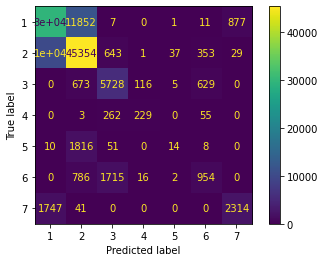

In [ ]:
y_predh = bs3.predict (hold )
print (metrics.classification_report (hold_y, y_predh ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_predh , labels= np.arange (1, 8) ) , display_labels=np.arange (1, 8)  )
cm.plot();
Audio ( sound_file, autoplay=True)

In [ ]:
np.max(bs2.coef_) , bs2.intercept_ # признаков переобучения по-прежнему нет, но добавление итераций еще более увеличит время выполнения, а результаты не растут

(7.380234142523816,
 array([ 5.50229159,  7.58588447, -2.89911164, -8.01349371, -0.39725611,
        -1.88127951,  0.10296491]))

In [ ]:
# Keras
kmc1 = models.Sequential ()
kmc1.add ( layers.Dense (256 , activation='relu'))
kmc1.add ( layers.BatchNormalization ())
kmc1.add ( layers.Dense (256 , activation='relu'))
kmc1.add ( layers.BatchNormalization ())
kmc1.add ( layers.Dense (128 , activation='relu'))
kmc1.add ( layers.Dense (7, activation='softmax'))
kmc1.compile ( loss = 'sparse_categorical_crossentropy' , metrics='acc' )

In [ ]:
his1=kmc1.fit (X_train, y_train-1,  validation_data=(X_test, y_test-1),  epochs=250, verbose=1, batch_size=6000 )
Audio ( sound_file, autoplay=True)

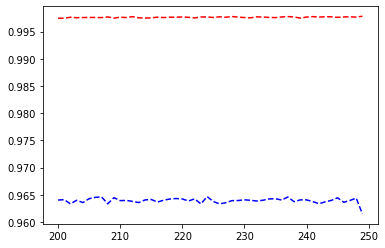

In [ ]:
hd1=his1.history
s= 200
f = 249
loss = his1.history['loss']
acc = his1.history['acc']
loss=loss[s:f+1]
acc=acc[s:f+1]
val_loss = his1.history['val_loss']
val_acc = his1.history['val_acc']
val_loss=val_loss[s:f+1]
val_acc=val_acc[s:f+1]
#plt.plot (np.arange (s, f+1), loss, 'r' )
#plt.plot (np.arange (s, f+1), val_loss, 'b')
plt.plot (np.arange (s, f+1), acc, '--r' )
plt.plot (np.arange (s, f+1), val_acc, '--b')
plt.show()


              precision    recall  f1-score   support

           1       0.95      0.98      0.96     33894
           2       0.98      0.96      0.97     45328
           3       0.96      0.96      0.96      5721
           4       0.90      0.83      0.86       439
           5       0.89      0.89      0.89      1519
           6       0.92      0.94      0.93      2779
           7       0.96      0.96      0.96      3282

    accuracy                           0.96     92962
   macro avg       0.94      0.93      0.93     92962
weighted avg       0.96      0.96      0.96     92962



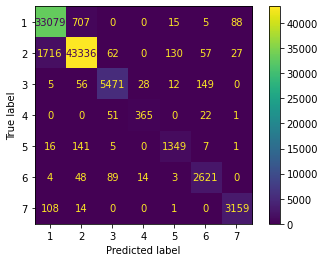

In [ ]:
y_ = kmc1.predict (X_test)
y_pred = [(np.argmax ( y) + 1) for y in y_]
#print (metrics.f1_score (y_test, y_pred,  average='macro') )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

In [ ]:
y_t = kmc1.predict (X_train)
y_pred = [(np.argmax ( y) + 1) for y in y_t]
print (metrics.classification_report (y_train, y_pred ))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99    135578
           2       1.00      0.99      1.00    181312
           3       1.00      1.00      1.00     22882
           4       1.00      0.99      1.00      1759
           5       1.00      1.00      1.00      6075
           6       1.00      1.00      1.00     11115
           7       1.00      1.00      1.00     13126

    accuracy                           1.00    371847
   macro avg       1.00      1.00      1.00    371847
weighted avg       1.00      1.00      1.00    371847



              precision    recall  f1-score   support

           1       0.95      0.97      0.96     42368
           2       0.98      0.96      0.97     56661
           3       0.97      0.96      0.96      7151
           4       0.90      0.86      0.88       549
           5       0.90      0.89      0.90      1899
           6       0.92      0.94      0.93      3473
           7       0.97      0.96      0.97      4102

    accuracy                           0.96    116203
   macro avg       0.94      0.94      0.94    116203
weighted avg       0.96      0.96      0.96    116203



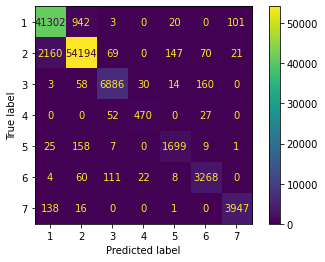

In [ ]:
# нейросеть с огромным отрывом впереди, но это мы не пробовали нелинейные модели, а очевидно, что тут нелинейные свзяи
y_h = kmc1.predict (hold )
y_pred_h = [(np.argmax (y) + 1) for y in y_h]
#print (metrics.f1_score (y_test, y_pred,  average='macro') )
print (metrics.classification_report (hold_y, y_pred_h ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_pred_h , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

              precision    recall  f1-score   support

           1       0.97      0.96      0.96     33894
           2       0.96      0.97      0.97     45328
           3       0.96      0.96      0.96      5721
           4       0.86      0.81      0.84       439
           5       0.91      0.84      0.88      1519
           6       0.94      0.92      0.93      2779
           7       0.98      0.96      0.97      3282

    accuracy                           0.96     92962
   macro avg       0.94      0.92      0.93     92962
weighted avg       0.96      0.96      0.96     92962



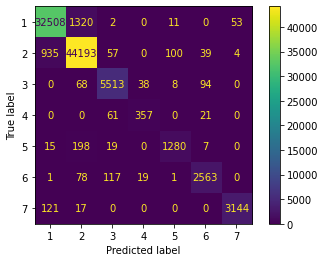

In [ ]:
# XGBoost SciKit
bc = ensemble.GradientBoostingClassifier(n_estimators=300, max_depth=10 )
bc.fit ( X_train, y_train)
y_pred = bc.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

              precision    recall  f1-score   support

           1       0.93      0.93      0.93     33894
           2       0.94      0.94      0.94     45328
           3       0.92      0.92      0.92      5721
           4       0.80      0.81      0.80       439
           5       0.82      0.82      0.82      1519
           6       0.86      0.86      0.86      2779
           7       0.94      0.94      0.94      3282

    accuracy                           0.93     92962
   macro avg       0.89      0.89      0.89     92962
weighted avg       0.93      0.93      0.93     92962



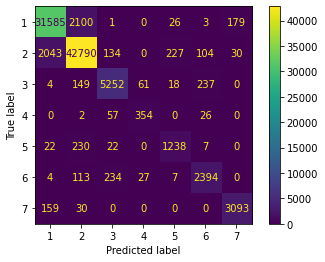

In [ ]:
# Decision Tree
dt = tree.DecisionTreeClassifier( max_depth=500  )
dt.fit ( X_train, y_train)
y_pred = dt.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();
Audio ( sound_file, autoplay=True)

In [ ]:
y_pred_h = bc.predict (hold )
print (metrics.classification_report (hold_y, y_pred_h))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_pred_h , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

              precision    recall  f1-score   support

           1       0.93      0.93      0.93     42368
           2       0.94      0.94      0.94     56661
           3       0.92      0.92      0.92      7151
           4       0.84      0.79      0.81       549
           5       0.83      0.82      0.82      1899
           6       0.86      0.85      0.85      3473
           7       0.94      0.93      0.94      4102

    accuracy                           0.93    116203
   macro avg       0.89      0.88      0.89    116203
weighted avg       0.93      0.93      0.93    116203



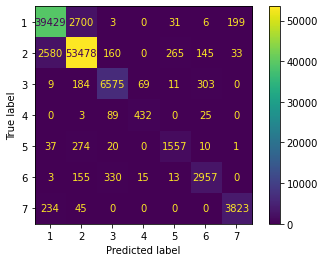

In [ ]:
y_pred_h = dt.predict (hold )
print (metrics.classification_report (hold_y, y_pred_h))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_pred_h , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

In [ ]:
# Сравнение AdaBoost SciKit, LightGBM
score = []
ml = [ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier (max_depth=14) ,n_estimators=500 ), lgbm.LGBMClassifier (  n_estimators=1000, learning_rate=0.11, num_leaves=None,  min_child_samples=2) ,
      lgbm.LGBMClassifier (n_estimators=1000,  learning_rate=0.08, num_leaves=None,   min_child_samples=2, boosting_type = 'goss' ) ]
for m in ml:
  %time  m.fit (X_train, y_train)
  y_pred = m.predict (X_test)
  score.append ([ m,metrics.f1_score (y_test, y_pred , average='macro' )])

CPU times: user 48min 12s, sys: 3.78 s, total: 48min 16s
Wall time: 48min 27s
CPU times: user 6min 36s, sys: 1.3 s, total: 6min 37s
Wall time: 3min 24s
CPU times: user 7min 18s, sys: 1.78 s, total: 7min 20s
Wall time: 3min 46s


In [ ]:
pd.DataFrame (score, columns=['model' , 'f1_macro'])  # обычный LightGBM лучший выбор, с сэмплингом хуже и прироста в скорости нет

,model,f1_macro
0,"(DecisionTreeClassifier(max_depth=14, random_s...",0.928540
1,"LGBMClassifier(learning_rate=0.11, min_child_s...",0.922632
2,"LGBMClassifier(boosting_type='goss', learning_...",0.496172


CPU times: user 1h 18min 38s, sys: 5.14 s, total: 1h 18min 44s
Wall time: 1h 18min 49s
              precision    recall  f1-score   support

           1       0.97      0.95      0.96     33894
           2       0.96      0.97      0.97     45328
           3       0.96      0.96      0.96      5721
           4       0.90      0.86      0.88       439
           5       0.93      0.84      0.88      1519
           6       0.94      0.94      0.94      2779
           7       0.97      0.97      0.97      3282

    accuracy                           0.96     92962
   macro avg       0.95      0.93      0.94     92962
weighted avg       0.96      0.96      0.96     92962



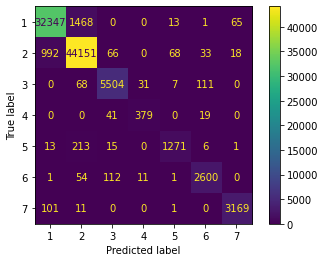

In [ ]:
# оригинальный Xgboost
xbc = xgb.XGBClassifier ( max_depth=12, n_estimators=300, objective='multi:softmax' , )
%time xbc.fit ( X_train, y_train)
y_pred = xbc.predict (X_test )
print (metrics.classification_report (y_test, y_pred ))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (y_test, y_pred , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();
Audio ( sound_file, autoplay=True)

In [ ]:
print (metrics.classification_report (y_train, xbc.predict (X_train )))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99    135578
           2       0.99      1.00      0.99    181312
           3       1.00      1.00      1.00     22882
           4       1.00      1.00      1.00      1759
           5       1.00      0.99      1.00      6075
           6       1.00      1.00      1.00     11115
           7       1.00      1.00      1.00     13126

    accuracy                           0.99    371847
   macro avg       1.00      1.00      1.00    371847
weighted avg       0.99      0.99      0.99    371847



              precision    recall  f1-score   support

           1       0.97      0.95      0.96     42368
           2       0.96      0.98      0.97     56661
           3       0.96      0.97      0.96      7151
           4       0.92      0.87      0.90       549
           5       0.94      0.83      0.88      1899
           6       0.94      0.94      0.94      3473
           7       0.98      0.97      0.97      4102

    accuracy                           0.96    116203
   macro avg       0.95      0.93      0.94    116203
weighted avg       0.96      0.96      0.96    116203



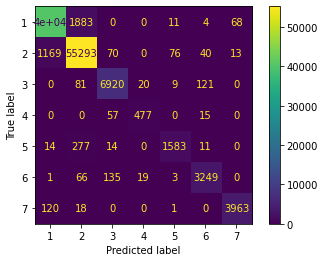

In [ ]:
y_pred_h = xbc.predict (hold )
print (metrics.classification_report (hold_y, y_pred_h))
cm = metrics.ConfusionMatrixDisplay( metrics.confusion_matrix (hold_y, y_pred_h , labels= np.arange (1, 8)), display_labels=np.arange (1, 8)    )
cm.plot();

In [ ]:
xbc.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 12,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 300,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'multi:softprob',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

## Дисбаланс классов и как бороться

In [ ]:
# Дисбаланс плох, потому что :
# 1) иногда признаков так мало, что модель просто не может обучиться на них
# 2) доминирующий класс давит все метрики лосса - тяжко оптимизироваться, проще подстроиться под оптимизацию 99% выборки и забить на оставшийся 1%

# Лечение:
# 1) в случае п.1 клонируем редкие признаки с небольшимии вариациями (аугментация) не самый лучший метод, это по принципу выжать максимум из плохого
# 2) в случае если редких признаков достаточно в абсолютном значении, но мало в относительном, балансируем классы, либо срезав доминирующий класс, либо добавив вектор весов для классов, чтобы редкие классы получили больший вес

# Stacking, Blending

**Blending**  
Обучаем все модели на трейне, потом делаем предикт на тесте, и уже обучаем финальную модель подавая на вход предикты моделей и сравнивая с истинными метками

**Stacking**  
аналог кросс-валидации, делим всю выборку на К блоков, один назначаем тестом, остальные трейном, обучаем базовые модели, получаем предикты на квази тесте, у нас получается, что для каждого объекта их X есть модели, которые использовали его в качестве теста, и мы используем их прогноз.
Иначе говоря, разбили, к примеру, на 3 блока, в новый датасет помещаем предикты по объектам из 1 блока, моделей обученных на 2 и 3 блоках (новый датасет заполнился на треть), потом берем предикты 2 блока моделей, обученных на 1 и3 блоках и добавляем эти предикты в новый датасет (теперь уже 2/3 заполнено), также и с3 блоком, получаетя фулл датасет заполеннный предиктами, и уже его обучаем, сравнивая с фулл таргетом

In [ ]:
# простейшая алгоритм: получаем предикт от одной модели (скажем бустинга), затем предикт от другой модели (скажем нейросеть), выбираем лучший, это наш бенч
# затем в цикле проходим усреднение результатов с разными весами модели: i от 0.01 до 0.99 : res= i* y_pred(M1) + (1-i)*y_pred(M2), если res лучше бенча, фиксируем res и i

# Категориальные признаки

2 подхода:
* кодируем признаки через One Hot Encoding (можно впрямую кодировать: белый =1, черный -2, рыжий 9, но это крайне нежелательно, так порядок подразумевает)
* Mean target encoding, категорию конвертим в число $\overline x_{i,j} = \frac {target (j, x_{i,j})} {count (j, x_{i,j})}$ для регресии и для классификации будет несколько новых признаков (по кол-ву классов)  
То есть по простому: мы делаем count_values по кат признаку (count) и по каждому уник значению делаем фильтр и в считаем сумму таргетов, делим одно на другое получаем среднее по категории, и для каждого уник значения заменяем на среднее по категории  
Для классифкации чуть сложнее, для каждого уника, считаем распределение меток в этой подкатегории ('белый': 0 - 50%, 1 - 30%, 3 - 20%) и меняем признак на распределение его по классам вместо "белый" будет 3 столбца ("0","1","2" со значениями 0.5, 0.3, 0.2  
НО для редких категорий это опасно, модель очень хорошую подсказку получает, по том какой должен быть ответ, поэтому 3 метода борьбы:
 - добавление случайного шума в данные (просто, но риск все равно есть)
 - добавление априора на этапе кодирования (фиктивных признаков) то есть к count прибавляем некую коснтанту а (типо еще какие-тьо признаки) и к $\Sigma$ target  прибавляется константа b (типо сумма фиктивных признаков)
 - кросс-вал при кодированиии (считаем count и сумму таргетов на 1,2 блоке, а заполняем ими 3 блок, потом также заполняем 2 блок (считая на 1,3) и т.п.


# Отбор признаков

Одномерные (к-нт корреляции и т.д.) не айс, не учитывают комбинации признаков  
Лучше использовать свойства самой модели:
  - LASSO
  - в деревьях и ансамблях: критерии информативности, по каждому признаку  находим вершины, где он использовался для разбиения и считаем разницу между критерием информативности в вершине и суммой критериев информативности в листьях. Чем это разница выше, тем лучше (помним, что мы при разбиении выбираем такое где H(l) + H(r) минимальна) соответсвенно, чем больше сумма этих разниц по всем вершинам, по сравнеию с другими признаками тем этот признак лучше. В случае с ансамблями суммируем еще и по всем деревьям композиции (во все основные библы этот алгоритм уже встроен через метод features important)
  - перестановочный метод (после обучения и получения скора по тесту, берем столбец признака в тесте и перемешиваем данные в нем, и снова делаем предикт на тесте, если качество заметно упало, это был важный признак и наоборот
  - жадный отбор признаков (начинаем со всех признаков, выкидываем признаку по одному, смотрим где меньше всего упал скор, выкидываем его, и снова повторяем процедуру). Другая вариация: сначала строим только по одному признаку (перебираем все), выбираем самый полезный, потом повторяем добавление одного лучшего признака

LIME
объяснение вклада признаков на одном конкретном объекте: выбираем объект x из выборки, дальше отбираем только признаки, которые можем интерпритировать,  и синтетически строим множество очень похожих х (окрестности х). Либо ставим нули в один из сьолбцов, либо просто добавляем легкий шум (но без фанатизма из окрестностей х уходить нельзя), потом берем простую интерпретирумую модель (лин рег идеальный вариант) и обучаем на этой выборке, потом смотрим к-нты и понимаем какие признаки вносят наибольший вклад


In [ ]:
data = datasets.fetch_covtype (as_frame=True)
df=data.get('frame')

In [ ]:
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [ ]:
# фуллсет огромен, берем часть для иллюстрации
X_,out, y_, out_y = model_selection.train_test_split (df.iloc[:, :-1] , df.iloc[:, -1], stratify=df.iloc[:, -1] , train_size=0.2) # данных много, отрезаем только 20 % , но с охраненеим баланса классов
X, hold, y, hold_y = model_selection.train_test_split (X_ , y_, stratify=y_ , train_size=0.8) # выделяем hold
X_train, X_test, y_train, y_test = model_selection.train_test_split (X , y, stratify=y , train_size=0.8) # остаток разбиваем на трейн / тест

- RFE - recursive feature elimination - на каждом шаге меряется feature importance  и убирается самый слабый и так до нужного количества.
RFECV в sklearn позволяет через кроссвал получить необходимое кол-во признаков

In [ ]:
# НЕ запускать! 5 часов крутит
estimator = xgb.XGBClassifier (5)
selector = feature_selection.RFECV ( estimator=estimator, scoring='f1_macro')
sel = selector.fit (X, y)
sel.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False, False, False, False,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True])

In [ ]:
sel.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 5, 3, 7, 8,
       1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1])

In [ ]:
np.array (X.columns.to_list())[sel.support_]

array(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0',
       'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3',
       'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_8',
       'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12',
       'Soil_Type_13', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17',
       'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21',
       'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_25', 'Soil_Type_26',
       'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30',
       'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34',
       'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39'],
      dtype='<U34')

(Sequental Feature Selections) жадный отбор признаков (как forward: жадно добавляем по одному лучшему признаку. так и backward жадно убираем один худший признак)

In [ ]:
X, y = datasets.load_boston(return_X_y=True)

In [ ]:
sfs = feature_selection.SequentialFeatureSelector (xgb.XGBClassifier (5) , scoring='r2' , direction='backward' )
sfs.fit (X, y)

SequentialFeatureSelector(direction='backward',
                          estimator=XGBClassifier(max_depth=5), scoring='r2')

In [ ]:
datasets.load_boston ( )['feature_names'][sfs.get_support()]

array(['CRIM', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

permutation tests алгоритм:  
 берем обученную модель, получаем базовый скор, потом в цикле берем каждый столбец, К раз перемешиваем его, на каждом К мерим скор, усредняем по К, вычитаем из базового скора
соотвесвтенно, там где минус - признак важный, там где 0 или полюс - признак шумовой. Важно еще смотреть std , оно будет высоким у важных признаков (перестановки влияют на прогноз)
и околонулевым у неважных то есть все К перестановок почти никак не меняют прогноз

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split (X , y, train_size=0.8)

In [ ]:
xb = xgb.XGBClassifier (5, eval_set = (X_test, y_test), early_stopping = 50)
xb.fit (X_train, y_train )

XGBClassifier(early_stopping=50,
              eval_set=(array([[2.68380e-01, 0.00000e+00, 9.69000e+00, ..., 1.92000e+01,
        3.96900e+02, 1.41000e+01],
       [1.14600e-01, 2.00000e+01, 6.96000e+00, ..., 1.86000e+01,
        3.94960e+02, 7.73000e+00],
       [6.12700e-02, 4.00000e+01, 6.41000e+00, ..., 1.76000e+01,
        3.93450e+02, 4.16000e+00],
       ...,
       [2.11240e-01, 1.25000e+01, 7.87000e+00, ..., 1.52000e+01,
        3.86630e+0...
       23.1, 22.6, 28.7, 21.7, 26.2, 17.8, 15.6, 34.9, 14.5, 25.2, 22.6,
       23. , 20.5, 22.4, 17.3, 20.6, 19.6, 24.5, 48.5, 10.5, 19.9, 37.9,
       13.9,  5. , 50. , 25. , 17.9, 25. , 17.1,  8.4, 13.5, 18.1, 16.5,
       19.5, 21.4, 13.3, 12. , 50. , 29. , 10.2, 20.1, 19.4,  9.5, 13.1,
       20. , 13.8, 19.1, 30.3, 23.2, 19.7, 23.8, 22.2, 23.4, 15.6, 18.7,
       23.1, 10.9, 12.6, 21.6, 23.9, 50. , 21.5, 34.6, 13.1, 32.5, 16.8,
       16.5, 45.4, 15.4])),
              max_depth=5, objective='multi:softprob')

In [ ]:
scr = metrics.r2_score ( y_test, xb.predict (X_test))
scr

0.7251128151602975

In [ ]:
r = inspection.permutation_importance(xb, X_test, y_test, scoring = 'r2' , n_repeats=10 )

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] < 1.000:
         print(f"{datasets.load_boston ( )['feature_names'][i]:<8}"
               f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

LSTAT   0.624 +/- 0.245
RM      0.380 +/- 0.072
DIS     0.105 +/- 0.063
CRIM    0.044 +/- 0.041
AGE     0.042 +/- 0.032
PTRATIO 0.035 +/- 0.019
RAD     0.014 +/- 0.018
NOX     0.011 +/- 0.025
ZN      0.005 +/- 0.013
TAX     0.001 +/- 0.024
B       -0.002 +/- 0.036
CHAS    -0.003 +/- 0.006
INDUS   -0.020 +/- 0.010


In [ ]:
for i in r.importances_std.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] < 1.000:
         print(f"{datasets.load_boston ( )['feature_names'][i]:<8}"
               f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

LSTAT   0.624 +/- 0.245
RM      0.380 +/- 0.072
DIS     0.105 +/- 0.063
CRIM    0.044 +/- 0.041
B       -0.002 +/- 0.036
AGE     0.042 +/- 0.032
NOX     0.011 +/- 0.025
TAX     0.001 +/- 0.024
PTRATIO 0.035 +/- 0.019
RAD     0.014 +/- 0.018
ZN      0.005 +/- 0.013
INDUS   -0.020 +/- 0.010
CHAS    -0.003 +/- 0.006


In [ ]:
datasets.load_boston ( )['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [ ]:
r

{'importances_mean': array([ 4.42727282e-02,  5.30675697e-03, -1.99869916e-02, -2.78453046e-03,
         1.14764215e-02,  3.79551807e-01,  4.21108876e-02,  1.04820176e-01,
         1.39199212e-02,  5.05252756e-04,  3.46985744e-02, -1.68698611e-03,
         6.24160400e-01]),
 'importances_std': array([0.04132395, 0.01278685, 0.01022266, 0.00556906, 0.0249523 ,
        0.07245798, 0.03224503, 0.0628284 , 0.01773866, 0.02369733,
        0.01904135, 0.03649954, 0.24477643]),
 'importances': array([[ 0.06145916,  0.07913766,  0.03683299, -0.01675705,  0.03931235,
          0.13577584,  0.04466054,  0.05337274, -0.0037891 ,  0.01272216],
        [ 0.01457099,  0.01297746, -0.01729615, -0.01335031,  0.00906249,
          0.01711922,  0.01704798,  0.01708122,  0.00472242, -0.00886775],
        [-0.01379678, -0.02315851, -0.02534932, -0.02285571, -0.02036329,
         -0.02505365, -0.00574243, -0.00818498, -0.04306463, -0.01230062],
        [ 0.        , -0.01392265,  0.        ,  0.        ,  

In [ ]:
r['importances'][0].std()

0.04132394574339587

In [ ]:
scr - 0.06145916

0.6636536551602975

In [ ]:
datasets.load_boston ( )['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

# Рекомендательные системы

## Коллаборативная фильтрация

Есть 2 вида:
- **User Based**, ищем юзеров оценки тоторых коррелируют (пусть даже и отрицательно) с нашими оценками
- **Item Based** , ищем товары, которые часто покупают вместе

In [ ]:
# User-based, строится на корреляции Пирсона между оценками юзеров, к которой прикручивается несколько улучшений
df= pd.DataFrame (np.vstack  ((['John' , 0, 5 , 1], ['Ann' , 5,4,0], ['Ivan' , 2, 1, 5], ['Sofa' , 4, 4, 3]  ) ), columns=['User' ,'Valdo' , 'Recall' , 'Time'])
df
# здесь для удобства рсчета пропуски заполенены нулямя (в реальности пропусками), поскольку расчеты вдутся только по тем ячейкаам где есть отличные от нуля значения

,User,Valdo,Recall,Time
0,John,0,5,1
1,Ann,5,4,0
2,Ivan,2,1,5
3,Sofa,4,4,3


In [ ]:
# Ищем расчетный рейтинг Valdo для Джона, первым делом находим к-нты корреляции между оценками Джона на оставшиеся фильмы и оценками других пользователей на эти же фильмы
# Важный момент: в расчет идут только вектора совместных оценок на фильмы, для Джона и Ивана это будет расчет на векторах [5,1] и [1,5], для Джона и Ани только по одной оценке [5] , [4]
# при этом среднее оценок рассчитывается по целому вектору, то есть по всем оценкм юзера
corr_J_A = ((5-3)*(4-4.5) )  / ( np.sqrt ((5-3)**2 ) * np.sqrt ((4-4.5)**2 ) )
corr_J_I =  ((5-3)*(1-2.6666) + (1-3)*(5-2.6666))  / ( np.sqrt ((5-3)**2 + (1-3)**2) * np.sqrt ((1-2.6666)**2 + (5-2.6666)**2) )
corr_J_S =  ((5-3)*(4-3.666) + (1-3)*(3-3.666))    / ( np.sqrt ((5-3)**2 + (1-3)**2) * np.sqrt ((4-3.666)**2 + (3-3.666)**2) )


In [ ]:
df['corr_J'] = ['_' , corr_J_A, corr_J_I, corr_J_S]
df
# Второй важный момент, если у какого либо юзера нет дисперсии оценок (юзер Петя с оценками [5,5,5]), то он сломает формулу, надо таких скипать

,User,Valdo,Recall,Time,corr_J
0,John,0,5,1,_
1,Ann,5,4,0,-1.0
2,Ivan,2,1,5,-0.986389
3,Sofa,4,4,3,0.949062


In [ ]:
# Третий важный момент: если пересечение только с одной оценкой (типа Джона с Аней) то все вырождается в формулу, которая на выходе дает либо +1 либо -1, и никак иначе, это плохо, так как по сути Аня оценила фильм на 4,
# а Джон на 5, но формула дает корреляуцю -1 (так как всего одно пересечение и 4 ниже средней оценки Ани, а 5 выше средней оценки Джона)
# вариант добавлять некий дисконт на количество пересечений, MIN (interaction_J_user/k , 1) то есть ввести некий гиперпараметр k (который надо настраивать), в нашем случае можно ввести k = 3
k=3
#coef = np.min (interaction_J_user/k ,1)
corr_J_A =(1/3) * ((5-3)*(4-4.5) )  / ( np.sqrt ((5-3)**2 ) * np.sqrt ((4-4.5)**2 ) )
corr_J_I =(2/3) * ((5-3)*(1-2.6666) + (1-3)*(5-2.6666))  / ( np.sqrt ((5-3)**2 + (1-3)**2) * np.sqrt ((1-2.6666)**2 + (5-2.6666)**2) )
corr_J_S = (2/3) * ((5-3)*(4-3.666) + (1-3)*(3-3.666))  / ( np.sqrt ((5-3)**2 + (1-3)**2) * np.sqrt ((4-3.666)**2 + (3-3.666)**2) )
df['corr_J'] = ['_' , corr_J_A, corr_J_I, corr_J_S]
df
# теперь модель дисконтирует оценку на малых пересечениях

,User,Valdo,Recall,Time,corr_J
0,John,0,5,1,_
1,Ann,5,4,0,-0.333333
2,Ivan,2,1,5,-0.657592
3,Sofa,4,4,3,0.632708


In [ ]:
# Дальше можно просто взять взвешенные оценки, НО получим на выходе отрицательные рейтинги
(-0.333*5 + -0.657*2 + 0.6327*4)/(0.333 + 0.657 + 0.6327)

-0.2762063227953411

In [ ]:
# лучше всего нормализовать оценки по каждому юзеру (на примере оценок Вальдо)
r_A = (5 - np.array ([5,4]).mean()) / np.array ([5,4]).std()
r_I = (2 - np.array ([2,1,5]).mean()) / np.array ([2,1,5]).std()
r_S = (4 - np.array ([4,4,3]).mean()) / np.array ([4,4,3]).std()
df['Valdo_ranks'] = [0 , r_A, r_I, r_S]
df

,User,Valdo,Recall,Time,corr_J,Valdo_ranks
0,John,0,5,1,_,0.000000
1,Ann,5,4,0,-0.333333,1.000000
2,Ivan,2,1,5,-0.657592,-0.392232
3,Sofa,4,4,3,0.632708,0.707107


In [ ]:
# Дальше считаем средневзвешенный нормализованный рейтинг
rank_w = (-0.1*1 + -0.197*-0.392232 + 0.18*0.707107)/(0.1 + 0.197 + 0.18)
# и декодируем обратно то есть умножаем на std юзера Джона + прибавляем среднее по юзеру Джону
np.array ([5,1]).mean() + rank_w * np.array ([5,1]).std()
# итоговая расчетная оценка для фильма Вальдо для юзера Джона - 3.45

3.4383604360587

Слабые места  User Based CF:
- ранки нестабильны так как мощности пересечений оценок юзеров обычно невелики (в том числе и потому, что люди неохотно ставят оценки)
- любая новая оценка фильма от юзера требует пересчета всех ранков, так как меняется средняя оценка юзера и добавляются похожие юзеры, которых раньше скипали из-за отсутвия оценок

Если взять матрицу из 1000 юзеров и 100 фильмов, в котором заполнено только 10% (то есть в таблице 10 000 отзывов, в среднем каждый юзер оценил 1 из 10 фильмов), то окажется, что в среднем 2 случайных юзера имеют 1 общую оценку, в то время как 2 случайных товара в среднем имеют 10 общих оценок, поэтому Item Based CF более применимо

In [ ]:
#Item Based  строится либо на корреляции Пирсона между оценками фильмов (редко), либо на улучшенной косинусной мере (чаще)
# Итак, задача: посмотреть насколько похожи Вальдо и Recall, если похожи, то рекомендовать Джону Вальдо (так как Джон высоко оценил Recall)
df1 = df.drop(['corr_J' , 'Valdo_ranks'], axis=1)
df1

,User,Valdo,Recall,Time
0,John,0,5,1
1,Ann,5,4,0
2,Ivan,2,1,5
3,Sofa,4,4,3


In [ ]:
# Важно: в расчет опять берем только общие значения
R = np.array ([5,1,4])
T = np.array ([1,5,3])
R.dot(T) / (np.linalg.norm (R) * np.linalg.norm (T)) # обычная косинусная мера

0.5738045840530311

In [ ]:
# у нее есть проблема, она даст похожесть на двух сонаправленных векторах, что не всегда хорошо
A = np.array ([5,5,5])
B = np.array ([1,1,1])
A.dot(B) / (np.linalg.norm (A) * np.linalg.norm (B))

1.0

In [ ]:
# поэтому оценки лучше центрировать (вычесть среднее) ПО юзеру, не по item
A1= A-np.array ([1,5]).mean()
B1 = B-np.array ([1,5]).mean()
A1.dot(B1) / (np.linalg.norm (A1) * np.linalg.norm (B1))

-1.0000000000000002

In [ ]:
# Recall и Time совсем не похожи
R1 = R - np.array([3, 2.666, 3.666])
T1 = T - np.array([3, 2.666, 3.666])
R1.dot(T1) / (np.linalg.norm (R1) * np.linalg.norm (T1))

-0.9827142911777309

In [ ]:
# теперь смотрим похожесть Вальдо на Recall (не очень похожи)
V = np.array ([5,2,4])
R = np.array ([4,1,4])
V1 = V - np.array([4.5, 2.666, 3.666])
R1 = R - np.array([4.5, 2.666, 3.666])
R1.dot(V1) / (np.linalg.norm (R1) * np.linalg.norm (V1))


0.611049170456176

In [ ]:
# переводим косинус в градусы
(np.arccos (0.611) *180) /np.pi

52.338155350666405

In [ ]:
# теперь смотрим похожесть Вальдо на Time (совсем не похожи)
V = np.array ([2,4])
T = np.array ([5,3])
V1 = V - np.array([2.666, 3.666])
T1 = T - np.array([2.666, 3.666])
T1.dot(V1) / (np.linalg.norm (T1) * np.linalg.norm (V1))


-0.9825872101197034

In [ ]:
df1

,User,Valdo,Recall,Time
0,John,0,5,1
1,Ann,5,4,0
2,Ivan,2,1,5
3,Sofa,4,4,3


In [ ]:
V1 , R1

(array([ 0.5  , -0.666,  0.334]), array([-0.5  , -1.666,  0.334]))

In [ ]:
1- sc.spatial.distance.cosine ( R, T)

0.5738045840530313

## MF

### Funk SVD

In [ ]:
# создаем таблицу близкую к боевой, с пропусками
df= pd.DataFrame (np.vstack  (([None, 4, 5 , 1], [ 5, None, 4, 4], [ None, 1, 3, None], [ 4, None, 3, None] , [ 4 , None , None, 5]) ),
                  index = ['John' , 'Ivan' , 'Ann' , 'Sofa' , 'Olga' ]   , columns=['Valdo' , 'Recall' , 'Time', 'Titanic'])
df

,Valdo,Recall,Time,Titanic
John,None,4,5,1
Ivan,5,None,4,4
Ann,None,1,3,None
Sofa,4,None,3,None
Olga,4,None,None,5


In [ ]:
# PCA, SVD не работате с пропусками, поэтому они не работают в лоб
pca = decomposition.TruncatedSVD ( )
pca.fit_transform (mx )

In [ ]:
# алгоритм состоит в том, чтобы по известным оценкам R_ui (Rating_UserItem) построить линрег, который подберет к-нты: M, Bi, Bu, Pu, Qi, такие что R_ui ~ M + Bi + Bu + Pu@Qi + регуляризатор, где
# M-глобальный средний рейтинг, Bi -средний bias юзера (не усредненная оценка , а именно рассчитаный моделью некий к-нт строгости оценок юзера), Bu - то же bias, но по айтему,  Pu - профиль юзера, Qi- профиль итема
# таким образом зная эти к-нты мы можем по каждой ячейке юзер/итем получить прогноз R_ui
# сам алгоритм был придуман в рамках Netflix Prize, реализация называется Funk SVD и есть готовая на гитхабе
!git clone https://github.com/gbolmier/funk-svd.git

Cloning into 'funk-svd'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 201 (delta 39), reused 33 (delta 33), pack-reused 135
Receiving objects: 100% (201/201), 56.09 KiB | 5.61 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [ ]:
import sys
sys.path.append('/content/funk-svd')
import funk_svd
#from funk_svd.dataset import fetch_ml_ratings

In [ ]:
# Количество заполненных полей таблицы
df.size - df.isna().sum().sum()

12

In [ ]:
# Модуль принимает на вход датафрейм вида U_id, I_id, Rating, создадим ее
df_r = pd.DataFrame (np.zeros ((12,3)), columns=["u_id" ,	"i_id" ,	"rating"])

In [ ]:
# теперь заполним датафрейм
i=0
for ix, data in df.iterrows ():
  for f in data.index:
   if data[f] != None:
    df_r.loc[i, 'u_id' ] = ix
    df_r.loc[i, 'i_id' ] = f
    df_r.loc[i, 'rating' ] = data[f]
    i +=1

In [ ]:
df_r

,u_id,i_id,rating
0,John,Recall,4.0
1,John,Time,5.0
2,John,Titanic,1.0
3,Ivan,Valdo,5.0
4,Ivan,Time,4.0
5,Ivan,Titanic,4.0
6,Ann,Recall,1.0
7,Ann,Time,3.0
8,Sofa,Valdo,4.0
9,Sofa,Time,3.0


In [ ]:
# делим на трейн и val (обязательное требование)
train = df_r.sample(frac=0.7)
val = df_r.drop(train.index.tolist())

In [ ]:
svd = funk_svd.SVD(lr=0.001, reg=0, n_epochs=5, n_factors=4, # количество категорий итемов, аналог главных компонент PCA, у нас всего 4 итема поэтому ничего снижать не будем
         early_stopping=True, shuffle=False, min_rating=1, max_rating=5)

svd.fit(X=train, X_val=val)

Preprocessing data...

Preprocessing data...

Epoch 1/5  | val_loss: 15522.41 - val_rmse: 124.59 - val_mae: 68.59 - took 0.0 sec
Epoch 2/5  | val_loss: 74324428855574.14 - val_rmse: 8621161.69 - val_mae: 4331274.30 - took 0.0 sec

Training took 0 sec


In [ ]:
svd.predict (df_r) # на малом датасете линрег все усреднил, но на большом все работает как надо,

[5, 1, 5, 5, 1, 5, 5, 1, 5, 1, 1, 5]

In [ ]:
metrics.mean_absolute_error ( df_r['rating'] , svd.predict (df_r))

2.0833333333333335

In [ ]:
# чтобы получить оценки по пропускам надо на вход подать переделанный датафрейм
df_n = pd.DataFrame (np.zeros ((8,3)), columns=["u_id" ,	"i_id" ,	"rating"])
i=0
for ix, data in df.iterrows ():
  for f in data.index:
   if data[f] == None:
    df_n.loc[i, 'u_id' ] = ix
    df_n.loc[i, 'i_id' ] = f
    df_n.loc[i, 'rating' ] = data[f]
    i +=1

In [ ]:
df_n

,u_id,i_id,rating
0,John,Valdo,NaN
1,Ivan,Recall,NaN
2,Ann,Valdo,NaN
3,Ann,Titanic,NaN
4,Sofa,Recall,NaN
5,Sofa,Titanic,NaN
6,Olga,Recall,NaN
7,Olga,Time,NaN


In [ ]:
svd.predict (df_n) # разумеется тут тоже 3.2, если регуляризатор выкрутить в минус можно увидеть, что модель все таки пытается подстроиться

[1, 5, 5, 5, 5, 1, 5, 1]

### ALS

Алгоритм ALS (Alternate Least Squares) состоит в следующем: мы также берем существующие оценки юзеров итемам и решаем задачу линрега только уже немного по другой логике : мы говорим что рейтинг это скалярной произведение профиля юзера P_u на профиль итема Q_i, соотсветсвнно, у нас на выходе 2 матрицы составленные из профилей: P и Q.  
Мы не знаем эти значения, поэтому инициализируем случайными значениями P и Q.  
Дальше мы фиксируем одну из переменных (к примеру P) и подбираем такие веса для каждого итема Q, чтобы P@Q давало лучшую аппроксимацию Rat. Важно понять, что для каждого итема у нас как бы образуется стангдартный линрег, есть профили юзера (это матрица признаков) и есть веса, которые надо подобрать так чтобы, перемножая любого юзера на вектор весов получались примерные оценки, то есть Ax = b.  Решаем оыбчными МНК (Ridge к примеру).  
Подобрав таким образом веса для каждого итема получаем на выходе случайно заполенную матрицу P и расчетную матрицу Q. А теперь меняем их местами и проделываем ровно то же самое (поэтому метод и Alternate), то есть фиксируем Q_i и подбираем через линрег такой профиль юзера, который хорошо аппроксимирует оценки этого юзера по итемам, то есть теперь матрица признаков это Q, а вектор весов P_i. Итак по каждому юзеру, на выходе получаем ту же матрицу Q но матрица P уже рассчитаная через линрег. Метод чем-то напоиманет покоординатный спуск.  
Повторяем до сходимости, то есть то некого tol, когда аппрокисамация не улучшfется больше, чем на tol

У ALS есть реализация Implicit ALS для неявных фидбеков - это когда оценок нет, но есть какие-то показатели взаимодействия: время просмотра, время прочтения, добавление в корзину и т.п.  Хороший пример: статьи на портале, никто не ставит им звезды, но потому сколько человек сидел на странице, сколько пролистываний делал можно уверенно предположить, что ему понравился контент.  
Главное отчиие алгоритма: после определенного препроцессинга данных (все взаимодействия мы переводим в единицы. в нулях отсаются только юзер-итемы без взаимодействия, и вводим новую матрицу - матрицу уверенности, котрая равна $C = 1 + r$, где $r$ как раз 1 или 0 из матрицы взаимодействия) мы решаем не МНК или пакетами, а аналитически. Благодаря паре трюков, это оказывается вычислительно приемлемым и быстрым (отдельно выносится матрица итемов, которая считается очень долго, но считается 1 раз, так как не зависит от юзеров).  
Реализация алгоритма есть в github, в составке библиотеки Implicit

In [ ]:
df

,Valdo,Recall,Time,Titanic
John,None,4,5,1
Ivan,5,None,4,4
Ann,None,1,3,None
Sofa,4,None,3,None
Olga,4,None,None,5


In [ ]:
#!pip install implicit
import implicit
from implicit.datasets.movielens import get_movielens

/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


In [ ]:
t ,r= get_movielens('20m')

In [ ]:
len(r[2].A[0])

138494

In [ ]:
r.shape[0]

131263

In [ ]:
r

<131263x138494 sparse matrix of type '<class 'numpy.float32'>'
	with 20000263 stored elements in Compressed Sparse Row format>

In [ ]:
r.A[1]

In [ ]:
r.shape[0]*r.shape[1]

18179137922

In [ ]:
"""
An example based off the MovieLens 20M dataset.
This code will automatically download a HDF5 version of this
dataset when first run. The original dataset can be found here:
https://grouplens.org/datasets/movielens/.
Since this dataset contains explicit 5-star ratings, the ratings are
filtered down to positive reviews (4+ stars) to construct an implicit
dataset
"""

from __future__ import print_function

import codecs

import numpy as np
import tqdm

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight
# bm25 функция ранжирования, используемая поисковыми системами для упорядочивания документов по их релевантности данному поисковому запросу

def calculate_similar_movies(output_filename, model_name="als", min_rating=4.0, variant="20m"):
    # read in the input data file

    titles, ratings = get_movielens(variant)

    # remove things < min_rating, and convert to implicit dataset
    # by considering ratings as a binary preference only
    ratings.data[ratings.data < min_rating] = 0
    ratings.eliminate_zeros()
    ratings.data = np.ones(len(ratings.data))

    # generate a recommender model based off the input params
    model = AlternatingLeastSquares()
    ratings = (bm25_weight(ratings, B=0.9) * 5).tocsr()

    user_ratings = ratings.T.tocsr()

    # train the model

    model.fit(user_ratings)

    user_count = np.ediff1d(ratings.indptr)
    to_generate = sorted(np.arange(len(titles)), key=lambda x: -user_count[x])


    with tqdm.tqdm(total=len(to_generate)) as progress:
        with codecs.open(output_filename, "w", "utf8") as o:
            for movieid in to_generate:
                # if this movie has no ratings, skip over (for instance 'Graffiti Bridge' has
                # no ratings > 4 meaning we've filtered out all data for it.
                if ratings.indptr[movieid] != ratings.indptr[movieid + 1]:
                    title = titles[movieid]
                    for other, score in zip(*model.similar_items(movieid, 11)):
                        o.write(f"{title}\t{titles[other]}\t{score}\n")
                progress.update(1)


In [ ]:
    calculate_similar_movies(
        '/content/1.csv'
    )

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 131263/131263 [02:17<00:00, 957.61it/s]  


In [ ]:
pd.read_csv ('/content/1.csv' , sep='\t')

,"Shawshank Redemption, The (1994)","Shawshank Redemption, The (1994).1",1.0000001192092896
0,"Shawshank Redemption, The (1994)",Good Will Hunting (1997),0.974219
1,"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",0.974022
2,"Shawshank Redemption, The (1994)",Schindler's List (1993),0.973022
3,"Shawshank Redemption, The (1994)",Forrest Gump (1994),0.972495
4,"Shawshank Redemption, The (1994)",Seven (a.k.a. Se7en) (1995),0.968724
...,...,...,...
227914,Innocence (2014),7500 (2014),1.000000
227915,Innocence (2014),Ninja: Shadow of a Tear (2013),1.000000
227916,Innocence (2014),Flying Home (2014),1.000000
227917,Innocence (2014),Haunt (2013),1.000000


# Custom_loss_func for Keras (не решено)

In [ ]:
def loss_f (y_test, y_pred):
  y_t = tf.convert_to_tensor (qt.inverse_transform ( y_test) , dtype=tf.float32)
  y_p = tf.convert_to_tensor (qt.inverse_transform ( y_pred) , dtype=tf.float32)
  err.append ( y_test)
  err1.append ( y_pred)
  #h= tf.keras.losses.Huber( )
  return tf.reduce_mean(tf.keras.losses.huber (y_t, y_p) , axis=-1)

In [ ]:
for i in range (4):
  yt = tf.convert_to_tensor (qt.inverse_transform ( err[i]) , dtype=tf.float32)
  print (yt)
  yp = tf.convert_to_tensor (qt.inverse_transform ( err1[i]) , dtype=tf.float32)
  print (yp)
  print (tf.reduce_mean(tf.keras.losses.huber (yt, yp) , axis=-1) )

In [ ]:
err[3] , err[3]

In [ ]:
err[0].numpy().shape


In [ ]:
tf.convert_to_tensor (qt.inverse_transform (err[0]) , dtype=tf.float32)

In [ ]:
qt.inverse_transform ( t1.reshape(-1,1)).info()

In [ ]:
t1 = tf.convert_to_tensor (np.arange(4,7))
t2 = tf.convert_to_tensor (np.arange(1,4))
(t1 - t2)**2
tf.keras.losses.huber(t1 , t2, delta=1 )

In [ ]:
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

In [ ]:
tf.square(t1 - t2)

In [ ]:
tf.convert_to_tensor (km.predict (X_ts).ravel())

In [ ]:
y_ts.shape

In [ ]:
loss_f ( tf.convert_to_tensor (y_ts)  ,  tf.convert_to_tensor   )

In [ ]:
 t = tf.square (tf.convert_to_tensor (y_test) - tf.convert_to_tensor (km.predict (X_ts).ravel()))
 tf.reduce_mean(t, axis=-1)

In [ ]:
tf.square(tf.convert_to_tensor (y_test) - tf.convert_to_tensor (km.predict (X_ts)) )

In [ ]:
my_loss_fn (tf.convert_to_tensor (y_ts) , tf.convert_to_tensor (km.predict (X_ts)))

In [ ]:
loss_f (tf.convert_to_tensor (y_ts) , tf.convert_to_tensor (km.predict (X_ts)) )

In [ ]:
y_ts.shape

In [ ]:
np.dot (kmn.layers[1].get_weights()[0], X_tr[0])

In [ ]:
kmn.layers[1].get_weights()[0]

In [ ]:
X_tr[0]

In [ ]:
kmn.variables

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
np.abs ((y_test  - qt.inverse_transform ( km.predict (X_ts) ).ravel())).sum() / len (y_test)

In [ ]:
reg_scorer (km , y_ts, X_ts, qt)[0]
sns.histplot (reg_scorer (km , y_ts, X_ts, qt)[1] , kde = True )

# NLP

In [ ]:
train = datasets.fetch_20newsgroups(  subset='train')
test = datasets.fetch_20newsgroups( subset='test')
y  = datasets.fetch_20newsgroups(return_X_y=True)[1]

In [ ]:
!pip install keras_nlp

In [ ]:
len (X_test.get('data'))

7532

In [ ]:
train.get('data')[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [ ]:
tk = keras.preprocessing.text.Tokenizer ( num_words=10000)

In [ ]:
tk.fit_on_texts (train)

In [ ]:
X_train = tk.texts_to_matrix ( train)

In [ ]:
tk.texts_to_sequences (train)

[[2], [3], [1, 4], [1], [5]]

In [ ]:
tk.word_index

{'data': 2, 'descr': 5, 'filenames': 3, 'names': 4, 'target': 1}

In [ ]:
import keras_nlp

In [ ]:
tk = keras_nlp.tokenizers.Tokenizer ( )
tk.tokenize (df )

In [ ]:
tk.get_vocabulary

<bound method Tokenizer.get_vocabulary of <keras_nlp.tokenizers.tokenizer.Tokenizer object at 0x7eff7a34ec50>>